In [1]:
%matplotlib inline

import io, os, sys, types, datetime, pickle, warnings

import pandas as pd
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import matplotlib.pylab as pl

warnings.filterwarnings('ignore')

In [2]:
master_path = os.getcwd()
if master_path not in sys.path:
    sys.path.append(master_path)

In [38]:
""" Params """
cat_color = {'Confirmed':'tab:blue', 
              'Deaths':'tab:orange', 
              'Recovered':'tab:green', 
              'Active':'tab:red', 
              'Positive':'tab:purple', 
              'Negative':'tab:olive', 
              'Democratic':'tab:blue', 
              'Republican':'tab:red',
              'Independent':'tab:green'}
cdra_cols = ['Confirmed', 'Deaths', 'Recovered', 'Active']
pn_cols = ['Positive', 'Negative']
party_cols = ['Democratic', 'Republican', 'Independent']

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16
MILLION = 1000000
locator_param = 6

today_csv = '04-01-2020.csv'
today = '04/01/20'

In [4]:
"""Functions"""

'Functions'

In [5]:
######### data acquisition #########
### get lists of subfolders and files of a given path.
def parse_folder_info(path):
    folders = [f for f in os.listdir(path) if not os.path.isfile(os.path.join(path, f))]
    files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    if('.DS_Store' in files):
        files.remove('.DS_Store')
    if('._.DS_Store' in files):
        files.remove('._.DS_Store')
    return folders, files

### get time columns as string list and datetime list
def get_time_columns(columns):
    time_str = []
    time_datetime = []
    for col in columns:
        if col[0].isnumeric():
            time_str.append(col)
            time_datetime.append(datetime.datetime.strptime(col, '%m/%d/%y'))
    return time_str, time_datetime

## reformat time columns to mm/dd/yy
def reformat_time(df):
    time_str, time_datetime = get_time_columns(df.columns)
    times_dic = {}
    for time in time_str:
        date = ''
        for s in time.split('/'):
            if(len(s) == 1):
                date += '0' + s + '/'
            else:
                date += s + '/'
        date = date[:-1]
        times_dic[time] = date
    return df.rename(columns = times_dic)

def reformat_time_string(time):
    date = ''
    for s in time.split('/'):
        if(len(s) == 1):
            date += '0' + s + '/'
        else:
            date += s + '/'
    date = date[:-1]
    return date

def reformat_time_ind_to_string(date_list):
    datelist_str = []
    for date in date_list:
        year = str(date)[:4]
        month = str(date)[4:6]
        day = str(date)[6:]
        date_str = f'{month}/{day}/20'
        datelist_str.append(date_str)
    return datelist_str

def intersection(list1, list2):
    return set(list1).intersection(list2)


In [6]:
######### data fitting #########
### exponential growth function
def exp_growth(t, r, x0):
    return x0 * (1 + r) ** t

### logistic growth function
def logistic_growth(t, r, K, P0):
    return K / (1 + (K - P0)/P0 * np.exp(-r*t))

In [341]:
######### data processing #########
### reshape dataframe so that the index is the dates and the columns are the relative values. better for rolling.
def reshape_dataframe(df, time_str, **kwarg):
    if('Population' in kwarg.keys()):
        population = kwarg['Population']
    else:
        population = 1
    if('Confirmed' in df.index):
        if('Recovered' in df.index):
            df_new = df.transpose().copy(deep=True)
            df_new.rename_axis('Date', axis = 'columns', inplace = True)
            df_new['Active'] = df_new['Confirmed'] - (df_new['Deaths'] + df_new['Recovered'])
            df_new['CFR'] = df_new['Deaths']/df_new['Confirmed'] * 100
            df_new['Recovered_prop'] = df_new.Recovered/(df_new.Deaths + df_new.Recovered) * 100
            df_new['Death_prop'] = df_new.Deaths/(df_new.Deaths + df_new.Recovered) * 100
        else:
            df_new = df.transpose().copy(deep=True)
            df_new.rename_axis('Date', axis = 'columns', inplace = True)
            df_new['CFR'] = df_new['Deaths']/df_new['Confirmed'] * 100
        df_new['Population'] = population
        df_new['Daily_Confirmed'] = df_new['Confirmed'].diff()
        df_new['Daily_Deaths'] = df_new['Deaths'].diff()
        df_new['Daily_Confirmed_smoothed'] = df_new.Daily_Confirmed.rolling(window = 2).mean()
        df_new['Daily_Deaths_smoothed'] = df_new.Daily_Deaths.rolling(window = 2).mean()
        l1 = df_new.loc[time_str[2:],'Daily_Confirmed'].to_list()
        l2 = df_new.loc[time_str[1:-1],'Daily_Confirmed'].to_list()
    else:
        df_new = df.copy(deep = True)
        df_new.rename(columns = {df_new.columns[0]:'Confirmed'}, inplace = True)
        df_new.rename_axis('Date', inplace = True)
        df_new['Daily'] = df_new['Confirmed'].diff()
        df_new['Daily_smoothed'] = df_new.Daily.rolling(window = 2).mean()
        l1 = df_new.loc[time_str[2:],'Daily'].to_list()
        l2 = df_new.loc[time_str[1:-1],'Daily'].to_list()
    
    df_new.loc[time_str[2:],'GF'] = np.divide(l1, l2)
    df_new['GF_rolling_thr'] = df_new.GF.rolling(window = 3).mean()
    df_new[~np.isfinite(df_new)] = 0
    df_new['GF_rolling'] = df_new.GF.rolling(window = 2).mean()
    df_new[~np.isfinite(df_new)] = 0
    return df_new

### update 'time_series_covid19.csv' based on daily reports from CSSE's github repository
def update_time_series(df_today, df_time_series, today):
    time_str, time_datetime = get_time_columns(df_time_series.columns)
    gps_today = list(df_today.groupby(['Country_Region', 'Province_State']).groups.keys())
    gps_ts = list(df_time_series.groupby(['Country_Region', 'Province_State']).groups.keys())
    gps = set(gps_today + gps_ts)
    for igp, gp in enumerate(gps):
        if(igp%30 == 0):
            print(igp)
        if(gp not in gps_ts):
            print(f'{gp} is new!')
            df_new = pd.DataFrame(columns = df_time_series.columns)
            for i, cat in enumerate(cdra_cols[:-1]):
                df_new.loc[i,'Country_Region'] = gp[0]
                df_new.loc[i,'Province_State'] = gp[1]
                df_new.loc[i, time_str] = 0
                df_new.loc[i, today] = df_today.groupby(['Country_Region', 'Province_State']).get_group(gp).loc[:,cat].to_list()[0]
                df_new.loc[i, 'Category'] = cat
            df_time_series = df_time_series.append(df_new, ignore_index = True)
        elif(gp not in gps_today):
            print(f'{gp} not in new today!')
            for cat in cdra_cols[:-1]:
                i = df_time_series[(df_time_series.Country_Region == gp[0]) 
                   * (df_time_series.Province_State == gp[1]) 
                   * (df_time_series.Category == cat)].index
                df_time_series.loc[i,today] = df_time_series.loc[i,time_str[-1]]
        else:
            for cat in cdra_cols[:-1]:
                i = df_time_series[(df_time_series.Country_Region == gp[0]) 
                   * (df_time_series.Province_State == gp[1]) 
                   * (df_time_series.Category == cat)].index
                a = df_today.groupby(['Country_Region', 'Province_State']).get_group(gp).sum()[cat]
                df_time_series.loc[i,today] = a
    time_str, time_datetime = get_time_columns(df_time_series.columns)
    cols_ordered = ['Province_State', 'Country_Region', 'Category'] + sorted(time_str)
    df_time_series = df_time_series.reindex(cols_ordered, axis=1)
    df_time_series.to_csv(os.path.join(path_time_series, 'time_series_covid19.csv'), index = False)
    print('New spreadsheet saved!')
    return df_time_series

### get growth rate by fitting time series data to exponeitial or logistic growth model.
def get_growth_rate(df_ctry, time_str):
    x = np.arange(len(time_str))
    y = df_ctry.Confirmed.to_list()

    res = df_ctry[df_ctry.GF_rolling_thr != 0.0].bfill(axis=1).index[0]
    ind_t0 = max(0, time_str.index(res)-3)
    t = np.arange(len(time_str))[ind_t0:]- ind_t0
    pt = y[ind_t0:]
    
    r = []
    
    try:
        popt_log, pcov_log = opt.curve_fit(logistic_growth,  t,  pt, maxfev=100000)
        r.append(popt_log[0])
    except RuntimeError:
        r.append(np.inf)
    try:
        popt_log1, pcov_log1 = opt.curve_fit(logistic_growth,  t,  pt, p0 = (0.1, 100, 1), maxfev=100000)
        r.append(popt_log1[0])
    except RuntimeError:
        r.append(np.inf)
    return np.min(r)



In [48]:
######### plotting #########
### Setting tick labels from a list of values (time_str or test_time_str)
### adapted from: https://matplotlib.org/3.2.1/gallery/ticks_and_spines/tick_labels_from_values.html
def format_fn(tick_val, tick_pos):
    if(tick_val >= 0 and tick_val < len(time_str)):
        return time_str[int(tick_val)]
    else:
        return None

def format_fn_tests(tick_val, tick_pos):
    if(tick_val >= 0 and tick_val < len(test_time_str)):
        return test_time_str[int(tick_val)]
    else:
        return None

### Attach a text label above each bar in *rects*, displaying its height.
### source: https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html
def autolabel(rects, ax, str_format):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(str_format.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

### display only values of pct>2% when plotting pie plot.
### adapted from: https://stackoverflow.com/questions/6170246/how-do-i-use-matplotlib-autopct
def my_autopct(pct):
    return ('%1.1f%%' % pct) if pct > 2 else ''

### create two subplots in line with two y axes each
### adapted from: https://stackoverflow.com/questions/44825950/matplotlib-create-two-subplots-in-line-with-two-y-axes-each
# def two_scales(ax1, y1, y2, cat_color, legend_size):

#     ax2 = ax1.twinx()
#     for cat in y1.columns:   
#         ax1.plot(y1[cat], color=cat_color[cat])
#     ax1.legend(y1.columns, fontsize = legend_size)
#     for cat in y2.columns:   
#         ax2.plot(y2[cat], color=cat_color[cat])
#     ax2.legend(y2.columns, fontsize = legend_size)
#     return ax1, ax2
def plot_tests_bar_and_percent(ax1, x, y1, y2, color1, color2):
    ax2 = ax1.twinx()
    for i, cat in enumerate(y1.columns):
        ax1.bar(x, y1[cat], color = color1[i])
    ax2.plot(x, y2, linewidth = 2, color = color2)
    ax1.legend(['Negative', 'Positive'])
    ax2.legend(['%positive'], loc = 'upper center')
    ax1.set_ylabel('Number of tests')
    ax2.set_ylabel('Positive%')
    return ax1, ax2

def get_residuals(df_fit, fit_intercept):
    X = np.array([df_fit[cat_x]]).transpose()
    y = df_fit[cat_y].to_numpy()
    reg = LinearRegression(fit_intercept = fit_intercept).fit(X, y)
    y_predicted = reg.predict(X)
    residuals = (y-y_predicted)
    df_fit.loc[:,'Residuals'] = residuals
    return df_fit, reg

def add_country_annotations(ax, df_fit, countries, color):
    for ctry in countries:
        pos = [df_fit.loc[ctry, cat_x], 
                  df_fit.loc[ctry, cat_y]]
        ax.plot(pos[0], pos[1], 'o', color = color)
        p1.text(pos[0]+0.01, pos[1] +0.01, ctry, 
                horizontalalignment='left', size='medium', 
                color='black',weight='normal')
    return ax

def get_annotation_list(df_fit, key_countries, is_joint):
    countries = []
    if(is_joint):
        countries += list(df_fit.sort_values(by = 'Residuals').index[-3:])
        countries += list(df_fit.sort_values(by = 'Residuals').index[:3])
        countries += intersection(list(df_fit.index), key_countries)
        countries = list(set(countries))
    else:
        countries += list(df_fit.sort_values(by = 'Residuals').index[-5:])
        countries += list(df_fit.sort_values(by = 'Residuals').index[:5])
    return countries

In [9]:
def plot_predictions(ax1, x0, y0, x1, y1, x2, y2, color):
    ax2 = ax1.twinx()
    ax1.plot(x0, y0, '.', ms = 10, color = color)
    ax1.plot(x1, y1, linewidth = 2, color = color)
#     ax1.set_ylim(top = max(y1) + max(y1)/10)
    ax2.bar(x2, y2, color = color, alpha = 0.5)
    ax2.plot(x0[1:], y0[1:] - y0[:-1], '--', linewidth = 2, color = color)
#     ax2.set_ylim(top = max(y2) + max(y2)/10)
    ax1.set_ylabel('Total Number')
    ax2.set_ylabel('Daily Number')
    ax1.legend(['Data',
                'Logistic Fit'])
    ax2.legend(['Daily Cases', 'Fitted Daily Cases'], loc = 'center right')
    ax1.set_ylim(bottom = 0)
    ax2.set_ylim(bottom = 0)
    return ax1, ax2

In [10]:
def format_fn_future(tick_val, tick_pos):
    if(tick_val >= 0 and tick_val < len(time_str)):
        return time_str[int(tick_val)]
    else:
        return f'+{tick_val - len(time_str)}'

In [11]:
def my_autopct_v2(pct):
    return f'{pct*total/100:.0f}({pct:1.1f}%)' if pct > 2 else ''

https://lmfit.github.io/lmfit-py/model.html

In [12]:
"""Get Data"""

'Get Data'

In [13]:
### 
path_time_series = os.path.join(master_path, 'csse_covid_19_data', 'csse_covid_19_time_series')
folders, files = parse_folder_info(path_time_series)
df_global = pd.DataFrame()
df_US_ori = pd.DataFrame()
for file in files:
    if('.csv' in file):
        print(file)
        df_tmp = pd.read_csv(os.path.join(path_time_series, file))
        cat = file.split('_')[3]
        df_tmp['Category'] = cat[0].upper()+cat[1:]
        if('global' in file):
            df_tmp = df_tmp.drop(labels = ['Lat', 'Long'], axis = 1)
            df_global = df_global.append(df_tmp)
        elif('US' in file):
            df_tmp = df_tmp.drop(labels = ['Lat', 'Long_', 'UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Combined_Key'], axis = 1)
            df_US_ori = df_US_ori.append(df_tmp)
df_global.rename(columns={"Province/State": "Province_State", "Country/Region": "Country_Region"}, inplace = True)
df_global = reformat_time(df_global)
df_US_ori = reformat_time(df_US_ori)
time_str, time_datetime = get_time_columns(df_global.columns)

time_series_covid19_confirmed_global.csv
time_series_covid19_confirmed_US.csv
time_series_covid19_recovered_global.csv
time_series_covid19_deaths_global.csv
time_series_covid19_deaths_US.csv


In [358]:
# ### get summarized time series data
# path_time_series = os.path.join(master_path, 'covid_19_data')
# df_time_series = pd.read_csv(os.path.join(path_time_series, 'time_series_covid19.csv'))
# df_time_series.loc[df_time_series.loc[:,'Province_State'].isna(),'Province_State'] = 'N/A'
# df_time_series = reformat_time(df_time_series)
# time_str, time_datetime = get_time_columns(df_time_series.columns)

### get daily update
path_daily = os.path.join(master_path, 'csse_covid_19_data', 'csse_covid_19_daily_reports')
df_today = pd.read_csv(os.path.join(path_daily, today_csv))
df_today.loc[df_today.loc[:,'Province_State'].isna(),'Province_State'] = 'N/A'

In [15]:
# ### get data from https://coronavirus.1point3acres.com/
# df_US_1p3a = pd.read_csv(os.path.join(path_time_series, 'time_series_covid19_US_1p3a.csv'))
# df_US_1p3a.set_index('Date', inplace = True)
# df_US_1p3a = reformat_time(df_US_1p3a.transpose()).transpose()
# time_str_1p3a, time_datetime_1p3a = get_time_columns(df_US_1p3a.index)
# if(time_str_1p3a[-1] != today):
#     print("ERROR! df_US_1p3a not up to date!")

In [16]:
# ### update time series dataframe with the data from most recent date.
# if(today not in time_str):
#     print('New Data from CSSE! Update time_series_covid19.csv now!')
#     df_time_series = update_time_series(df_today, df_time_series, today)
#     time_str, time_datetime = get_time_columns(df_time_series.columns)
# else:
#     print(f'Data up to date! Today = {today}')

In [17]:
### don't understand WHY ('US', 'Recovered') is a seperate category...
# df_time_series = df_time_series.drop([903, 904, 905], axis = 0)
# df_time_series.to_csv(os.path.join(path_time_series, 'time_series_covid19.csv'), index = False)

In [18]:
### get some other stats
path_covid_19_data = os.path.join(master_path, 'covid_19_data')
df_world_population = pd.read_csv(os.path.join(path_covid_19_data, 'world_population_stats.csv'), encoding = "ISO-8859-1", engine='python')
df_world_population.loc[:, 'Population'] = df_world_population.Population.astype('float')
df_world_population.set_index('Country_Region', inplace = True)

In [19]:
### get US testing stats
us_tests_cols = ['State', 'Governer_Affiliation', 'Population',
                 'positive', 'negative', 'pending', 'hospitalized', 'death', 'totalTestResults']

# testing data source: The COVID tracking project (https://covidtracking.com/)
df_covid_tracking = pd.read_csv('https://covidtracking.com/api/states.csv')
print(f'Time last checked: between {min(df_covid_tracking.checkTimeEt)} and {max(df_covid_tracking.checkTimeEt)}')
print(f'Update time: between {min(df_covid_tracking.lastUpdateEt)} and {max(df_covid_tracking.lastUpdateEt)}')
df_tests_states_daily = pd.read_csv('https://covidtracking.com/api/states/daily.csv')
df_tests_us_daily = pd.read_csv('https://covidtracking.com/api/us/daily.csv')

# state stats data source: wikipedia
df_state_stats = pd.read_csv(os.path.join(path_covid_19_data, 'US_state_stats.csv'))
df_covid_tracking.set_index('state', inplace = True)
df_state_stats.set_index('state', inplace = True)

# conslidate testing data and stat stats data
df_us_tests = pd.DataFrame(columns = us_tests_cols, index = df_covid_tracking.index)
cols1 = intersection(us_tests_cols, list(df_covid_tracking.columns))
cols2 = intersection(us_tests_cols, list(df_state_stats.columns))
df_us_tests.loc[:,cols1] = df_covid_tracking.loc[:,cols1]
df_us_tests.loc[:,cols2] = df_state_stats.loc[:,cols2]
df_us_tests.fillna(0.0, inplace = True)
df_us_tests.loc[:,'Percent_Pos'] = df_us_tests.positive / df_us_tests.totalTestResults * 100
df_us_tests.loc[:,'Test_Per_Million'] = df_us_tests.totalTestResults / (df_us_tests.Population/1000000)
df_us_tests.fillna(0.0, inplace = True)
df_us_tests.loc[:,'Pos_Per_Million'] = np.round(df_us_tests.positive/(df_us_tests.Population/1000000))
# df_us_tests.reset_index(inplace = True)
# df_us_tests.set_index('state', inplace = True)

# daily testing data:
df_tests_us_daily.sort_values(by = 'date', inplace = True, ascending=True)
df_tests_us_daily['date'] = reformat_time_ind_to_string(df_tests_us_daily['date'].to_list())
df_tests_states_daily['date'] = reformat_time_ind_to_string(df_tests_states_daily['date'].to_list())
df_tests_us_daily.set_index('date', inplace = True)
test_time_str = list(df_tests_us_daily.index)

# state mapping
usstate_abbs_mapping = {}
for st_abb in df_state_stats.index:
    usstate_abbs_mapping[df_state_stats.loc[st_abb, 'State']] = st_abb
    usstate_abbs_mapping[st_abb] = df_state_stats.loc[st_abb, 'State']

Time last checked: between 4/02 14:34 and 4/03 00:29
Update time: between 3/30 23:00 and 4/03 00:20


In [20]:
""" Total Recovered, death, and confirmed """

' Total Recovered, death, and confirmed '

In [21]:
df_total = df_global.groupby('Category').sum().loc[:,time_str]
df_mc = df_global.groupby('Country_Region').get_group('China').groupby('Category').sum().loc[:,time_str]
df_row = df_total - df_mc
df_hb = df_global.groupby('Country_Region').get_group('China').groupby('Province_State').get_group('Hubei').groupby('Category').sum().loc[:,time_str]
df_co = df_mc - df_hb

In [22]:
df_total = reshape_dataframe(df_total, time_str)
df_mc = reshape_dataframe(df_mc, time_str)
df_row = reshape_dataframe(df_row, time_str)
df_hb = reshape_dataframe(df_hb, time_str)
df_co = reshape_dataframe(df_co, time_str)

In [23]:
x = np.arange(len(time_str))
y = np.zeros((len(time_str), 2))

y[:,0] = df_mc.Confirmed.to_list()
y[:,1] = df_row.Confirmed.to_list()

popt_exp = []
popt_log = []
for i in [0, 1]:
    p, cov = opt.curve_fit(exp_growth,  x,  y[:,i], p0 = (0.1, 100), maxfev=100000)
    popt_exp.append(list(p))
    p, cov = opt.curve_fit(logistic_growth,  x,  y[:,i], p0 = (0.1, 100, 1), maxfev=100000)
    popt_log.append(list(p))

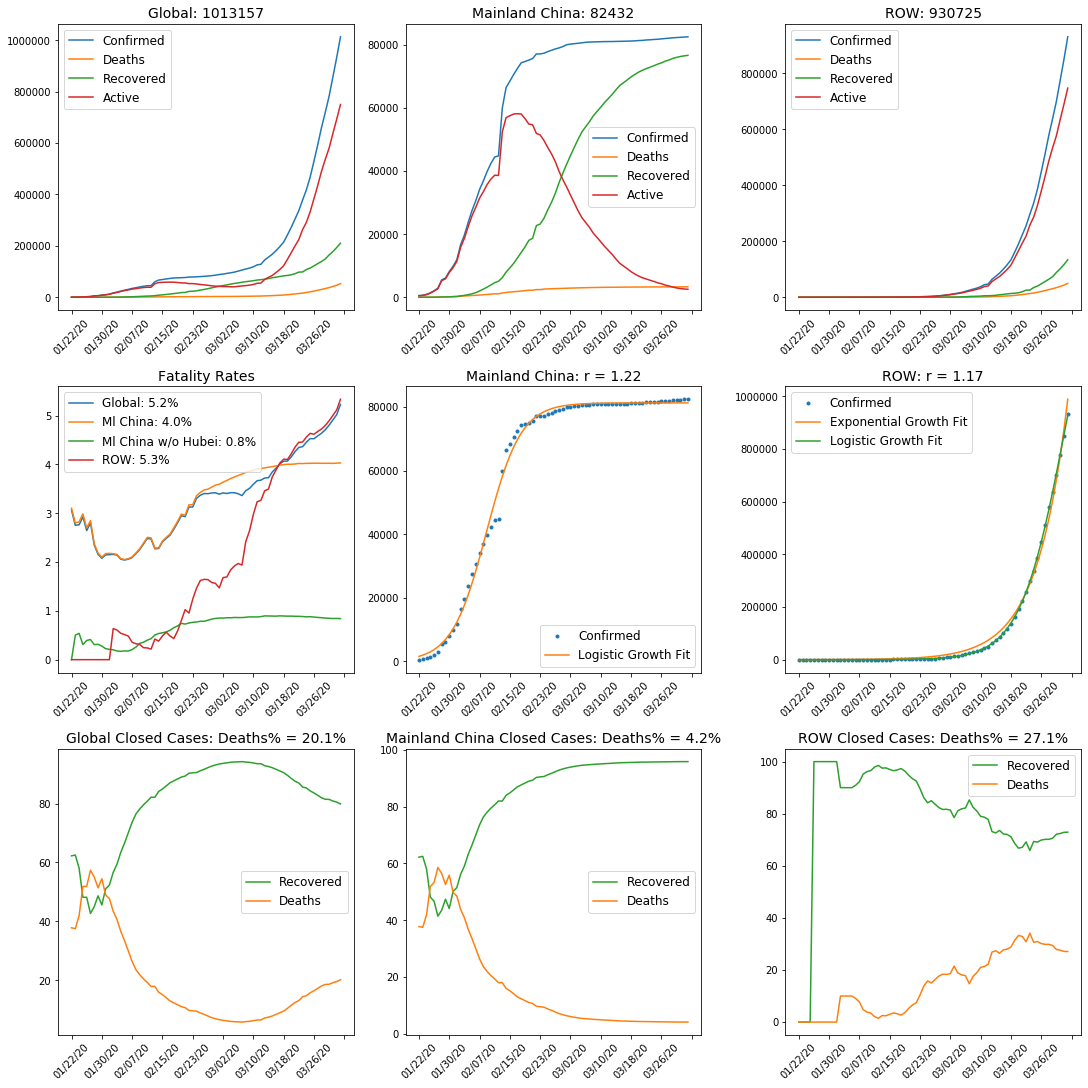

In [24]:
fig = plt.figure(figsize = (15, 15), constrained_layout=True, facecolor="1")
gs = fig.add_gridspec(3,3)

title_size = 14
legend_size = 12

### total confirmed/recovered/death/active
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(df_total[cdra_cols])
# ax11, ax12 = two_scales(ax1, df_total[['Confirmed', 'Active']], df_total[['Recovered', 'Deaths']], cat_color)
myLocator = mticker.MultipleLocator(locator_param)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)
ax1.legend(cdra_cols, fontsize = legend_size)
ax1.set_title(f"Global: {int(df_total.loc[time_str[-1], 'Confirmed'])}", size = title_size)

### mainland china confirmed/recovered/death/active
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(df_mc[cdra_cols])
myLocator = mticker.MultipleLocator(locator_param)
ax2.xaxis.set_major_locator(myLocator)
ax2.tick_params(axis = 'x', labelrotation = 45)
ax2.legend(cdra_cols, fontsize = legend_size)
ax2.set_title(f'Mainland China: {int(df_mc.loc[time_str[-1], "Confirmed"])}', size = title_size)

### rest of the world confirmed/recovered/death/active
ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(df_row[cdra_cols])
# ax31, ax32 = two_scales(ax3, df_row[['Confirmed', 'Active']], df_row[['Recovered', 'Deaths']], cat_color, legend_size)
myLocator = mticker.MultipleLocator(locator_param)
ax3.xaxis.set_major_locator(myLocator)
ax3.tick_params(axis = 'x', labelrotation = 45)
ax3.legend(cdra_cols, fontsize = legend_size)
ax3.set_title(f'ROW: {int(df_row.loc[time_str[-1], "Confirmed"])}', size = title_size)

### fatality rates
ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(df_total.loc[:,'CFR'])
ax4.plot(df_mc.loc[:,'CFR'])
ax4.plot(df_co.loc[:,'CFR'])
ax4.plot(df_row.loc[:,'CFR'])
plt.legend([f'Global: {df_total.CFR[-1]:.1f}%',
            f'Ml China: {df_mc.CFR[-1]:.1f}%',
            f'Ml China w/o Hubei: {df_co.CFR[-1]:.1f}%',
            f'ROW: {df_row.CFR[-1]:.1f}%'
           ], fontsize = legend_size)
myLocator = mticker.MultipleLocator(locator_param)
ax4.xaxis.set_major_locator(myLocator)
ax4.tick_params(axis = 'x', labelrotation = 45)
ax4.set_title('Fatality Rates', fontsize = title_size)

### mainland China fit
ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(x, y[:,0], '.')
ax5.plot(x, logistic_growth(x, popt_log[0][0], popt_log[0][1], popt_log[0][2]))
ax5.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(locator_param)
ax5.xaxis.set_major_locator(myLocator)
ax5.tick_params(axis = 'x', labelrotation = 45)
ax5.legend(['Confirmed', 'Logistic Growth Fit'], fontsize = legend_size)
ax5.set_title(f'Mainland China: r = {popt_log[0][0]+1:.2f}', fontsize = title_size)

### ROW fit
ax6 = fig.add_subplot(gs[1, 2])
ax6.plot(x, y[:,1], '.')
ax6.plot(x, exp_growth(x, popt_exp[1][0], popt_exp[1][1]))
ax6.plot(x, logistic_growth(x, popt_log[1][0], popt_log[1][1], popt_log[1][2]))
ax6.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(locator_param)
ax6.xaxis.set_major_locator(myLocator)
ax6.tick_params(axis = 'x', labelrotation = 45)
ax6.legend(['Confirmed', 'Exponential Growth Fit', 'Logistic Growth Fit'], fontsize = legend_size)
ax6.set_title(f'ROW: r = {popt_log[1][0]+1:.2f}', fontsize = title_size)
              
### total closed cases
ax7 = fig.add_subplot(gs[2, 0])
ax7.plot(df_total.Recovered_prop, color = cat_color['Recovered'])
ax7.plot(df_total.Death_prop, color = cat_color['Deaths'])
myLocator = mticker.MultipleLocator(locator_param)
ax7.xaxis.set_major_locator(myLocator)
ax7.tick_params(axis = 'x', labelrotation = 45)
ax7.legend(['Recovered', 'Deaths'], fontsize = legend_size)
ax7.set_title(f'Global Closed Cases: Deaths% = {df_total.Death_prop[-1]:.1f}%', size = title_size)

### mainland china closed cases
ax8 = fig.add_subplot(gs[2, 1])
ax8.plot(df_mc.Recovered_prop, color = cat_color['Recovered'])
ax8.plot(df_mc.Death_prop, color = cat_color['Deaths'])
myLocator = mticker.MultipleLocator(locator_param)
ax8.xaxis.set_major_locator(myLocator)
ax8.tick_params(axis = 'x', labelrotation = 45)
ax8.legend(['Recovered', 'Deaths'], fontsize = legend_size)
ax8.set_title(f'Mainland China Closed Cases: Deaths% = {df_mc.Death_prop[-1]:.1f}%', size = title_size)

### rest of the world closed cases
ax9 = fig.add_subplot(gs[2, 2])
ax9.plot(df_row.Recovered_prop, color = cat_color['Recovered'])
ax9.plot(df_row.Death_prop, color = cat_color['Deaths'])
myLocator = mticker.MultipleLocator(locator_param)
ax9.xaxis.set_major_locator(myLocator)
ax9.tick_params(axis = 'x', labelrotation = 45)
ax9.legend(['Recovered', 'Deaths'], fontsize = legend_size)
_ = ax9.set_title(f'ROW Closed Cases: Deaths% = {df_row.Death_prop[-1]:.1f}%', size = title_size)

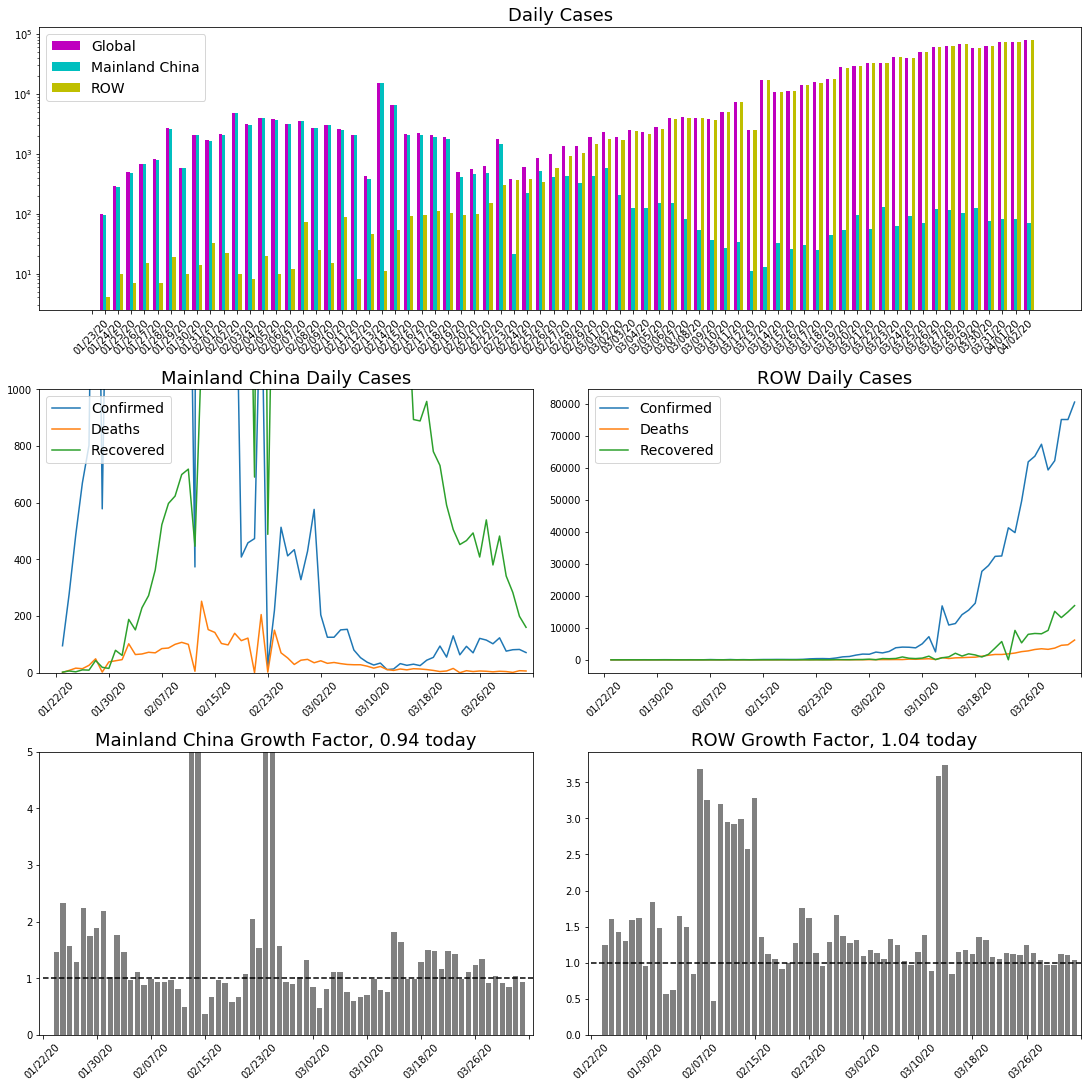

In [25]:
fig = plt.figure(figsize = (15, 15), constrained_layout=True, facecolor="1")
gs = fig.add_gridspec(3,2)

# ### Daily Confirmed cases
ax1 = fig.add_subplot(gs[0, :])
x = np.arange(len(time_str))
width = 0.25

ax1.bar(x + 0, df_total.loc[:,'Daily_Confirmed'], width = width, color = 'm')
ax1.bar(x + width*1, df_mc.loc[:,'Daily_Confirmed'], width = width, color = 'c')
ax1.bar(x + width*2, df_row.loc[:,'Daily_Confirmed'], width = width, color = 'y')
ax1.set_yscale('log')
# ax4.set_ylim([0, 5000])
_ = ax1.set_xticks(x + width)
_ = ax1.set_xticklabels(time_str[1:])
ax1.tick_params(axis = 'x', labelrotation = 45)
ax1.legend(['Global', 'Mainland China', 'ROW'], fontsize = 14, loc='upper left')
ax1.set_title('Daily Cases', size = 18)


### Mainland China daily confirmed/recovered/deaths/active
ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(df_mc[cdra_cols[:-1]].diff())
ax2.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(locator_param)
ax2.xaxis.set_major_locator(myLocator)
ax2.set_ylim([0, 1000])
ax2.set_xlim(right = len(time_str))
ax2.tick_params(axis = 'x', labelrotation = 45)
ax2.legend(cdra_cols, fontsize = 14)
ax2.set_title('Mainland China Daily Cases', size = 18)

### ROW daily confirmed/recovered/deaths/active
ax3 = fig.add_subplot(gs[1, 1])
ax3.plot(df_row[cdra_cols[:-1]].diff())
ax3.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(locator_param)
ax3.xaxis.set_major_locator(myLocator)
ax3.set_xlim(right = len(time_str))
ax3.tick_params(axis = 'x', labelrotation = 45)
ax3.legend(cdra_cols, fontsize = 14)
ax3.set_title('ROW Daily Cases', size = 18)


# ### Mainland China Growth Factor
ax5 = fig.add_subplot(gs[2, 0])

x = np.arange(0, len(time_str))
x1 = np.arange(0, len(time_str) + 2)

ax5.bar(x, df_mc.GF_rolling, color = 'grey')
ax5.plot(x1, np.full(len(x1), 1), '--', color = 'k')
ax5.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(locator_param)
ax5.xaxis.set_major_locator(myLocator)
ax5.set_xlim([-0.5, len(time_str)+0.5])
ax5.set_ylim(top = 5, bottom = 0)
ax5.tick_params(axis = 'x', labelrotation = 45)
ax5.set_title(f'Mainland China Growth Factor, {df_mc.GF_rolling[-1]:.2f} today', size = 18)

### ROW Growth Factor
ax6 = fig.add_subplot(gs[2, 1])
ax6.bar(x, df_row.GF_rolling, color = 'grey')
ax6.plot(x1, np.full(len(x1), 1), '--', color = 'k')
ax6.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(locator_param)
ax6.xaxis.set_major_locator(myLocator)
ax6.set_xlim([-0.5, len(time_str)])
ax6.tick_params(axis = 'x', labelrotation = 45)
_ = ax6.set_title(f'ROW Growth Factor, {df_row.GF_rolling[-1]:.2f} today', size = 18)

In [26]:
"""US"""

'US'

In [27]:
state = 'California'

df_st = df_US_ori.groupby(['Province_State']).get_group(state)
df_CA = df_US_ori.groupby(['Province_State']).get_group('California')
df_DP = df_US_ori.groupby(['Province_State']).get_group('Diamond Princess')
df_GP = df_US_ori.groupby(['Province_State']).get_group('Grand Princess')
df_US_main = df_US_ori.drop(labels = list(df_DP.index) + list(df_GP.index), axis = 0)

In [28]:
df_US = reshape_dataframe(df_US_ori.groupby('Category').sum().loc[:,time_str], time_str)
df_st = reshape_dataframe(df_st.groupby('Category').sum().loc[:,time_str], time_str)
df_US_main = reshape_dataframe(df_US_main.groupby('Category').sum().loc[:,time_str], time_str)
df_DP = reshape_dataframe(df_DP.groupby('Category').sum().loc[:,time_str], time_str)
df_GP = reshape_dataframe(df_GP.groupby('Category').sum().loc[:,time_str], time_str)

st = usstate_abbs_mapping[state]
df_tests_onestate_daily = df_tests_states_daily.groupby('state').get_group(st)
df_tests_onestate_daily.sort_values(by = 'date', inplace = True, ascending=True)
df_tests_onestate_daily.set_index('date', inplace = True)

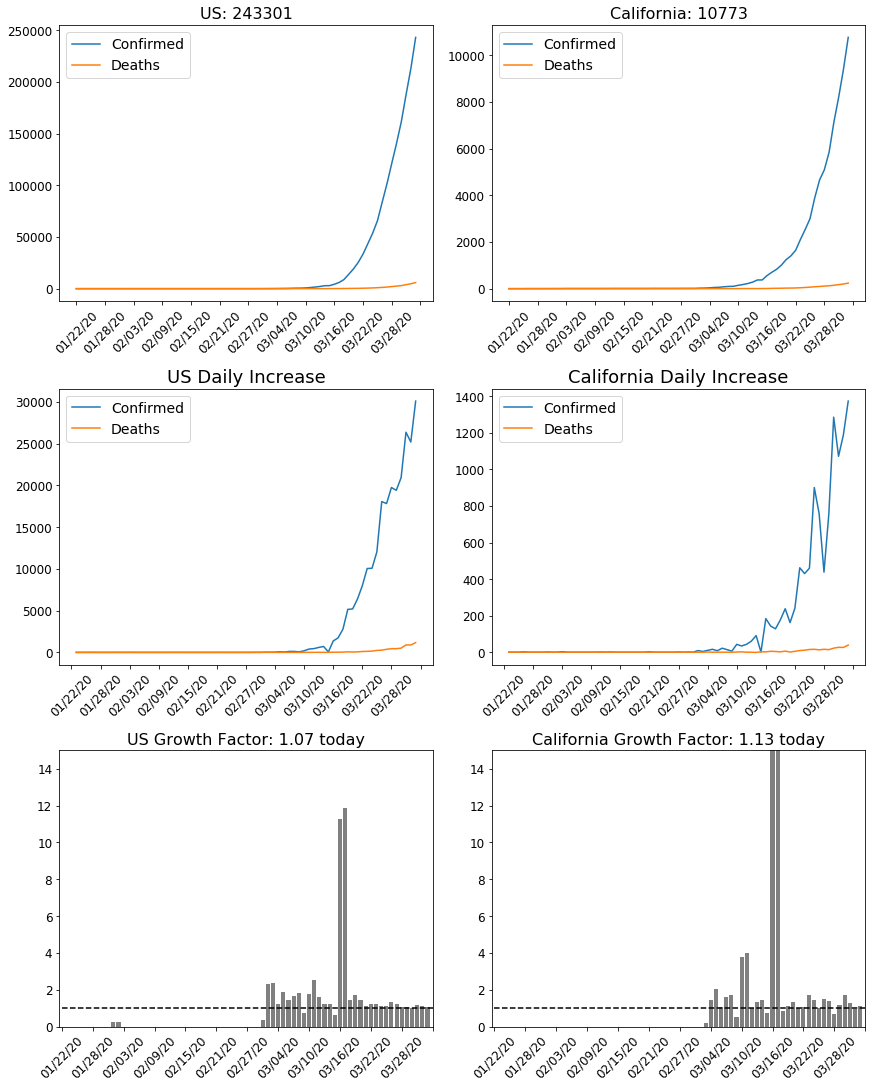

In [39]:
fig = plt.figure(figsize = (12, 15), constrained_layout=True, facecolor="1")
gs = fig.add_gridspec(3, 2)

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


for i in [0,1]:
    if(i == 0):
        plt_title = 'US'
        df_plot = df_US_main
    else:
        plt_title = state
        df_plot = df_st
    
    ### time series
    ax2 = fig.add_subplot(gs[0, i])
    ax2.plot(df_plot[cdra_cols[:2]])
    myLocator = mticker.MultipleLocator(locator_param)
    ax2.xaxis.set_major_locator(myLocator)
    ax2.tick_params(axis = 'x', labelrotation = 45)
    ax2.legend(cdra_cols[:2], fontsize = 14)
    title = f'{plt_title}: {int(df_plot.loc[time_str[-1], "Confirmed"])}'
    ax2.set_title(title)
    
    ### daily
    ax5 = fig.add_subplot(gs[1, i])
    ax5.plot(df_plot[cdra_cols[:2]].diff())
    ax5.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
    myLocator = mticker.MultipleLocator(locator_param)
    ax5.xaxis.set_major_locator(myLocator)
    ax5.tick_params(axis = 'x', labelrotation = 45)
    ax5.legend(cdra_cols[:2], fontsize = 14)
    ax5.set_title(f'{plt_title} Daily Increase', size = 18)
    
    ### closed cases
#     ax8 = fig.add_subplot(gs[2, i])
#     ax8.plot(df_plot.Recovered_prop, color = cat_color['Recovered'])
#     ax8.plot(df_plot.Death_prop, color = cat_color['Deaths'])
#     myLocator = mticker.MultipleLocator(locator_param)
#     ax8.xaxis.set_major_locator(myLocator)
#     ax8.tick_params(axis = 'x', labelrotation = 45)
#     ax8.legend(['Recovered', 'Deaths'], fontsize = 14)
#     ax8.set_title(f'{plt_title} Closed Cases: Deaths% = {df_plot.Death_prop[-1]:.1f}%', size = 18)
    
    ### growth factors
    ax4 = fig.add_subplot(gs[2, i])
              
    x = np.arange(len(time_str))
    x1 = np.arange(0, len(time_str) + 2)

    ax4.bar(x, df_plot.GF_rolling, color = 'grey')
    ax4.plot(x1, np.full(len(x1), 1), '--', color = 'k')
    ax4.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
    myLocator = mticker.MultipleLocator(locator_param)
    ax4.xaxis.set_major_locator(myLocator)
    ax4.set_xlim([-0.5, len(time_str)])
    ax4.tick_params(axis = 'x', labelrotation = 45)
    _ = ax4.set_title(f'{plt_title} Growth Factor: {df_plot.GF_rolling[-1]:.2f} today')
    ax4.set_ylim(top = 15)

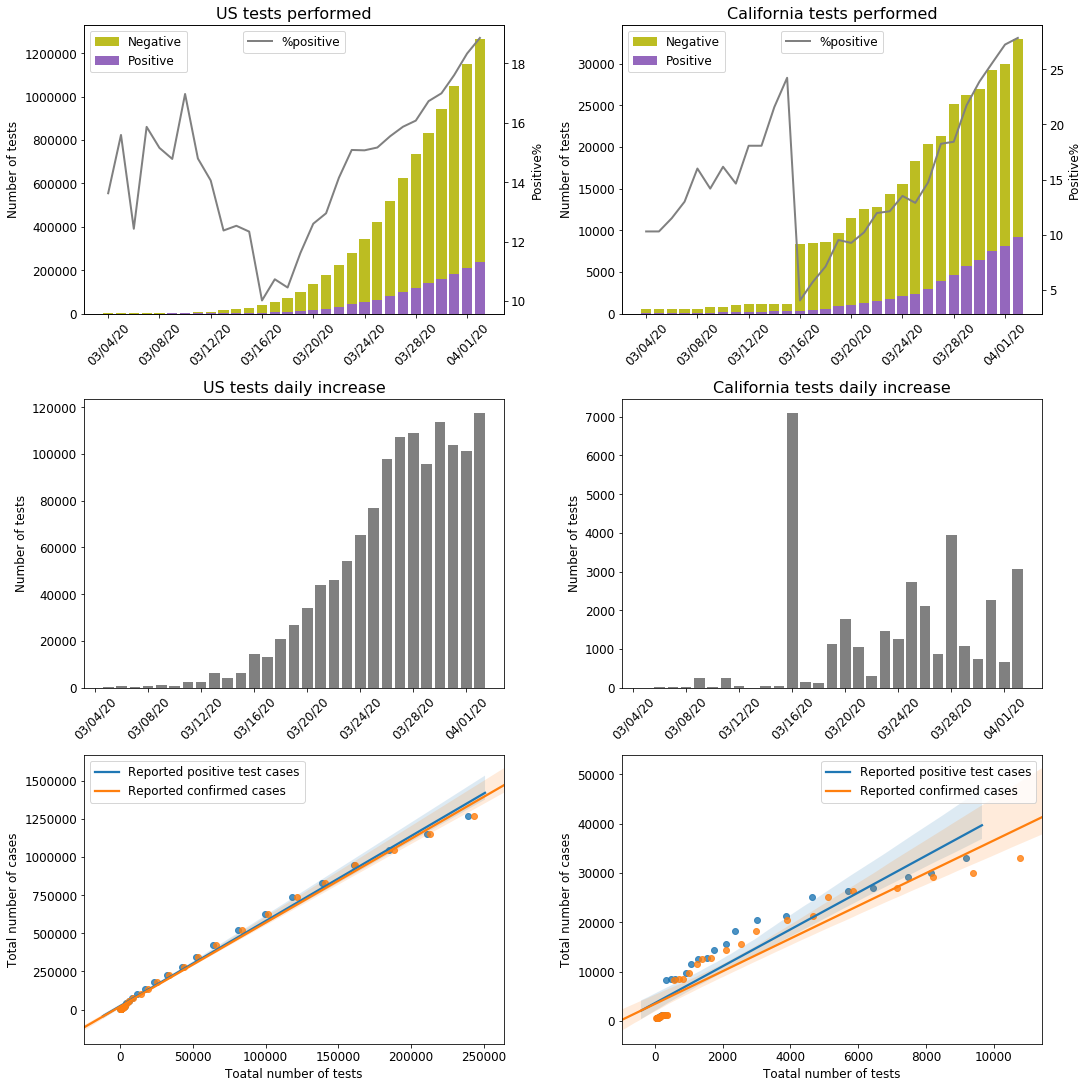

In [50]:
fig = plt.figure(figsize = (15, 15), constrained_layout=True, facecolor="1")
gs = fig.add_gridspec(3, 2)

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


for i in [0,1]:
    if(i == 0):
        plt_title = 'US'
        df_plot = df_US_main
        df_test = df_tests_us_daily
    else:
        plt_title = state
        df_plot = df_st
        df_test = df_tests_onestate_daily


    ### bar graph of tests
    ax = fig.add_subplot(gs[0, i])
    x = np.arange(len(df_test.index))
    ax1, ax2 = plot_tests_bar_and_percent(ax, x, 
                                          df_test.loc[:,['totalTestResults', 'positive']], 
                                          df_test.positive/df_test.totalTestResults*100,
                                          [cat_color['Negative'], cat_color['Positive']],
                                          'grey')
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn_tests))
    myLocator = mticker.MultipleLocator(4)
    ax.xaxis.set_major_locator(myLocator)
    ax.tick_params(axis = 'x', labelrotation = 45)
    ax.set_title(f'{plt_title} tests performed')
    
    
    ### daily increase
    ax = fig.add_subplot(gs[1, i])
    ax.bar(x, df_test.totalTestResultsIncrease, color = 'grey')
    ax.set_yscale('linear')
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn_tests))
    myLocator = mticker.MultipleLocator(4)
    ax.xaxis.set_major_locator(myLocator)
    ax.tick_params(axis = 'x', labelrotation = 45)
    ax.set_title(f'{plt_title} tests daily increase')
    ax.set_ylabel('Number of tests')
    
    ### tests vs. positive
    ax = fig.add_subplot(gs[2, i])
    sns.regplot(data = df_test, x = 'positive', y = 'totalTestResults')
    sns.regplot(x = df_plot.loc[df_test.index, 'Confirmed'], y = df_test.totalTestResults)
    ax.set_yscale('linear')
    ax.legend(['Reported positive test cases', 'Reported confirmed cases'])
    ax.set_xlabel('Toatal number of tests')
    ax.set_ylabel('Total number of cases')
#     ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn_tests))
#     myLocator = mticker.MultipleLocator(locator_param)
#     ax.xaxis.set_major_locator(myLocator)
#     ax.tick_params(axis = 'x', labelrotation = 45)
#     ax.set_title(f'{plt_title} tests daily increase')
#     ax.set_ylabel('Number of tests')


In [321]:
state = 'California'
future = 50

In [322]:
df_US = df_US_ori
df_st = df_US.groupby(['Province_State']).get_group(state)
df_US = reshape_dataframe(df_US.groupby('Category').sum().loc[:,time_str], time_str)
df_st = reshape_dataframe(df_st.groupby('Category').sum().loc[:,time_str], time_str)

In [323]:
def get_logistic_params(t, pt, **kwarg):
    popt_log = np.zeros((3,3))
    if('maxfev' in kwarg.keys()):
        maxfev = kwarg['maxfev']
    else:
        maxfev = 100000
    if('p0' in kwarg.keys()):
        popt_log[0,:], pcov_log = opt.curve_fit(logistic_growth,  t,  pt, p0 = kwarg['p0'], maxfev = maxfev)
        popt_log[1,:], pcov_log = opt.curve_fit(logistic_growth,  t[:-1],  pt[:-1], p0 = kwarg['p0'], maxfev = maxfev)
        popt_log[2,:], pcov_log = opt.curve_fit(logistic_growth,  t[:-2],  pt[:-2], p0 = kwarg['p0'], maxfev = maxfev)
    else:
        popt_log[0,:], pcov_log = opt.curve_fit(logistic_growth,  t,  pt, maxfev = maxfev)
        popt_log[1,:], pcov_log = opt.curve_fit(logistic_growth,  t[:-1],  pt[:-1], maxfev = maxfev)
        popt_log[2,:], pcov_log = opt.curve_fit(logistic_growth,  t[:-2],  pt[:-2], maxfev = maxfev)
    
    return popt_log

In [324]:
def plot_predictions(ax1, x0, y0, dy0, x1, ind_t0, popt_logs, color):
    ys = np.zeros((len(x1), 3))
    df = pd.DataFrame(columns = ['x', 'y'])
    for i in [0,1,2]:
        df_tmp = pd.DataFrame(columns = ['x', 'y'])
        df_tmp['x'] = x1 + ind_t0
        df_tmp['y'] = logistic_growth(x1, popt_logs[i,0], popt_logs[i,1], popt_logs[i,2])
        ys[:,i] = logistic_growth(x1, popt_logs[i,0], popt_logs[i,1], popt_logs[i,2])
        df = df.append(df_tmp)
    sns.set(style = 'ticks', rc={"lines.linewidth": 2})
    ax2 = ax1.twinx()
    for i in [0,1,2]:
        ax2.bar(x1[1:] + ind_t0, ys[1:,i] - ys[:-1, i], alpha = 0.2, color = 'grey')
    ax2.plot(x0, dy0, '--', color = color)
    ax1.plot(x0, y0, '.', color = color)
    sns.lineplot(x='x', y='y', data = df, ax = ax1, color = color)
    ax1.set_ylim(bottom = 0)
    ax2.set_ylim(bottom = 0)
    y_ends = ys[-1,:]
    ind_midds = np.zeros((1,3))
    for i in [0,1,2]:
        ind_midds[0,i] = list(ys[1:,i] - ys[:-1, i]).index(max(ys[1:,i] - ys[:-1, i]))
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Total')
    ax2.set_ylabel('Daily')
    ax1.legend(['Total Data', 'Logistic Fit'], loc = 'upper left')
    ax2.legend(['Daily Fitted', 'Daily Data'], loc = 'center left')
    return ax1, ax2, y_ends, ind_midds

US Confirmed: r=0.28, K = 301971~377705, peak increase at 03/25/20~03/26/20
US Deaths: r=0.26, K = 16920~30037, peak increase at +1~+4, CFR ~ 6.7%
California Confirmed: r=0.21, K = 23611~27117, peak increase at +0~+1
California Deaths: r=0.23, K = 354~598, peak increase at 03/23/20~+1, CFR ~ 1.8%


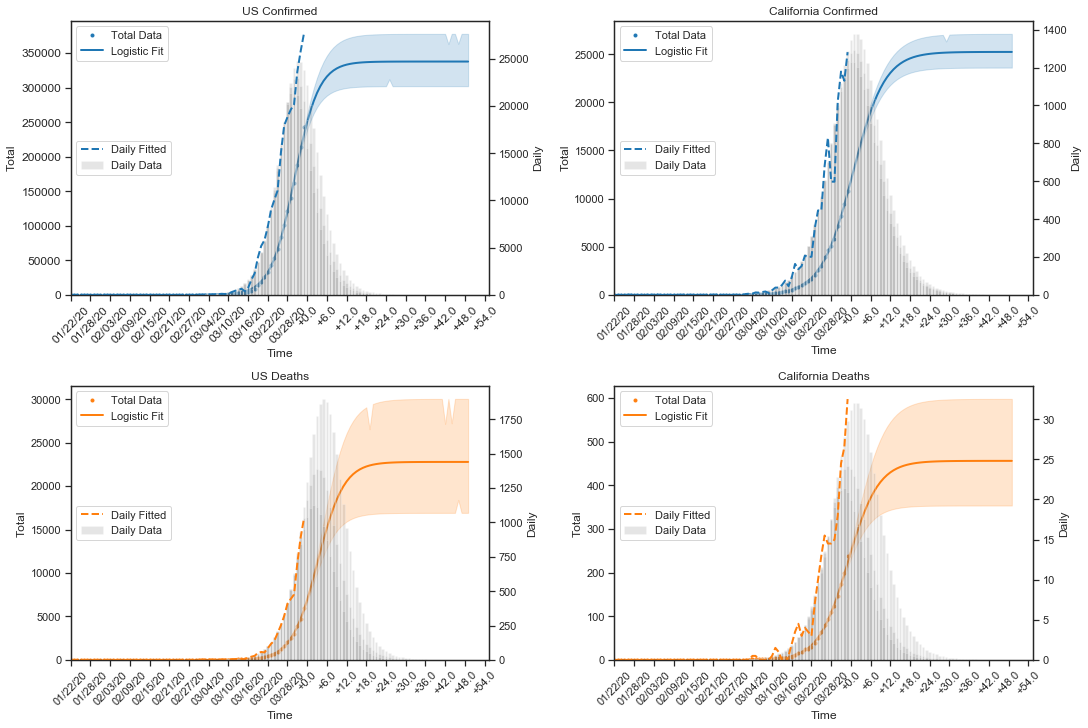

In [326]:
fig = plt.figure(figsize = (15, 10), constrained_layout=True, facecolor="1")
gs = fig.add_gridspec(2, 2)

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


x0 = np.arange(len(time_str))
end = np.zeros((2))

for i in [0,1]:
    for j in [0,1]:
        if(j == 0):
            cat = 'Confirmed'
        elif(j == 1):
            cat = 'Deaths'
        if(i == 0):
            df_plot = df_US
            title = 'US'
        elif(i == 1):
            df_plot = df_st
            title = state
        
        y0 = df_plot.loc[time_str, cat].to_numpy()
        dy0 = df_plot.loc[time_str, f'Daily_{cat}_smoothed']
        res = df_plot[df_plot.GF_rolling_thr != 0.0].bfill(axis=1).index[0]
        ind_t0 = max(0, time_str.index(res)-3)
        t = np.arange(len(time_str))[ind_t0:]- ind_t0
        pt = y0[ind_t0:]
        popt_logs = get_logistic_params(t, pt, p0 = (0.1, 100, 1))
        x1 = np.arange(len(t) + future)
        
        ax = fig.add_subplot(gs[j, i])
        if(future == 0):
            ax.plot(x, y1, '.', ms = 10, color = cat_color[cat])
            popt_exp, pcov_exp = opt.curve_fit(exp_growth,  t,  pt, p0 = (0.1, 10), maxfev = 100000)
            popt_log, pcov_log = opt.curve_fit(logistic_growth,  t,  pt, p0 = (0.1, 100, 1), maxfev=100000)
            ax.plot(x1 + ind_t0, exp_growth(x1, popt_exp[0], popt_exp[1]), '--', color = cat_color[cat])
            ax.plot(x1 + ind_t0, logistic_growth(x1, popt_log[0], popt_log[1], popt_log[2]), color = cat_color[cat])
        else:
            ax1, ax2, y_ends, ind_midds = plot_predictions(ax, x0, y0, dy0, x1, ind_t0, popt_logs, cat_color[cat])
        date_max = []
        for k in [0,1]:
            if(k == 0):
                ind = int(np.min(ind_midds))
            else:
                ind = int(np.max(ind_midds))
            if(ind < len(time_str)-ind_t0):
                date_max.append(time_str[ind-ind_t0])
            else:
                date_max.append(f'+{ind-(len(time_str)-ind_t0)}')
        if(j == 0):
            rate = np.mean(y_ends)
        else:
            rate = np.mean(y_ends)/rate * 100
        if(future == 0):
            ax.legend(['Confirmed', 
                        'Confirmed Exp Fit', 
                        'Confirmed Logistic Fit'])
            ax.set_title(f'{title} {cat}: r={popt_exp[0]:.2f}/{popt_log[0]:.2f}', fontsize = 18)
        else:
            ax.set_title(f'{title} {cat}')
            if(j == 0):
                pp = f'{title} {cat}: r={np.mean(popt_logs[:,0]):.2f}, K = {np.min(y_ends):.0f}~{np.max(y_ends):.0f}, peak increase at {date_max[0]}~{date_max[1]}'
            else:
                pp = f'{title} {cat}: r={np.mean(popt_logs[:,0]):.2f}, K = {np.min(y_ends):.0f}~{np.max(y_ends):.0f}, peak increase at {date_max[0]}~{date_max[1]}, CFR ~ {rate:.1f}%'
            print(pp)
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn_future))
        myLocator = mticker.MultipleLocator(6)
        ax.xaxis.set_major_locator(myLocator)
        ax.tick_params(axis = 'x', labelrotation = 45)
        ax.set_xlim(left = 0)

In [327]:
# state = 'California'
# ys = np.zeros((len(time_str), 4))
# x = np.arange(len(time_str))

# ys[:,0] = df_US.loc[time_str, 'Confirmed'].to_numpy()
# ys[:,1] = df_US_1p3a.loc[time_str, 'US'].to_numpy()
# ys[:,2] = df_CA.loc[time_str, 'Confirmed'].to_numpy()
# ys[:,3] = df_US_1p3a.loc[time_str, 'CA'].to_numpy()
# d1 = df_US.loc[time_str, 'Deaths'].to_numpy()
# d2 = df_CA.loc[time_str, 'Deaths'].to_numpy()

# res1 = df_US[df_US.GF_rolling_thr != 0.0].bfill(axis=1).index[0]
# res2 = df_CA[df_CA.GF_rolling_thr != 0.0].bfill(axis=1).index[0]

# ind1_t0 = max(0, time_str.index(res1)-3)
# ind2_t0 = max(0, time_str.index(res2)-3)

# t1 = np.arange(len(time_str))[ind1_t0:]- ind1_t0
# t2 = np.arange(len(time_str))[ind2_t0:]- ind2_t0

In [328]:
# future = 50
# yscale = 'linear'


# fig = plt.figure(figsize = (15, 10), constrained_layout=True, facecolor="1")
# gs = fig.add_gridspec(2, 2)

# ### US: confirmed
# ax1 = fig.add_subplot(gs[0, 0])

# x1 = np.arange((len(t1) + future))
# ax1.plot(x, ys[:,0], '.')
# ax1.plot(x, ys[:,1], '*')
# if(future == 0):
#     r_exp = 0
#     for i in [0,1]:
#         popt, pcov = opt.curve_fit(exp_growth, t1, ys[ind1_t0:,i], maxfev = 10000)
#         ax1.plot(x1 + ind1_t0, exp_growth(x1, popt[0], popt[1]), '--')
#         r_exp += popt[0]
#     r_exp = r_exp/2
# else:
#     r_exp = np.nan
# r_log = 0
# k_log = []
# for i in [0,1]:
#     popt, pcov = opt.curve_fit(logistic_growth, t1, ys[ind1_t0:,i], p0 = [0.1, 100, 1], maxfev = 10000)
#     ax1.plot(x1 + ind1_t0, logistic_growth(x1, popt[0], popt[1], popt[2]))
#     r_log += popt[0]
#     k_log.append(logistic_growth(x1, popt[0], popt[1], popt[2])[-1])
# r_log = r_log/2
# ax1.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn_future))
# myLocator = mticker.MultipleLocator(4)
# ax1.xaxis.set_major_locator(myLocator)
# ax1.set_yscale(yscale)
# # ax1.set_ylim([0, 3*10**11])
# ax1.tick_params(axis = 'x', labelrotation = 45)
# if(future == 0):
#     ax1.legend(['Confirmed_JHU', 
#                 'Confirmed_1p3a',
#                 'Exponential Fit: JHU',
#                 'Exponential Fit: 1p3a',
#                 'Logistic Fit: JHU', 
#                 'Logistic Fit: 1p3a'])
#     ax1.set_title(f'US Confirmed: growth rate {r_exp:.2f}/{r_log:.2f}')
# else:
#     ax1.legend(['Confirmed_JHU', 
#                 'Confirmed_1p3a',
#                 'Logistic Fit: JHU', 
#                 'Logistic Fit: 1p3a'])
#     ax1.set_title(f'US Confirmed: r={r_exp:.2f}/{r_log:.2f}, K={k_log[0]:.0f}/{k_log[1]:.0f}')
# total_us = k_log[0]

# ## State: Confirmed
# ax2 = fig.add_subplot(gs[0, 1])

# x1 = np.arange((len(t2) + future))
# ax2.plot(x, ys[:,2], '.')
# if(state == 'California'):
#     ax2.plot(x, ys[:,3], '*')
# if(future == 0):
#     r_exp = 0
#     if(state == 'California'):
#         for i in [2,3]:
#             popt, pcov = opt.curve_fit(exp_growth, t2, ys[ind2_t0:,i], maxfev = 10000)
#             ax2.plot(x1 + ind2_t0, exp_growth(x1, popt[0], popt[1]), '--')
#             r_exp += popt[0]
#         r_exp = r_exp/2
#     else:
#         i = 2
#         popt, pcov = opt.curve_fit(exp_growth, t2, ys[ind2_t0:,i], maxfev = 10000)
#         ax2.plot(x1 + ind2_t0, exp_growth(x1, popt[0], popt[1]))
#         r_exp = popt[0]
# else:
#         r_exp = np.nan
# r_log = 0
# k_log = []
# if(state == 'California'):
#     for i in [2,3]:
#         popt, pcov = opt.curve_fit(logistic_growth, t2, ys[ind2_t0:,i], p0 = [0.1, 100, 1], maxfev = 10000)
#         ax2.plot(x1 + ind2_t0, logistic_growth(x1, popt[0], popt[1], popt[2]), '--')
#         r_log += popt[0]
#         k_log.append(logistic_growth(x1, popt[0], popt[1], popt[2])[-1])
#     r_log = r_log/2
# else:
#     i = 2
#     popt, pcov = opt.curve_fit(logistic_growth, t2, ys[ind2_t0:,i], p0 = [0.1, 100, 1], maxfev = 10000)
#     ax2.plot(x1 + ind2_t0, logistic_growth(x1, popt[0], popt[1], popt[2]))
#     r_log = popt[0]
#     k_log = logistic_growth(x1, popt[0], popt[1], popt[2])[-1]
# ax2.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn_future))
# myLocator = mticker.MultipleLocator(4)
# ax2.xaxis.set_major_locator(myLocator)
# ax2.set_yscale(yscale)
# # ax.set_ylim([0, 60000])
# ax2.tick_params(axis = 'x', labelrotation = 45)
# if(future == 0):
#     if(state == 'California'):
#         ax2.legend(['Confirmed_JHU', 
#                     'Confirmed_1p3a',
#                     'Exponential Fit: JHU',
#                     'Exponential Fit: 1p3a',
#                     'Logistic Fit: JHU', 
#                     'Logistic Fit: 1p3a'])
#     else:
#         ax2.legend(['Confirmed_JHU', 
#                     'Exponential Fit: JHU',
#                     'Logistic Fit: JHU'])
#     ax2.set_title(f'{state} Confirmed: growth rate {r_exp:.2f}/{r_log:.2f}')
# else:
#     if(state == 'California'):
#         ax2.legend(['Confirmed_JHU',
#                     'Confirmed_1p3a'
#                     'Logistic Fit: JHU', 
#                     'Logistic Fit: 1p3a'])
#         ax2.set_title(f'{state} Confirmed: r={r_exp:.2f}/{r_log:.2f}, K={k_log[0]:.0f}/{k_log[1]:.0f}')
#         total_st = k_log[0]
#     else:
#         ax2.legend(['Confirmed_JHU',
#                     'Logistic Fit: JHU'])
#         ax2.set_title(f'{state} Confirmed: r={r_exp:.2f}/{r_log:.2f}, K={k_log:.0f}')
#         total_st = k_log


# ### US: deaths
# ax3 = fig.add_subplot(gs[1, 0])

# x1 = np.arange((len(t1) + future))
# ax3.plot(x, d1, '.')
# if(future == 0):
#     popt, pcov = opt.curve_fit(exp_growth, t1, d1[ind1_t0:], maxfev = 10000)
#     ax3.plot(x1 + ind1_t0, exp_growth(x1, popt[0], popt[1]))
# popt, pcov = opt.curve_fit(logistic_growth, t1, d1[ind1_t0:], p0 = [0.1, 100, 1], maxfev = 10000)
# ax3.plot(x1 + ind1_t0, logistic_growth(x1, popt[0], popt[1], popt[2]))
# k_log = logistic_growth(x1, popt[0], popt[1], popt[2])[-1]

# ax3.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn_future))
# myLocator = mticker.MultipleLocator(4)
# ax3.xaxis.set_major_locator(myLocator)
# ax3.set_yscale(yscale)
# ax3.tick_params(axis = 'x', labelrotation = 45)
# if(future == 0):
#     ax3.legend(['Deaths', 
#                 'Deaths Exponential Fit',
#                 'Deaths Logistic Fit'])
#     ax3.set_title(f'US Deaths: r = {popt[0]:.2f}')
# else:
#     ax3.legend(['Deaths', 
#                 'Deaths Logistic Fit'])
#     ax3.set_title(f'US Deaths: r = {popt[0]:.2f}, K={k_log:.0f} ({k_log/total_us*100:.1f}%)')

# ### State: deaths
# ax4 = fig.add_subplot(gs[1, 1])

# x1 = np.arange((len(t2) + future))
# ax4.plot(x, d2, '.')
# if(future == 0):
#     popt, pcov = opt.curve_fit(exp_growth, t2, d2[ind2_t0:], maxfev = 10000)
#     ax4.plot(x1 + ind2_t0, exp_growth(x1, popt[0], popt[1]))
# popt, pcov = opt.curve_fit(logistic_growth, t2, d2[ind2_t0:], p0 = [0.1, 100, 1], maxfev = 10000)
# ax4.plot(x1 + ind2_t0, logistic_growth(x1, popt[0], popt[1], popt[2]))
# k_log = logistic_growth(x1, popt[0], popt[1], popt[2])[-1]

# ax4.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn_future))
# myLocator = mticker.MultipleLocator(4)
# ax4.xaxis.set_major_locator(myLocator)
# ax4.set_yscale(yscale)
# ax4.tick_params(axis = 'x', labelrotation = 45)
# if(future == 0):
#     ax4.legend(['Deaths', 
#                 'Deaths Exponential Fit',
#                 'Deaths Logistic Fit'])
#     ax4.set_title(f'{state} Deaths: r = {popt[0]:.2f}')
# else:
#     ax4.legend(['Deaths', 
#                 'Deaths Logistic Fit'])
#     ax4.set_title(f'{state} Deaths: r = {popt[0]:.2f}, K={k_log:.0f} ({k_log/total_st*100:.1f}%)')


In [329]:
"""US by states"""

'US by states'

In [342]:
df_us_confirmed = df_US_ori.groupby('Category').get_group('Confirmed').groupby('Province_State').sum()[time_str]
# df_us_recovered = df_US_ori.groupby('Category').get_group('Recovered').groupby('Province_State').sum()[time_str]
df_us_deaths = df_US_ori.groupby('Category').get_group('Deaths').groupby('Province_State').sum()[time_str]
# df_us_active = df_us_confirmed - (df_us_recovered + df_us_deaths)
df_us_confirmed['New_Today'] = df_us_confirmed[time_str[-1]] - df_us_confirmed[time_str[-2]]

In [344]:
### confirmed cases

(-1, 10.5)

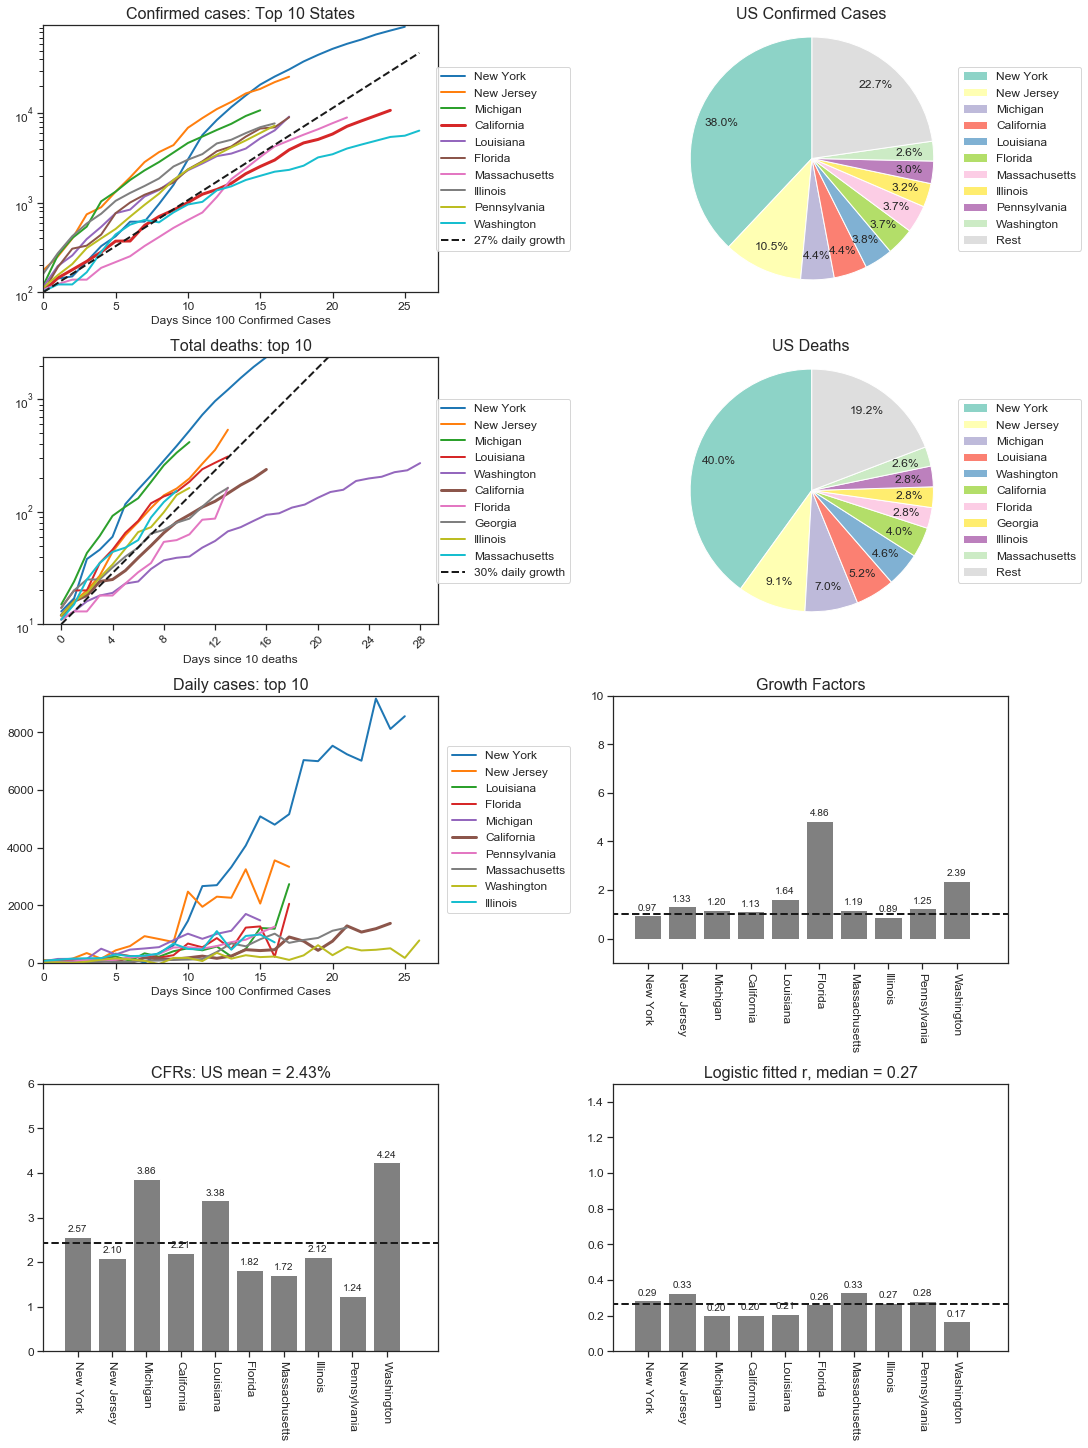

In [346]:
############ params ############
num_states = 10
colors_line = pl.cm.tab10(np.linspace(0,1,num_states))
colors_pie = pl.cm.Set3(np.linspace(0,1,11))
colors_pie[7,:] = colors_pie[10:]
colors_pie[10,:] = 0.85

############ figure ############
fig = plt.figure(figsize = (15, 20), constrained_layout=True, facecolor="1")
gs = fig.add_gridspec(4, 2)

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

ind_t0 = time_str.index(time_str[0])
time_plot = time_str[ind_t0:]


############ r for logistic growth fit ############
ax6 = fig.add_subplot(gs[3, 1])

df_us_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
states = list(df_us_confirmed.index[0:num_states])

x = np.arange(len(states))
x1 = np.arange(-2, len(x)+2)
y = []
for i in x:
    ctry = states[i]
    df_ctry = pd.DataFrame(df_us_confirmed.loc[ctry,time_plot])
    df_ctry = reshape_dataframe(df_ctry, time_plot)
    y.append(get_growth_rate(df_ctry, time_plot))
y = np.array(y)
r_median = np.median(y)

rects = ax6.bar(x, y, color = 'grey')
ax6.plot(x1, np.full(len(x1), np.median(y)), '--', color = 'k')
a = ax6.set_xticks(x)
a = ax6.set_xticklabels(states)
ax6.tick_params(axis = 'x', labelrotation = -90)
autolabel(rects, ax6, '{:.2f}')
# ymax = np.ceil(np.max(y)) + 0.5
ymax = 1.5
ax6.set_ylim([0, ymax])
ax6.set_xlim([-1, len(x) + 0.5])
a = ax6.set_title(f'Logistic fitted r, median = {np.median(y):.2f}')

############ total number normalized ############
ax2 = fig.add_subplot(gs[0, 0])

df_us_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
states = list(df_us_confirmed.index[0:num_states])
df_plot = df_us_confirmed.loc[states,time_plot]

max_x = 0
for i, ctr in enumerate(states):
    xi = len(df_plot.loc[ctr, df_plot.loc[ctr,:]>100].to_numpy())
    if(ctr == 'California'):
        ax2.plot(df_plot.loc[ctr, df_plot.loc[ctr,:]>100].to_numpy(), color = colors_line[i], linewidth = 3)
    else:
        ax2.plot(df_plot.loc[ctr, df_plot.loc[ctr,:]>100].to_numpy(), color = colors_line[i])
    if(xi > max_x):
        max_x = xi
x = np.arange(max_x)
ax2.plot(x, 100 * (1 + r_median) ** x, ls='--', color='k')
ax2.legend(states + [f'{r_median*100:.0f}% daily growth'],
           loc="center right", bbox_to_anchor = (1, 0, 0.35, 1))
ax2.set_ylim(bottom = 100)
ax2.set_xlim(left = 0)
ax2.set_yscale('log')
ax2.set_xlabel('Days Since 100 Confirmed Cases')
ax2.set_title(f'Confirmed cases: Top {num_states} States')


############ total number pie chart ############
ax = fig.add_subplot(gs[0,1])

df_us_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
percentages = []
labels = []
us_confirmed_total = np.sum(df_us_confirmed.loc[:,time_str[-1]])
for state in df_us_confirmed.index[0:num_states]:
    percentages.append(df_us_confirmed.loc[state, time_str[-1]]/us_confirmed_total*100)
    labels.append(state)
labels.append('Rest')
percentages.append(100-sum(percentages))

wedges, texts, autotexts = ax.pie(percentages, colors = colors_pie, 
                                  autopct = my_autopct, pctdistance=0.8,
                                  shadow=False, startangle=90,
                                  textprops = dict(size = 12))

ax.legend(wedges, labels, loc="center right", bbox_to_anchor = (1, 0, 0.2, 1))
ax.axis('equal')
ax.set_title("US Confirmed Cases")


############ daily cases normalized ############
ax3 = fig.add_subplot(gs[2, 0])

df_us_confirmed.sort_values(by = 'New_Today', inplace = True, ascending=False)
states = list(df_us_confirmed.index[0:num_states])

data_max = 0
for i, ctr in enumerate(states):
    yi = df_us_confirmed.loc[ctr,time_str].transpose().diff().loc[df_us_confirmed.loc[ctr,time_str]>100].to_numpy()
    xi = np.arange(len(yi))
    if(np.max(yi) > data_max):
        data_max = np.max(yi)
    if(ctr == 'California'):
        ax3.plot(xi, yi, color = colors_line[i], linewidth = 3)
    else:
        ax3.plot(xi, yi, color = colors_line[i])

ax3.legend(states, loc="center right", bbox_to_anchor = (1, 0, 0.35, 1))
ax3.set_yscale('linear')
a = ax3.set_title(f'Daily cases: top {num_states}')
ax3.set_ylim([0, data_max + 100])
ax3.set_xlim(left = 0)
ax3.set_xlabel('Days Since 100 Confirmed Cases')


############ total deaths ############
ax1 = fig.add_subplot(gs[1, 0])

df_us_deaths.sort_values(by = time_str[-1], inplace = True, ascending=False)
states = list(df_us_deaths.index[0:num_states])
df_plot = df_us_deaths.loc[states,time_str]

max_x = 0
for i, ctr in enumerate(states):
    xi = len(df_plot.loc[ctr, df_plot.loc[ctr,:]>10].to_numpy())
    if(ctr == 'California'):
        ax1.plot(df_plot.loc[ctr, df_plot.loc[ctr,:]>10].to_numpy(), color = colors_line[i], linewidth = 3)
    else:
        ax1.plot(df_plot.loc[ctr, df_plot.loc[ctr,:]>10].to_numpy(), color = colors_line[i])
    if(xi > max_x):
        max_x = xi
x = np.arange(max_x)
max_y = np.max(df_plot.loc[states,:].to_numpy().flatten())

ax1.plot(x, 10 * (1 + 0.3) ** x, ls='--', color='k')

ax1.legend(states + ['30% daily growth'],
          loc="center right", bbox_to_anchor = (1, 0, 0.35, 1))
ax1.set_yscale('log')
ax1.set_xlabel('Days since 10 deaths')
ax1.set_ylim([10, max_y + 10])
# plt.ylim(top = 2000)
ax1.set_title(f'Total deaths: top {num_states}')
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)


############ total deaths pie chart ############
ax = fig.add_subplot(gs[1,1])

df_us_deaths.sort_values(by = time_str[-1], inplace = True, ascending=False)
percentages = []
labels = []
us_deaths_total = np.sum(df_us_deaths.loc[:,time_str[-1]])
for state in df_us_deaths.index[0:num_states]:
    percentages.append(df_us_deaths.loc[state, time_str[-1]]/us_deaths_total*100)
    labels.append(state)
labels.append('Rest')
percentages.append(100-sum(percentages))

wedges, texts, autotexts = ax.pie(percentages, colors = colors_pie, 
                                  autopct = my_autopct, pctdistance=0.8,
                                  shadow=False, startangle=90,
                                  textprops = dict(size = 12))
ax.legend(wedges, labels, loc="center right", bbox_to_anchor = (1, 0, 0.2, 1))
ax.axis('equal')
ax.set_title("US Deaths")


############ fatality rate ############
ax5 = fig.add_subplot(gs[3, 0])

df_us_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
states = list(df_us_confirmed.index[0:num_states])

fatal_rates = df_us_deaths.loc[states,time_plot] / df_us_confirmed.loc[states,time_plot] * 100
x = np.arange(len(states))
x1 = np.arange(-2, len(x)+2)
fr_total = df_US.CFR[-1]

rects = ax5.bar(x, fatal_rates.loc[:,time_plot[-1]], color = 'grey')
ax5.plot(x1, np.full(len(x1), fr_total), '--', color = 'k')
a = ax5.set_xticks(x)
a = ax5.set_xticklabels(states)
ax5.tick_params(axis = 'x', labelrotation = -90)
autolabel(rects, ax5, '{:.2f}')
ymax = np.ceil(np.max(fatal_rates.loc[:,time_plot[-1]]) + 1)
ax5.set_ylim([0, ymax])
ax5.set_xlim([-1, len(x) + 0.5])
a = ax5.set_title(f'CFRs: US mean = {fr_total:.2f}%')


############ growth factors ############
ax4 = fig.add_subplot(gs[2, 1])

df_us_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
states = list(df_us_confirmed.index[0:num_states])

df_gf = df_us_confirmed.loc[states,time_plot].transpose()
for ctry in states:
    df_ctry = pd.DataFrame(df_us_confirmed.loc[ctry,time_plot])
    df_ctry = reshape_dataframe(df_ctry, time_plot)
    df_gf[ctry] = df_ctry.GF_rolling

x = np.arange(len(states))
x1 = np.arange(-2, len(x)+2)
y = df_gf.loc[time_plot[-1],:]

rects1 = ax4.bar(x, y, color = 'grey')
ax4.plot(x1, np.full(len(x1), 1), '--', color = 'k')
a = ax4.set_xticks(x)
a = ax4.set_xticklabels(states)
ax4.tick_params(axis = 'x', labelrotation = -90)
autolabel(rects1, ax4, '{:.2f}')
ymax = np.ceil(np.max(y)) + 5
ax4.set_ylim([-1, ymax])
a = ax4.set_title('Growth Factors')
ax4.set_xlim([-1, len(x) + 0.5])

In [348]:
n = 6
labels = []
percentages = np.zeros((len(time_str), n+1))
total_labels = []
label_lists = []
for x in range(len(time_str)):
    time = time_str[x]
    df_us_confirmed.sort_values(by = time, inplace = True, ascending=False)
    us_confirmed_total = np.sum(df_us_confirmed.loc[:,time])
    ll = []
    for i, state in enumerate(df_us_confirmed.index[0:n]):
        if(df_us_confirmed.loc[state, time] > 0):
            ll.append(state)
            label_lists.append(state)
        else:
            ll.append('')
        percentages[x,i] = (df_us_confirmed.loc[state, time]/us_confirmed_total*100)
    percentages[x,n] = (100-np.sum(percentages[x,:]))
    ll.append('Others')
    total_labels.append(ll)
label_lists = list(set(label_lists))

In [349]:
colors_bar = pl.cm.tab20(np.linspace(0,1,20))
colors_bar = np.concatenate((pl.cm.tab20(np.linspace(0,1,20))[:14],
                            pl.cm.tab20(np.linspace(0,1,20))[16:]), axis = 0)
color_codes = {}
for i, label in enumerate(label_lists):
    color_codes[label] = colors_bar[i]
label_lists.append('Others')
color_codes['Others'] = [0.85, 0.85, 0.85, 1]

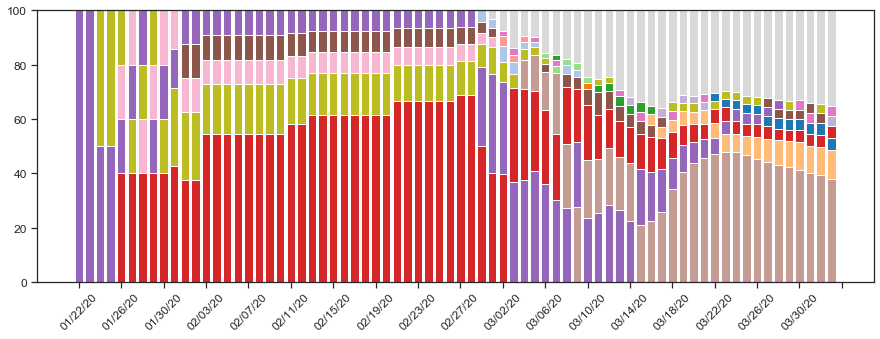

In [350]:
fix, ax = plt.subplots(1,1, figsize = (15,5))
for x in range(len(time_str)):
    plt.bar(x, percentages[x, 0], color = color_codes[total_labels[x][0]])
    for i, percent in enumerate(percentages[x, 1:]):
        if(total_labels[x][i+1]):
            plt.bar(x, percent, bottom = np.sum(percentages[x, 0:i+1]), color = color_codes[total_labels[x][i+1]])
ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax.xaxis.set_major_locator(myLocator)
ax.tick_params(axis = 'x', labelrotation = 45)

In [351]:
### tests

In [352]:
df_us_tests['rank_Percent_Pos'] = df_us_tests['Percent_Pos'].rank(ascending = False)
df_us_tests['rank_Test_Per_Million'] = df_us_tests['Test_Per_Million'].rank(ascending = False)
df_us_tests['rank_Pos_Per_Million'] = df_us_tests['Pos_Per_Million'].rank(ascending = False)
# df_us_tests.set_index('state', inplace = True)

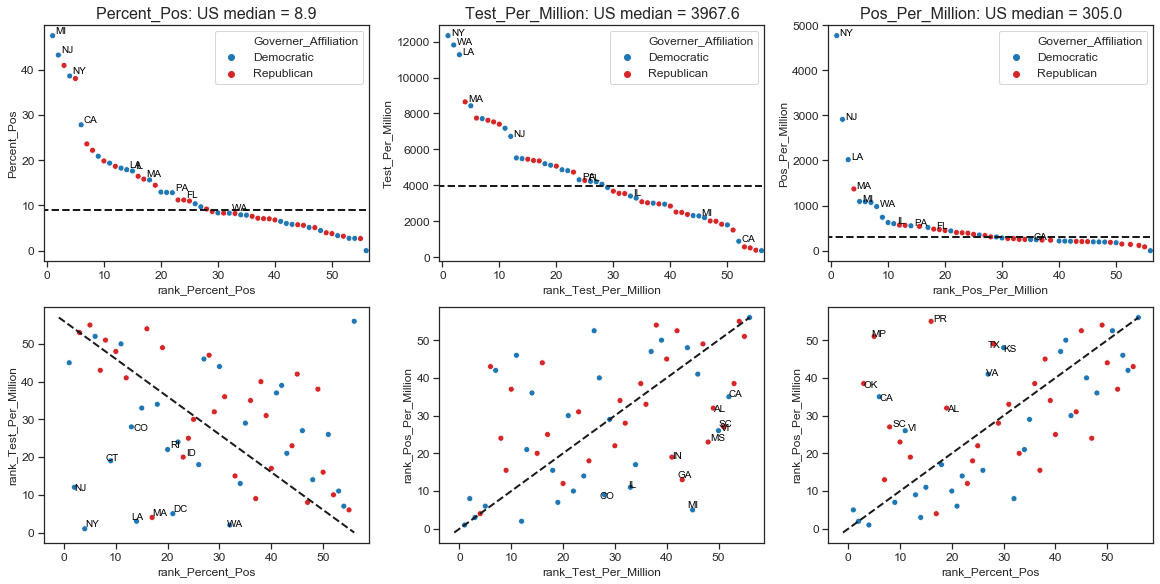

In [353]:
## figure ############
fig = plt.figure(figsize = (16, 8), constrained_layout=True, facecolor="1")
gs = fig.add_gridspec(2, 3)

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### value against rank
states = df_us_tests.sort_values(by = 'positive', inplace = False, ascending=False).index[:num_states]
cat_plots = ['Percent_Pos', 'Test_Per_Million', 'Pos_Per_Million']

for i in [0,1,2]:
    ax = fig.add_subplot(gs[0, i])
    
    cat_x = f'rank_{cat_plots[i]}'
    cat_y = cat_plots[i]
    df_plot = df_us_tests.sort_values(by = cat_y, inplace = False, ascending=False)
    x = np.arange(-1, len(df_plot.index)+1)
    p1 = sns.scatterplot(x = cat_x, y = cat_y, 
                         hue = 'Governer_Affiliation', palette = cat_color, 
                         data=df_plot, ax = ax)
    ax.plot(x, np.full(len(x), np.median(df_plot[cat_y])), '--', color = 'k')
    
    for st in states:
        pos_st = [df_us_tests.loc[st, cat_x], df_us_tests.loc[st, cat_y]]
        p1.text(pos_st[0]+0.5, pos_st[1] +0.5, st, 
                horizontalalignment='left', size='medium', 
                color='black',weight='normal')
    ax.set_xlim([-0.5, len(df_plot.index)+0.5])
    ax.set_title(f'{cat_y}: US median = {np.median(df_plot[cat_y]):.1f}')

### relationship between values
cat_pairs = [['rank_Percent_Pos', 'rank_Test_Per_Million'], 
             ['rank_Test_Per_Million', 'rank_Pos_Per_Million'], 
             ['rank_Percent_Pos', 'rank_Pos_Per_Million']]
for i in [0,1,2]:
    ax = fig.add_subplot(gs[1, i])
#     df_data = df_us_tests.groupby('Governer_Affiliation').get_group('Republican')
#     p1 = sns.regplot(x = cat_pairs[i][0], y = cat_pairs[i][1], data = df_data, fit_reg=True, color = cat_color['Republican'])
#     df_data = df_us_tests.groupby('Governer_Affiliation').get_group('Democratic')
#     p1 = sns.regplot(x = cat_pairs[i][0], y = cat_pairs[i][1], data = df_data, fit_reg=True, color = cat_color['Democratic'])
    p1 = sns.scatterplot(x = cat_pairs[i][0], y = cat_pairs[i][1], ax = ax, data = df_us_tests, 
                         hue = 'Governer_Affiliation', palette = cat_color, legend = False)
    df_fit = pd.DataFrame(columns = ['x', 'y', 'y_pred', 'res'])
    if(i == 0):
        x = np.arange(-1, len(df_us_tests.index) + 1)
        y = max(df_us_tests[cat_pairs[i][0]]) - x
        ax.plot(x, y, '--', color = 'k')
        df_fit['x'] = df_us_tests[cat_pairs[i][0]]
        df_fit['y'] = df_us_tests[cat_pairs[i][1]]
        df_fit['y_pred'] = max(df_fit['x']) - df_fit['x']
        df_fit['res'] = df_fit['y'] - df_fit['y_pred']

#         states = []
#         states += list(df_fit.sort_values(by = 'res').index[:5])
#         states += list(df_fit.sort_values(by = 'res').index[-5:])

#         for st in states:
#             pos_st = [df_us_tests.loc[st, cat_pairs[i][0]], df_us_tests.loc[st, cat_pairs[i][1]]]
#             p1.text(pos_st[0]+np.random.randint(-2, 2)/2, pos_st[1] +np.random.randint(-2, 2)/2, st, 
#                     horizontalalignment='left', size='medium', 
#                     color='black',weight='normal')
    else:
        x = np.arange(-1, len(df_us_tests.index) + 1)
        y = x
        ax.plot(x, y, '--', color = 'k')
        df_fit['x'] = df_us_tests[cat_pairs[i][0]]
        df_fit['y'] = df_us_tests[cat_pairs[i][1]]
        df_fit['y_pred'] = df_fit['x']
        df_fit['res'] = df_fit['y'] - df_fit['y_pred']
        
    states = []
    if(i == 0):
        states += list(df_fit.sort_values(by = 'res').index[:10])
    elif(i == 1):
        states += list(df_fit.sort_values(by = 'res').index[:10])
    elif(i == 2):
        states += list(df_fit.sort_values(by = 'res').index[-10:])

    for st in states:
        pos_st = [df_us_tests.loc[st, cat_pairs[i][0]], df_us_tests.loc[st, cat_pairs[i][1]]]
        p1.text(pos_st[0]+np.random.randint(-2, 2)/2, pos_st[1] +np.random.randint(-2, 2)/2, st, 
                horizontalalignment='left', size='medium', 
                color='black',weight='normal')

In [354]:
""" states with top 10 confirmed cases in testing world""" 

' states with top 10 confirmed cases in testing world'

Text(0.5, 1.0, 'Positive vs. Total Tests')

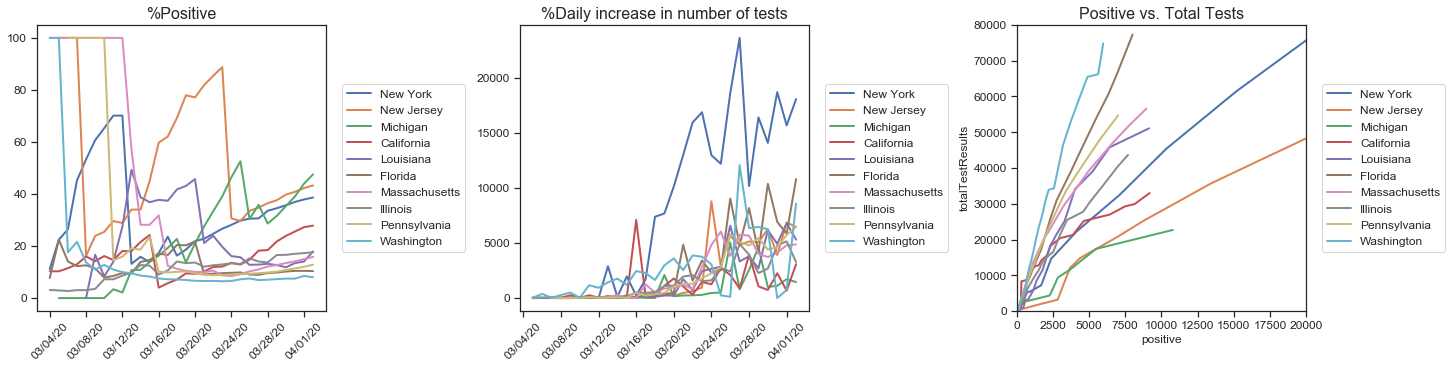

In [355]:

fig = plt.figure(figsize = (20, 5), constrained_layout=True, facecolor="1")
gs = fig.add_gridspec(1, 3)

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

df_us_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
states = list(df_us_confirmed.index[0:num_states])
### subplot1: %positive
ax = fig.add_subplot(gs[0, 0])
for state in states:
    st = usstate_abbs_mapping[state]
    df_test = df_tests_states_daily.groupby('state').get_group(st)
    df_test.sort_values(by = 'date', inplace = True, ascending=True)
    df_test.set_index('date', inplace = True)
    
    x = np.arange(len(df_test.index))
    ax.plot(df_test.positive/df_test.totalTestResults*100)

    
ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn_tests))
myLocator = mticker.MultipleLocator(4)
ax.xaxis.set_major_locator(myLocator)
ax.tick_params(axis = 'x', labelrotation = 45)

ax.legend(states, loc="center right", bbox_to_anchor = (1, 0, 0.5, 1))
ax.set_title('%Positive')

### subplot2: daily increase
ax = fig.add_subplot(gs[0, 1])

for state in states:
    st = usstate_abbs_mapping[state]
    df_test = df_tests_states_daily.groupby('state').get_group(st)
    df_test.sort_values(by = 'date', inplace = True, ascending=True)
    df_test.set_index('date', inplace = True)
    
    x = np.arange(len(df_test.index))
    ax.plot(df_test.totalTestResultsIncrease)

ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn_tests))
myLocator = mticker.MultipleLocator(4)
ax.xaxis.set_major_locator(myLocator)
ax.tick_params(axis = 'x', labelrotation = 45)

ax.legend(states, loc="center right", bbox_to_anchor = (1, 0, 0.5, 1))
ax.set_title('%Daily increase in number of tests')

    
### subplot3: total confirmed vs. total positive
ax = fig.add_subplot(gs[0, 2])

for state in states:
    st = usstate_abbs_mapping[state]
    df_test = df_tests_states_daily.groupby('state').get_group(st)
    df_test.sort_values(by = 'date', inplace = True, ascending=True)
    df_test.set_index('date', inplace = True)
    
    sns.lineplot(data = df_test, x = 'positive', y = 'totalTestResults')
    
#     ax.legend(['Reported positive test cases', 'Reported confirmed cases'])
#     ax.set_xlabel('Toatal number of tests')
#     ax.set_ylabel('Total number of cases')
ax.set_xlim([0, 20000])
ax.set_ylim([0, 80000])

ax.set_xscale('linear')
ax.set_yscale('linear')
ax.legend(states, loc="center right", bbox_to_anchor = (1, 0, 0.5, 1))
ax.set_title('Positive vs. Total Tests')


In [359]:
"""County status for top 5 states"""

'County status for top 5 states'

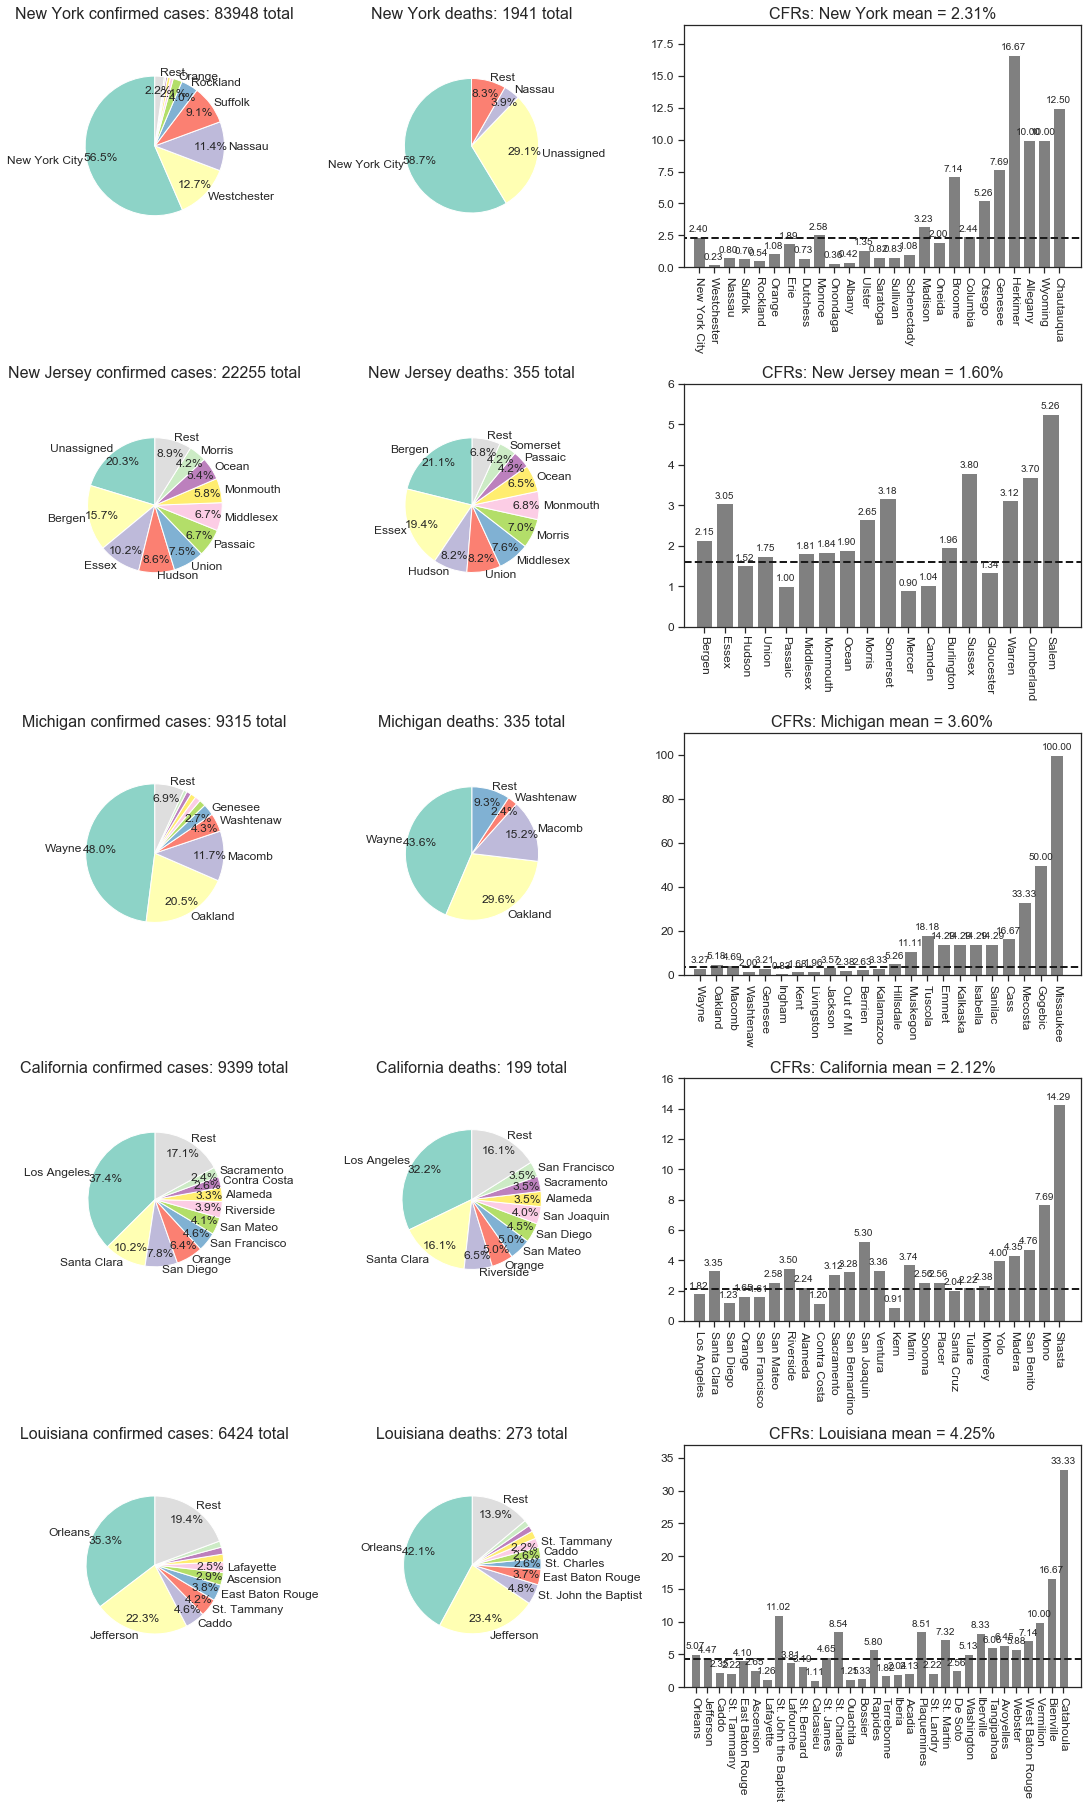

In [360]:
df_us_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
states = list(df_us_confirmed.index[0:5])

############ params ############
num_counties = 10

colors = pl.cm.Set3(np.linspace(0,1,11))
colors[7,:] = colors[10:]
colors[10,:] = 0.85

############ figure ############
fig = plt.figure(figsize = (15, 25), constrained_layout=True, facecolor="1")
gs = fig.add_gridspec(5, 7)

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


for i, state in enumerate(states):
    df_state = df_today.groupby('Country_Region').get_group('US').groupby('Province_State').get_group(state).loc[:,['Admin2'] + cdra_cols]
    df_state.set_index('Admin2', inplace = True)
    df_state = df_state.loc[(df_state!=0).any(axis=1)]
    df_state.loc[:,'CFR'] = df_state.Deaths/df_state.Confirmed*100
    df_state = df_state.replace([np.inf, -np.inf], 0)

    ############ total number pie chart ############
    ax = fig.add_subplot(gs[i,0:2])

    df_state.sort_values(by = 'Confirmed', inplace = True, ascending=False)
    percentages = []
    labels = []
    for county in list(df_state.index)[:num_counties]:
        percentages.append(df_state.loc[county, 'Confirmed']/np.sum(df_state.Confirmed)*100)
        if(percentages[-1] > 2):
            labels.append(county)
        else:
            labels.append('')
        if(sum(percentages) >= 99):
            break
    labels.append('Rest')
    percentages.append(100-sum(percentages))

    ax.pie(percentages, colors = colors,
           labels=labels, autopct = my_autopct, 
           pctdistance=0.8, labeldistance = 1.05,
           shadow=False, startangle=90,
           textprops = dict(size = 12))
    ax.axis('equal')
    ax.set_title(f"{state} confirmed cases: {np.sum(df_state.Confirmed):.0f} total")

    ############ total deaths pie chart ############
    ax = fig.add_subplot(gs[i,2:4])

    df_state.sort_values(by = 'Deaths', inplace = True, ascending=False)
    percentages = []
    labels = []
    for county in list(df_state.index)[:num_counties]:
        percentages.append(df_state.loc[county, 'Deaths']/np.sum(df_state.Deaths)*100)
        if(percentages[-1] > 2):
            labels.append(county)
        else:
            labels.append('')
        if(sum(percentages) >= 90):
            break
    labels.append('Rest')
    percentages.append(100-sum(percentages))

    ax.pie(percentages, colors = colors,
           labels=labels, autopct = my_autopct, 
           pctdistance=0.8, labeldistance = 1.05,
           shadow=False, startangle=90,
           textprops = dict(size = 12))
    ax.axis('equal')
    ax.set_title(f"{state} deaths: {np.sum(df_state.Deaths):.0f} total")

    ############ cfrs ############
    ax = fig.add_subplot(gs[i,4:])

    df_state.sort_values(by = 'Confirmed', inplace = True, ascending=False)
    y = df_state.CFR[df_state.CFR>0].to_numpy()
    x = np.arange(len(y))
    x1 = np.arange(-2, len(x)+2)
    fr_total = sum(df_state.Deaths)/sum(df_state.Confirmed)*100

    rects = ax.bar(x, y, color = 'grey')
    ax.plot(x1, np.full(len(x1), fr_total), '--', color = 'k')
    a = ax.set_xticks(x)
    a = ax.set_xticklabels(df_state[df_state.CFR>0].index)
    ax.tick_params(axis = 'x', labelrotation = -90)
    autolabel(rects, ax, '{:.2f}')
    ymax = np.ceil(np.max(y) + np.max(y)/10)
    ax.set_ylim([0, ymax])
    ax.set_xlim([-1, len(x) + 0.5])
    a = ax.set_title(f'CFRs: {state} mean = {fr_total:.2f}%')

In [361]:
"""bay area"""

'bay area'

In [362]:
bay_area_counties = ['Alameda', 'Contra Costa', 'Marin', 'Napa', 'San Francisco', 'San Mateo', 'Santa Clara', 'Solano', 'Sonoma']

df_state = df_today.groupby('Country_Region').get_group('US').groupby('Province_State').get_group('California').loc[:,['Admin2'] + cdra_cols]
df_state.set_index('Admin2', inplace = True)
df_bay_area = df_state.loc[bay_area_counties,:]
df_bay_area.loc[:,'CFR'] = df_bay_area.Deaths/df_bay_area.Confirmed*100
df_bay_area = df_bay_area.replace([np.inf, -np.inf], 0)

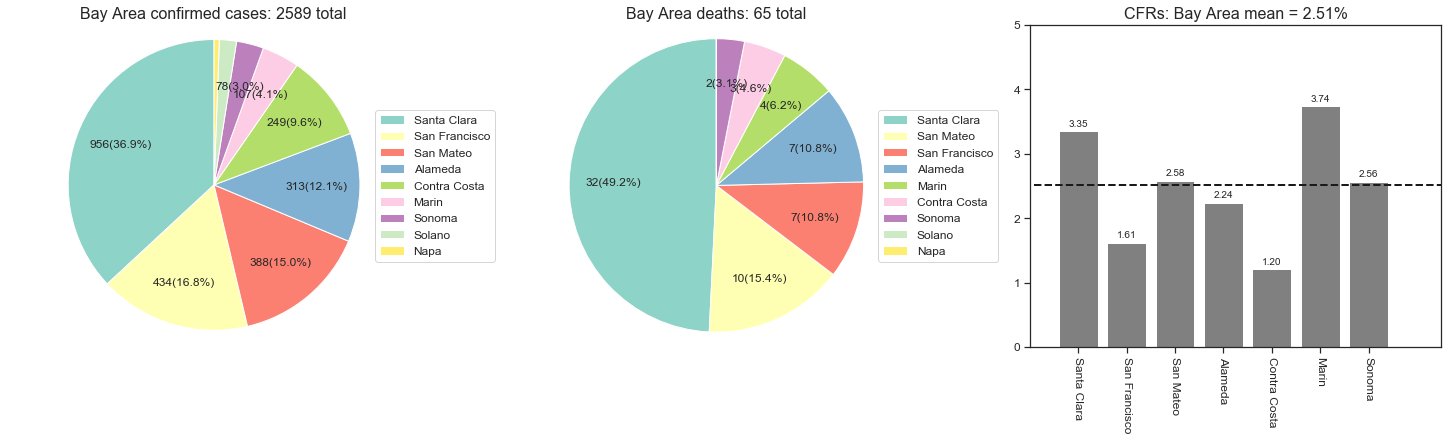

In [363]:
############ figure ############
fig = plt.figure(figsize = (20, 6), constrained_layout=True)
gs = fig.add_gridspec(1, 3)

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

############ total number pie chart ############
ax = fig.add_subplot(gs[0,0])

df_bay_area.sort_values(by = 'Confirmed', inplace = True, ascending=False)
percentages = []
labels = []
for county in df_bay_area.index:
    percentages.append(df_bay_area.loc[county, 'Confirmed']/np.sum(df_bay_area.Confirmed)*100)
    labels.append(county)
total = np.sum(df_bay_area.Confirmed)
colors = pl.cm.Set3(np.linspace(0,1,len(labels)))
wedges, texts, autotexts = ax.pie(percentages, colors = colors, 
                                  autopct = my_autopct_v2, pctdistance=0.7,
                                  shadow=False, startangle=90,
                                  textprops = dict(size = 12))

ax.legend(wedges, labels, loc="center right", bbox_to_anchor = (1, 0, 0.2, 1))
ax.axis('equal')
ax.set_title(f"Bay Area confirmed cases: {np.sum(df_bay_area.Confirmed):.0f} total")

############ total deaths pie chart ############
ax = fig.add_subplot(gs[0,1])

df_bay_area.sort_values(by = 'Deaths', inplace = True, ascending=False)
percentages = []
labels = []
for county in df_bay_area.index:
    percentages.append(df_bay_area.loc[county, 'Deaths']/np.sum(df_bay_area.Deaths)*100)
    labels.append(county)
total = np.sum(df_bay_area.Deaths)
colors = pl.cm.Set3(np.linspace(0,1,len(labels)))
wedges, texts, autotexts = ax.pie(percentages, colors = colors, 
                                  autopct = my_autopct_v2, pctdistance=0.7,
                                  shadow=False, startangle=90,
                                  textprops = dict(size = 12))

ax.legend(wedges, labels, loc="center right", bbox_to_anchor = (1, 0, 0.2, 1))
ax.axis('equal')
ax.set_title(f"Bay Area deaths: {np.sum(df_bay_area.Deaths):.0f} total")

############ cfrs ############
ax = fig.add_subplot(gs[0,2])

df_bay_area.sort_values(by = 'Confirmed', inplace = True, ascending=False)
y = df_bay_area.CFR[df_bay_area.CFR>0].to_numpy()
x = np.arange(len(y))
x1 = np.arange(-2, len(x)+2)
fr_total = sum(df_bay_area.Deaths)/sum(df_bay_area.Confirmed)*100

rects = ax.bar(x, y, color = 'grey')
ax.plot(x1, np.full(len(x1), fr_total), '--', color = 'k')
a = ax.set_xticks(x)
a = ax.set_xticklabels(df_bay_area[df_bay_area.CFR>0].index)
ax.tick_params(axis = 'x', labelrotation = -90)
autolabel(rects, ax, '{:.2f}')
ymax = np.ceil(np.max(y) + 1)
ax.set_ylim([0, ymax])
ax.set_xlim([-1, len(x) + 0.5])
a = ax.set_title(f'CFRs: Bay Area mean = {fr_total:.2f}%')

In [364]:
""" World by country """

' World by country '

In [367]:
df_confirmed = df_global.groupby('Category').get_group('Confirmed').groupby('Country_Region').sum()[time_str]
df_recovered = df_global.groupby('Category').get_group('Recovered').groupby('Country_Region').sum()[time_str]
df_deaths = df_global.groupby('Category').get_group('Deaths').groupby('Country_Region').sum()[time_str]
df_active = df_confirmed - (df_recovered + df_deaths)
df_confirmed['New_Today'] = df_confirmed[time_str[-1]] - df_confirmed[time_str[-2]]
df_deaths['New_Today'] = df_deaths[time_str[-1]] - df_deaths[time_str[-2]]

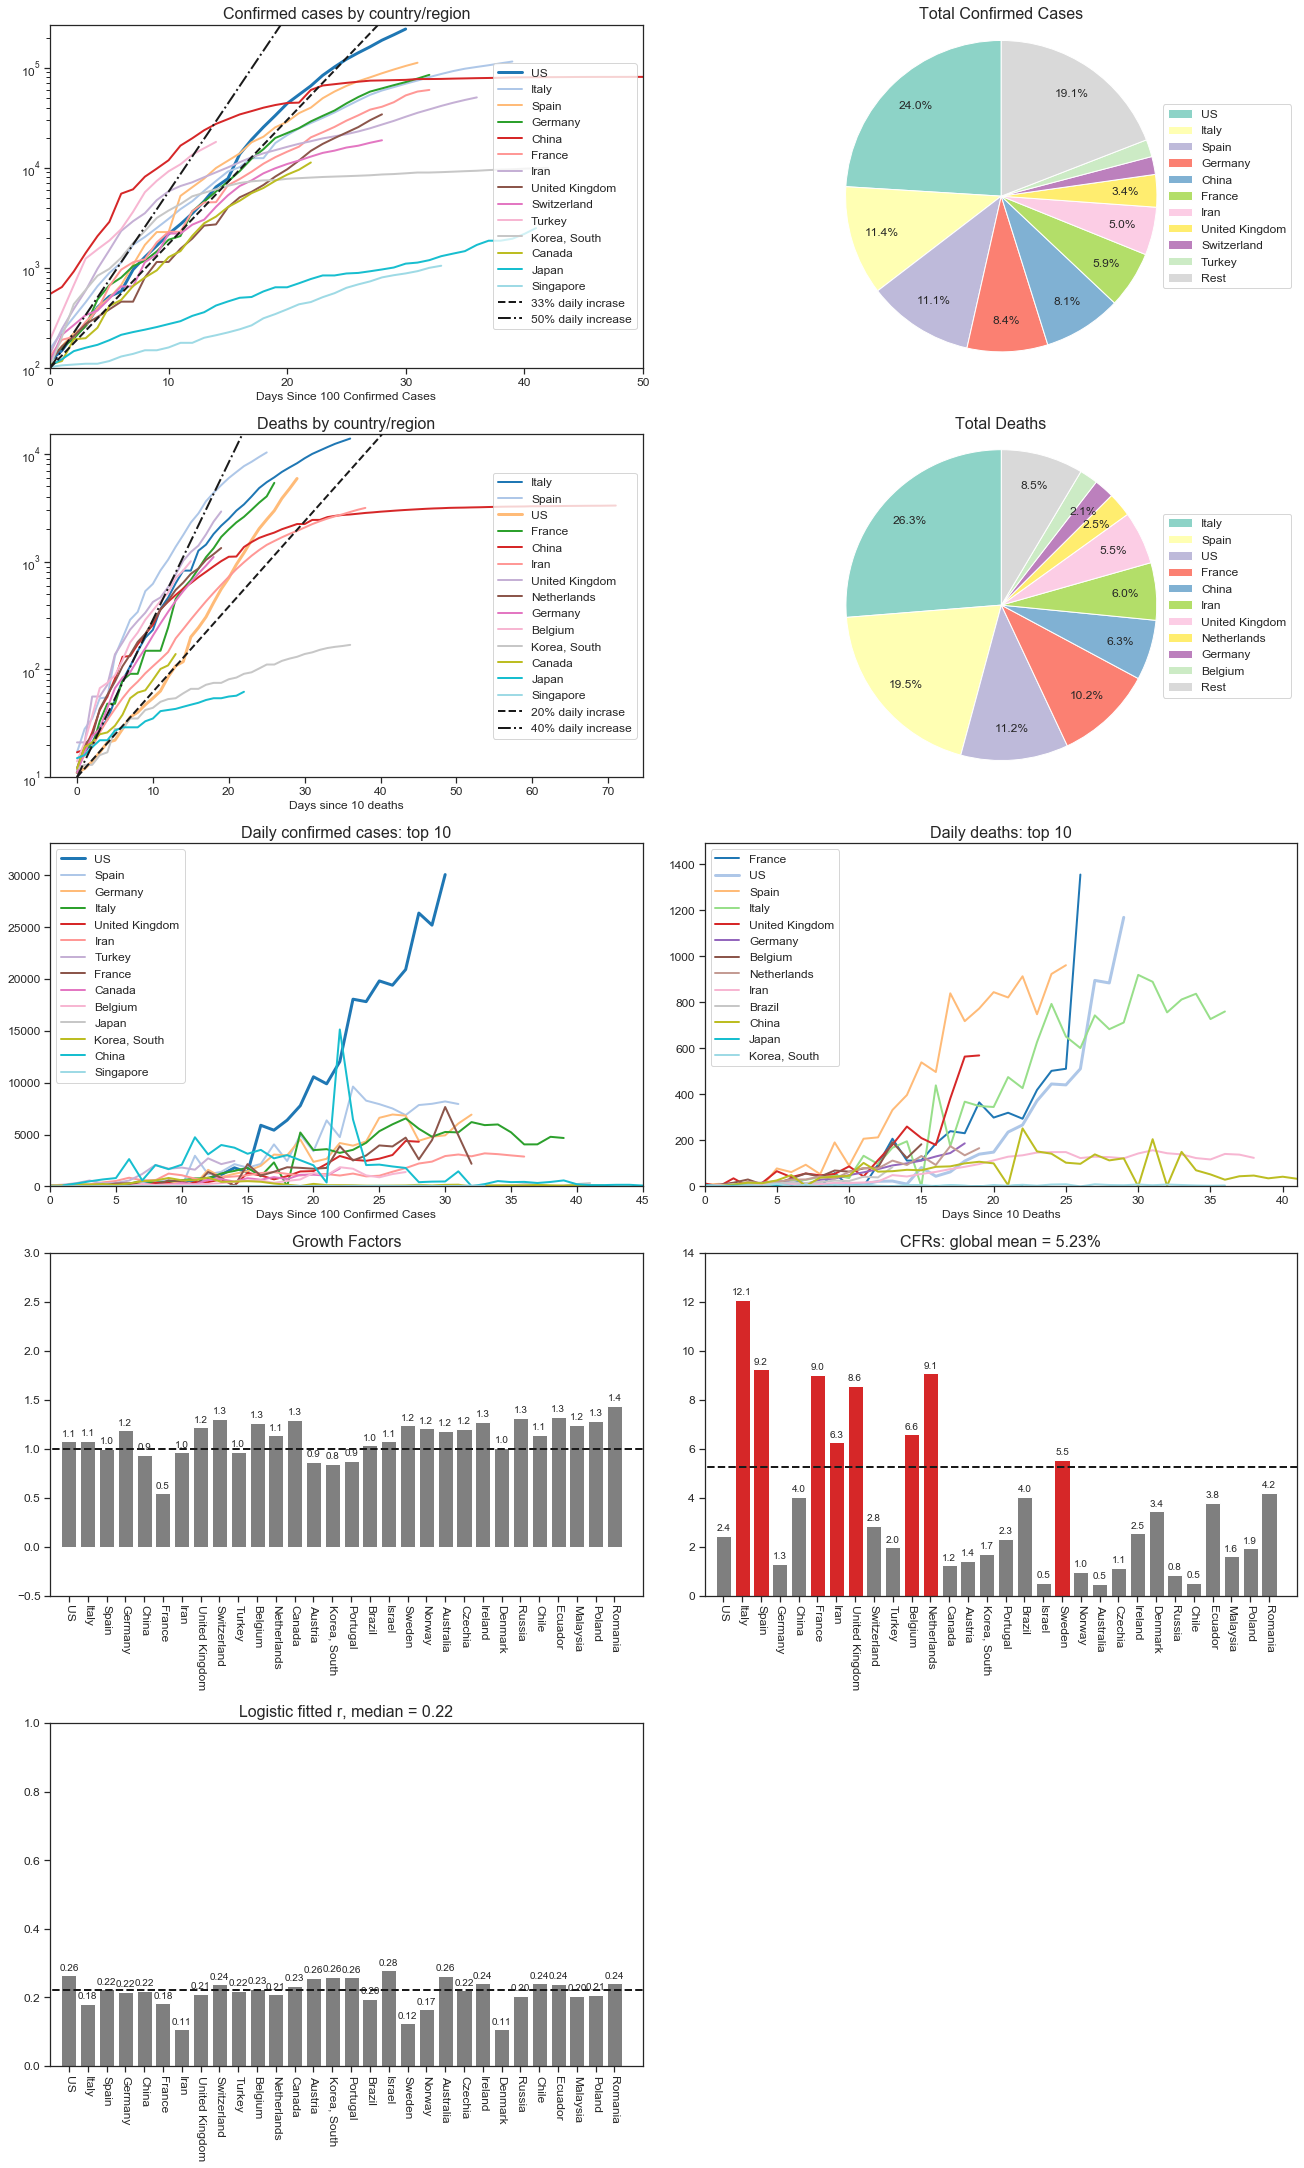

In [371]:
############ figure ############
fig = plt.figure(figsize = (18, 30), constrained_layout=True, facecolor="1")
gs = fig.add_gridspec(5, 2)

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


########## r for logistic growth fit ############
ax6 = fig.add_subplot(gs[4, 0])

df_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
# countries = [ctry for ctry in df_confirmed.index if df_confirmed.loc[ctry,time_str[-1]] >= 500]
countries = list(df_confirmed.index[0:30])

x = np.arange(len(countries))
x1 = np.arange(-2, len(x)+2)
# if not 'rs_global' in locals():
rs_global = []
for i in x:
    ctry = countries[i]
    df_ctry = pd.DataFrame(df_confirmed.loc[ctry,time_plot])
    df_ctry = reshape_dataframe(df_ctry, time_plot)
    rs_global.append(get_growth_rate(df_ctry, time_plot))
rs_global = np.array(rs_global)

rects = ax6.bar(x[rs_global<1], rs_global[rs_global<1], color = 'tab:grey')
ax6.bar(x[rs_global>=1], rs_global[rs_global>=1], color = 'tab:grey')
ax6.plot(x1, np.full(len(x1), np.median(rs_global)), '--', color = 'k')
a = ax6.set_xticks(x)
a = ax6.set_xticklabels(countries)
ax6.tick_params(axis = 'x', labelrotation = -90)
autolabel(rects, ax6, '{:.2f}')
ymax = np.ceil(np.max(y)) + 0.2
ax6.set_ylim([0, 1])
ax6.set_xlim([-1, len(x) + 0.5])
a = ax6.set_title(f'Logistic fitted r, median = {np.median(rs_global):.2f}')


############ total confirmed: normalize axis ############
ax2 = fig.add_subplot(gs[0, 0])

df_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
countries = list(df_confirmed.index[0:10])
countries += ['Korea, South', 'Canada', 'Japan', 'Singapore']

df_plot = df_confirmed.loc[countries,time_str]


colors = pl.cm.tab20(np.linspace(0,1,len(countries)))
max_x = 0
max_y = np.max(df_plot.to_numpy().flatten())
for i, ctr in enumerate(countries):
    xi = len(df_plot.loc[ctr, df_plot.loc[ctr,:]>100].to_numpy())
    if(xi > max_x):
        max_x = xi
    if(ctr == 'US'):
        ax2.plot(df_plot.loc[ctr, df_plot.loc[ctr,:]>100].to_numpy(), linewidth = 3, color = colors[i])
    else:
        ax2.plot(df_plot.loc[ctr, df_plot.loc[ctr,:]>100].to_numpy(), color = colors[i])

x = np.arange(max_x)
ax2.plot(x, 100 * (1+0.33) ** x, ls='--', color='k')
ax2.plot(x, 100 * (1+0.5) ** x, ls='-.', color='k')

ax2.set_ylim([100, max_y+max_y/10])
ax2.set_xlim([0, 50])
ax2.legend(countries + 
           [f'33% daily incrase',
           f'50% daily increase'], 
           loc="center right") #bbox_to_anchor = (1, 0, 0.35, 1)
ax2.set_yscale('log')
ax2.set_xlabel('Days Since 100 Confirmed Cases')
ax2.set_title('Confirmed cases by country/region')

############ total confirmed: pie chart ############
ax = fig.add_subplot(gs[0,1])

df_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
percentages = []
labels = []
df_confirmed_total = np.sum(df_confirmed.loc[:,time_str[-1]])
for ctry in df_confirmed.index[0:10]:
    percentages.append(df_confirmed.loc[ctry, time_str[-1]]/df_confirmed_total*100)
    labels.append(ctry)
labels.append('Rest')
percentages.append(100-sum(percentages))

colors = pl.cm.Set3(np.linspace(0,1,11))
colors[7,:] = colors[10,:]
colors[10,:] = [0.85, 0.85, 0.85, 1]
wedges, texts, autotexts = ax.pie(percentages, colors = colors, 
                                  autopct = my_autopct, pctdistance=0.8,
                                  shadow=False, startangle=90,
                                  textprops = dict(size = 12))
ax.legend(wedges, labels, loc="center right", bbox_to_anchor = (1, 0, 0, 1))
ax.axis('equal')
ax.set_title("Total Confirmed Cases")


############ total deaths: normalized axis ############
ax1 = fig.add_subplot(gs[1, 0])

df_deaths.sort_values(by = time_str[-1], inplace = True, ascending=False)
countries = list(df_deaths.index[0:10])
countries += ['Korea, South', 'Canada', 'Japan', 'Singapore']
df_plot = df_deaths.loc[countries,time_str]

colors = pl.cm.tab20(np.linspace(0,1,len(countries)))
max_x = 0
max_y = np.max(df_plot.to_numpy().flatten())
for i, ctr in enumerate(countries):
    xi = len(df_plot.loc[ctr, df_plot.loc[ctr,:]>10].to_numpy())
    if(xi > max_x):
        max_x = xi
    if(ctr == 'US'):
        ax1.plot(df_plot.loc[ctr,df_plot.loc[ctr,:]>10].to_numpy(), color = colors[i], linewidth = 3)
    else:
        ax1.plot(df_plot.loc[ctr,df_plot.loc[ctr,:]>10].to_numpy(), color = colors[i])

x = np.arange(max_x)
ax1.plot(x, 10 * (1+0.20) ** x, ls='--', color='k')
ax1.plot(x, 10 * (1+0.40) ** x, ls='-.', color='k')

ax1.set_ylim([10, max_y+max_y/10])

ax1.legend(countries + 
           [f'20% daily incrase',
            f'40% daily increase'],
           loc="center right") #bbox_to_anchor = (1, 0, 0.35, 1)
ax1.set_yscale('log')
ax1.set_xlabel('Days since 10 deaths')
ax1.set_title('Deaths by country/region')


############ total deaths: pie chart ############
ax = fig.add_subplot(gs[1,1])

df_deaths.sort_values(by = time_str[-1], inplace = True, ascending=False)
percentages = []
labels = []
df_deaths_total = np.sum(df_deaths.loc[:,time_str[-1]])
for ctry in df_deaths.index[0:10]:
    percentages.append(df_deaths.loc[ctry, time_str[-1]]/df_deaths_total*100)
    labels.append(ctry)
labels.append('Rest')
percentages.append(100-sum(percentages))

colors = pl.cm.Set3(np.linspace(0,1,11))
colors[7,:] = colors[10,:]
colors[10,:] = [0.85, 0.85, 0.85, 1]
wedges, texts, autotexts = ax.pie(percentages, colors = colors, 
                                  autopct = my_autopct, pctdistance=0.8,
                                  shadow=False, startangle=90,
                                  textprops = dict(size = 12))
ax.legend(wedges, labels, loc="center right", bbox_to_anchor = (1, 0, 0, 1))
ax.axis('equal')
ax.set_title("Total Deaths")


############ daily confirmed ############
ax3 = fig.add_subplot(gs[2, 0])

df_confirmed.sort_values(by = 'New_Today', inplace = True, ascending=False)
countries = list(set(list(df_confirmed.index[0:10]) + ['China', 'Korea, South', 'Japan', 'Singapore']))
df_plot = df_confirmed.loc[countries,:].sort_values(by = 'New_Today', ascending=False)
countries = list(df_plot.index)

colors = pl.cm.tab20(np.linspace(0,1,len(countries)))
data_max = 0
x_max = 0
for i, ctr in enumerate(countries):
    yi = df_confirmed.loc[ctr,time_str].transpose().diff().loc[df_confirmed.loc[ctr,time_str]>100].to_numpy()
    xi = np.arange(len(yi))
    if(np.max(yi) > data_max):
        data_max = np.max(yi)
    if(len(xi) > x_max and ctr != 'China'):
        x_max = len(xi)
    if(ctr == 'US'):
        ax3.plot(xi, yi, color = colors[i], linewidth = 3)
    else:
        ax3.plot(xi, yi, color = colors[i])

ax3.legend(countries, loc = 'upper left')
ax3.set_yscale('linear')
ax3.set_ylim([0, data_max + data_max/10])
ax3.set_xlim([0, x_max + 2])
a = ax3.set_title('Daily confirmed cases: top 10')
ax3.set_xlabel('Days Since 100 Confirmed Cases')

############ daily deaths ############
ax3 = fig.add_subplot(gs[2, 1])

df_deaths.sort_values(by = 'New_Today', inplace = True, ascending=False)
countries = list(set(list(df_deaths.index[0:10]) + ['China', 'Korea, South', 'Japan']))
df_plot = df_deaths.loc[countries,:].sort_values(by = 'New_Today', ascending=False)
countries = list(df_plot.index)

colors = pl.cm.tab20(np.linspace(0,1,len(countries)))
data_max = 0
x_max = 0
for i, ctr in enumerate(countries):
    yi = df_deaths.loc[ctr,time_str].transpose().diff().loc[df_deaths.loc[ctr,time_str]>10].to_numpy()
    xi = np.arange(len(yi))
    if(np.max(yi) > data_max):
        data_max = np.max(yi)
    if(len(xi) > x_max and ctr != 'China'):
        x_max = len(xi)
    if(ctr == 'US'):
        ax3.plot(xi, yi, color = colors[i], linewidth = 3)
    else:
        ax3.plot(xi, yi, color = colors[i])

ax3.legend(countries, loc = 'upper left')
ax3.set_yscale('linear')
ax3.set_ylim([0, data_max + data_max/10])
ax3.set_xlim([0, x_max + 2])
a = ax3.set_title('Daily deaths: top 10')
ax3.set_xlim(left = 0)
ax3.set_xlabel('Days Since 10 Deaths')


############ growth factors ############
ax4 = fig.add_subplot(gs[3, 0])

df_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
countries = list(df_confirmed.index[0:30])
# countries = [ctry for ctry in df_confirmed.index if df_confirmed.loc[ctry,time_str[-1]] >= 500]

df_gf = df_confirmed.loc[countries,time_str].transpose()
for ctry in countries:
    df_ctry = pd.DataFrame(df_confirmed.loc[ctry,time_str])
    df_ctry = reshape_dataframe(df_ctry, time_str)
    df_gf[ctry] = df_ctry.GF_rolling

x = np.arange(len(countries))
x1 = np.arange(-2, len(x)+2)
y = df_gf.loc[time_str[-1],:]

rects1 = ax4.bar(x, y, color = 'grey')
ax4.plot(x1, np.full(len(x1), 1), '--', color = 'k')
a = ax4.set_xticks(x)
a = ax4.set_xticklabels(countries)
ax4.tick_params(axis = 'x', labelrotation = -90)
autolabel(rects1, ax4, '{:.1f}')
ymax = np.ceil(np.max(y)) + 1
ax4.set_ylim([-0.5, ymax])
a = ax4.set_title('Growth Factors')
ax4.set_xlim([-1, len(x) + 0.5])


############ fatality rate ############
ax5 = fig.add_subplot(gs[3, 1])

df_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
countries = list(df_confirmed.index[0:30])
# countries = [ctry for ctry in df_confirmed.index if df_confirmed.loc[ctry,time_str[-1]] >= 500]
fatal_rates = df_deaths.loc[countries,time_str] / df_confirmed.loc[countries,time_str] * 100
x = np.arange(len(countries))
x1 = np.arange(-2, len(x)+2)
fr_total = df_total.CFR[-1]
y = fatal_rates.loc[:,time_str[-1]]

rects1 = ax5.bar(x[y<=fr_total], y[y<=fr_total], color = 'tab:grey')
rects2 = ax5.bar(x[y>fr_total], y[y>fr_total], color = 'tab:red')
ax5.plot(x1, np.full(len(x1), fr_total), '--', color = 'k')
a = ax5.set_xticks(x)
a = ax5.set_xticklabels(countries)
ax5.tick_params(axis = 'x', labelrotation = -90)
autolabel(rects1, ax5, '{:.1f}')
autolabel(rects2, ax5, '{:.1f}')
ymax = np.ceil(np.max(fatal_rates.loc[:,time_str[-1]]) + 1)
ax5.set_ylim([0, ymax])
ax5.set_xlim([-1, len(x) + 0.5])
a = ax5.set_title(f'CFRs: global mean = {fr_total:.2f}%')

In [372]:
"""World by country: cases vs. population"""

'World by country: cases vs. population'

In [373]:
df_ctry_today = pd.DataFrame(columns = ['Total_Confirmed', 'New_Confirmed', 'Total_Deaths', 'New_Deaths']+list(df_world_population.columns), 
                             index = df_confirmed.index)
df_ctry_today['Total_Confirmed'] = df_confirmed[today]
df_ctry_today['New_Confirmed'] = df_confirmed['New_Today']
indexis_intersect = intersection(list(df_world_population.index), list(df_confirmed.index))
df_ctry_today.loc[:,list(df_world_population.columns)] = df_world_population.loc[indexis_intersect,:]
df_ctry_today['Pos_per_Million'] = df_ctry_today.Total_Confirmed/(df_ctry_today.Population/MILLION)
df_ctry_today['Total_Deaths'] = df_deaths[today]
df_ctry_today['New_Deaths'] = df_deaths.loc[:,time_str[-1]] - df_deaths.loc[:,time_str[-2]]
df_ctry_today.dropna(axis = 0, how = 'any', inplace = True)
thr = 500
cat = 'Confirmed_Cat'
df_ctry_today.loc[df_ctry_today.Total_Confirmed>=thr, cat] = f'above_{thr}'
df_ctry_today.loc[df_ctry_today.Total_Confirmed<thr, cat] = f'below_{thr}'
thr = np.percentile(df_ctry_today.Population, 50)
cat = 'Population_Cat'
df_ctry_today.loc[df_ctry_today.Population>=thr, cat] = f'above_{thr/MILLION:.1f}M'
df_ctry_today.loc[df_ctry_today.Population<thr, cat] = f'below_{thr/MILLION:.1f}M'

key_countries = list(df_ctry_today.sort_values(by = 'Total_Confirmed', ascending = False).index[:10])
key_countries += ['Korea, South', 'Singapore', 'Japan', 'Canada', 'India']
key_countries = list(set(key_countries))

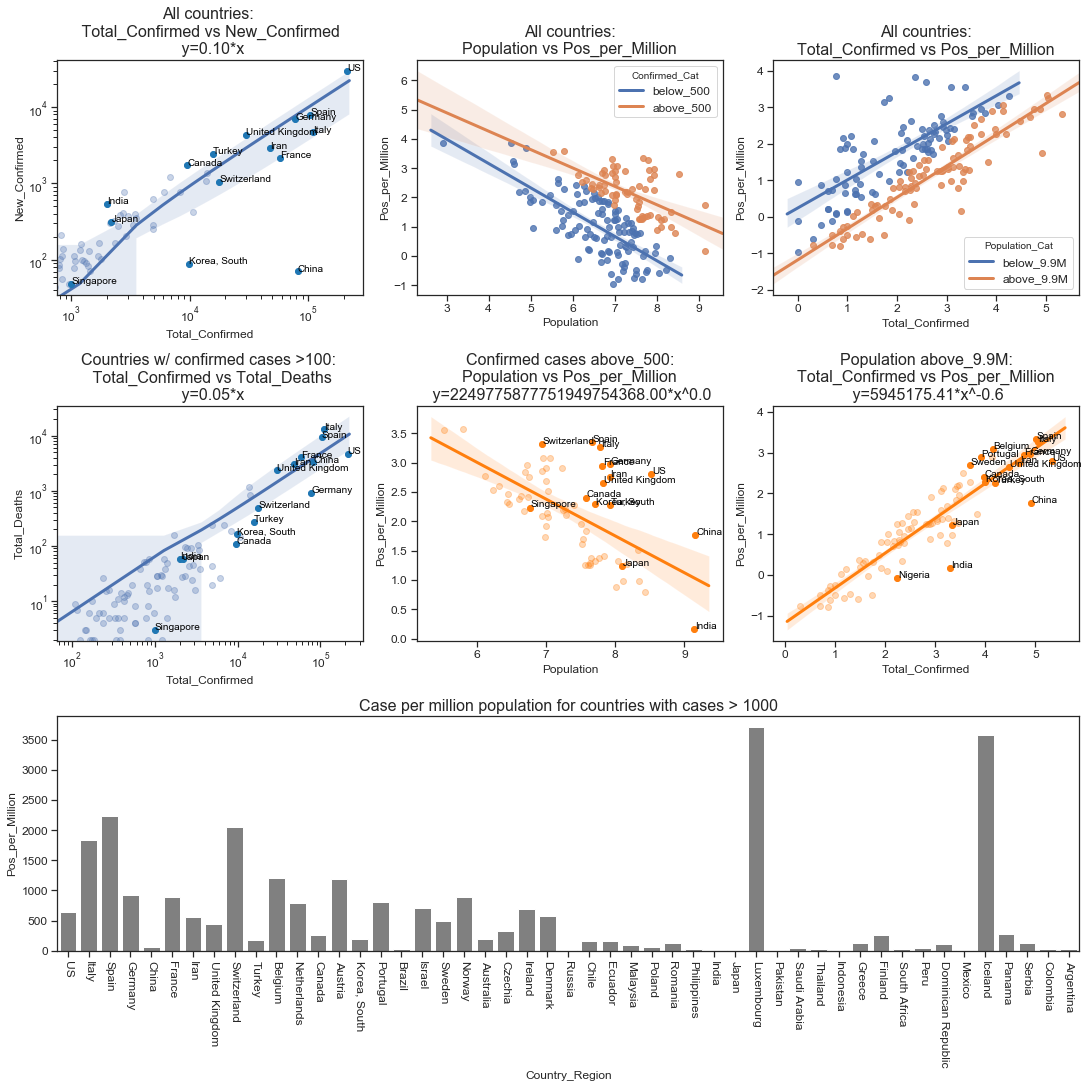

In [374]:
fig = plt.figure(figsize = (15, 15), constrained_layout=True, facecolor="1")
gs = fig.add_gridspec(3,3)


###
ax = fig.add_subplot(gs[0,0])
cat_x = 'Total_Confirmed'
cat_y = 'New_Confirmed'
df_fit = df_ctry_today[[cat_x, cat_y]]
df_fit = df_fit.replace([np.inf, -np.inf], np.nan).dropna(how="any")
p1 = sns.regplot(data = df_fit, 
                 x = cat_x, y = cat_y, ax = ax, scatter_kws={'alpha':0.3})
df_fit, reg = get_residuals(df_fit, False)
countries = get_annotation_list(df_fit, key_countries, True)
ax = add_country_annotations(ax, df_fit, countries, 'tab:blue')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_title(f'All countries: \n {cat_x} vs {cat_y} \n y={10**reg.intercept_:.2f}*x^{reg.coef_[0]:.1f}' )
ax.set_title(f'All countries: \n {cat_x} vs {cat_y} \n y={reg.coef_[0]:.2f}*x')

###
ax = fig.add_subplot(gs[1,0])
cat_x = 'Total_Confirmed'
cat_y = 'Total_Deaths'

df_fit = df_ctry_today.loc[df_ctry_today.Total_Confirmed>100, [cat_x, cat_y]]
df_fit = df_fit.replace([np.inf, -np.inf], np.nan).dropna(how="any")
p1 = sns.regplot(data = df_fit, 
                 x = cat_x, y = cat_y, ax = ax, scatter_kws={'alpha':0.3})
df_fit, reg = get_residuals(df_fit, True)
countries = get_annotation_list(df_fit, key_countries, True)
ax = add_country_annotations(ax, df_fit, countries, 'tab:blue')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title(f'Countries w/ confirmed cases >100: \n {cat_x} vs {cat_y}\n y={reg.coef_[0]:.2f}*x')

# ax.set_title(f'Countries w/ confirmed cases >100: \n {cat_x} vs {cat_y}\n y={10**reg.intercept_:.2f}*x^{reg.coef_[0]:.1f}')

###
cat_x = 'Population'
cat_y = 'Pos_per_Million'
cat = 'Confirmed_Cat'

df_fit = np.log10(df_ctry_today[[cat_x, cat_y]])
df_fit = df_fit.replace([np.inf, -np.inf], np.nan).dropna(how="any")
df_fit[cat] = df_ctry_today[cat]
cats = list(set(df_ctry_today[cat]))

for i in [0,1]:
    if(i == 0):
        ax = fig.add_subplot(gs[i,1])
        
        df_fit = np.log10(df_ctry_today[[cat_x, cat_y]])
        df_fit = df_fit.replace([np.inf, -np.inf], np.nan).dropna(how="any")
        df_fit[cat] = df_ctry_today[cat]
        for icat in cats:
            p1 = sns.regplot(data = df_fit[df_fit[cat] == icat], 
                        x = cat_x, y = cat_y, ax = ax)
        ax.legend(cats, title = cat)
        ax.set_title(f'All countries:\n{cat_x} vs {cat_y}')
    if(i == 1):
        ax = fig.add_subplot(gs[i,1])
        icat = [i for i in cats if 'above' in i][0]
        df_fit = np.log10(df_ctry_today.groupby(cat).get_group(icat)[[cat_x, cat_y]])
        df_fit = df_fit.replace([np.inf, -np.inf], np.nan).dropna(how="any")
        if(cats.index(icat) == 0):
            color = 'tab:blue'
        else:
            color = 'tab:orange'
        p1 = sns.regplot(data = df_fit, 
                        x = cat_x, y = cat_y, ax = ax, color = color, scatter_kws={'alpha':0.3})
        ax.set_title(f'Confirmed cases {icat}:\n{cat_x} vs {cat_y}\n y={10**reg.intercept_:.2f}*x^{reg.coef_[0]:.1f}')
        df_fit, reg = get_residuals(df_fit, True)
        ax = add_country_annotations(ax, df_fit, key_countries, color)

        
##
cat_x = 'Total_Confirmed'
cat_y = 'Pos_per_Million'
cat = 'Population_Cat'

df_fit = np.log10(df_ctry_today[[cat_x, cat_y]])
df_fit = df_fit.replace([np.inf, -np.inf], np.nan).dropna(how="any")
df_fit[cat] = df_ctry_today[cat]
cats = list(set(df_ctry_today[cat]))

for i in [0,1]:
    if(i == 0):
        ax = fig.add_subplot(gs[i,2])
        
        df_fit = np.log10(df_ctry_today[[cat_x, cat_y]])
        df_fit = df_fit.replace([np.inf, -np.inf], np.nan).dropna(how="any")
        df_fit[cat] = df_ctry_today[cat]
        for icat in cats:
            p1 = sns.regplot(data = df_fit[df_fit[cat] == icat], 
                        x = cat_x, y = cat_y, ax = ax)
        ax.legend(cats, title = cat)
        ax.set_title(f'All countries:\n{cat_x} vs {cat_y}')
    if(i == 1):
        ax = fig.add_subplot(gs[i,2])
        icat = [i for i in cats if 'above' in i][0]
        df_fit = np.log10(df_ctry_today.groupby(cat).get_group(icat)[[cat_x, cat_y]])
        df_fit = df_fit.replace([np.inf, -np.inf], np.nan).dropna(how="any")
        
        if(cats.index(icat) == 0):
            color = 'tab:blue'
        else:
            color = 'tab:orange'

        p1 = sns.regplot(data = df_fit, 
                        x = cat_x, y = cat_y, ax = ax, color = color, scatter_kws={'alpha':0.3})
        ax.set_title(f'Population {icat}:\n{cat_x} vs {cat_y}\n y={10**reg.intercept_:.2f}*x^{reg.coef_[0]:.1f}')
        df_fit, reg = get_residuals(df_fit, True)
        countries = get_annotation_list(df_fit, key_countries, True)
        ax = add_country_annotations(ax, df_fit, countries, color)

###
ax = fig.add_subplot(gs[2,:])
countries = df_ctry_today[df_ctry_today.Total_Confirmed>1000].index
sns.barplot(data = df_ctry_today.loc[countries,'Pos_per_Million'].reset_index(), 
            x = 'Country_Region', y = 'Pos_per_Million', color = 'grey')
_ = plt.xticks(rotation=-90)
_ = plt.title('Case per million population for countries with cases > 1000')



In [375]:
"""World by continent"""

'World by continent'

In [376]:
df_continents = df_ctry_today.groupby('Grouping1').sum()

In [377]:
def my_autopct_v3(pct):
    return f'{pct*total/(100*MILLION):.2f}M({pct:1.1f}%)' if pct > 2 else ''

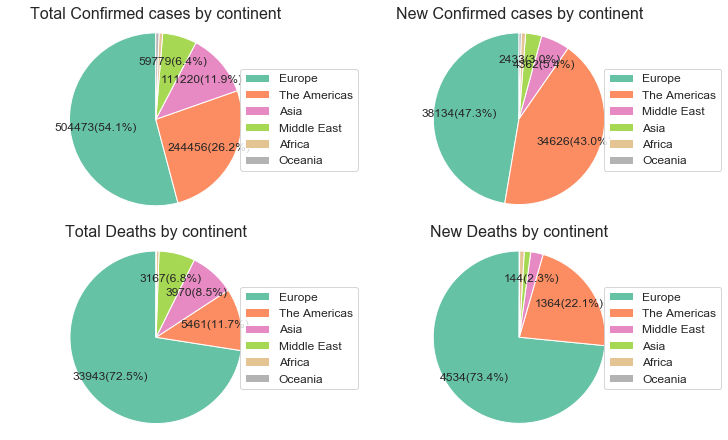

In [378]:
fig = plt.figure(figsize = (10, 6), constrained_layout=True, facecolor="1")
gs = fig.add_gridspec(2,2)

for i in [0,1]:
    for j in [0,1]:
        if(i == 0):
            cat = 'Total'
            plt_title = 'Total'
        else:
            cat = 'New'
            plt_title = 'New'
        if(j == 0):
            cat += '_Confirmed'
            plt_title += ' Confirmed cases by continent'
            df_plot = df_continents[cat]
        else:
            cat += '_Deaths'
            plt_title += ' Deaths by continent'
            df_plot = df_continents[cat]
        ax = fig.add_subplot(gs[j,i])

        df_plot = df_plot.sort_values(ascending=False)
        percentages = []
        labels = []
        total = np.sum(df_continents[cat])
        for cont in df_plot.index:
            percentages.append(df_plot[cont]/total*100)
            labels.append(cont)
        colors = pl.cm.Set2(np.linspace(0,1,len(percentages)))
        wedges, texts, autotexts = ax.pie(percentages, colors = colors, 
                                          autopct = my_autopct_v2, pctdistance=0.7,
                                          shadow=False, startangle=90,
                                          textprops = dict(size = 12))
        ax.legend(wedges, labels, loc="center right", 
                  bbox_to_anchor = (1, 0, 0.2, 1))
        ax.axis('equal')
        ax.set_title(plt_title)


In [379]:
""" China """

' China '

In [382]:
df_mc_confirmed = df_global.groupby('Country_Region').get_group('China').groupby('Category').get_group('Confirmed').groupby('Province_State').sum()[time_str]
df_mc_deaths = df_global.groupby('Country_Region').get_group('China').groupby('Category').get_group('Deaths').groupby('Province_State').sum()[time_str]

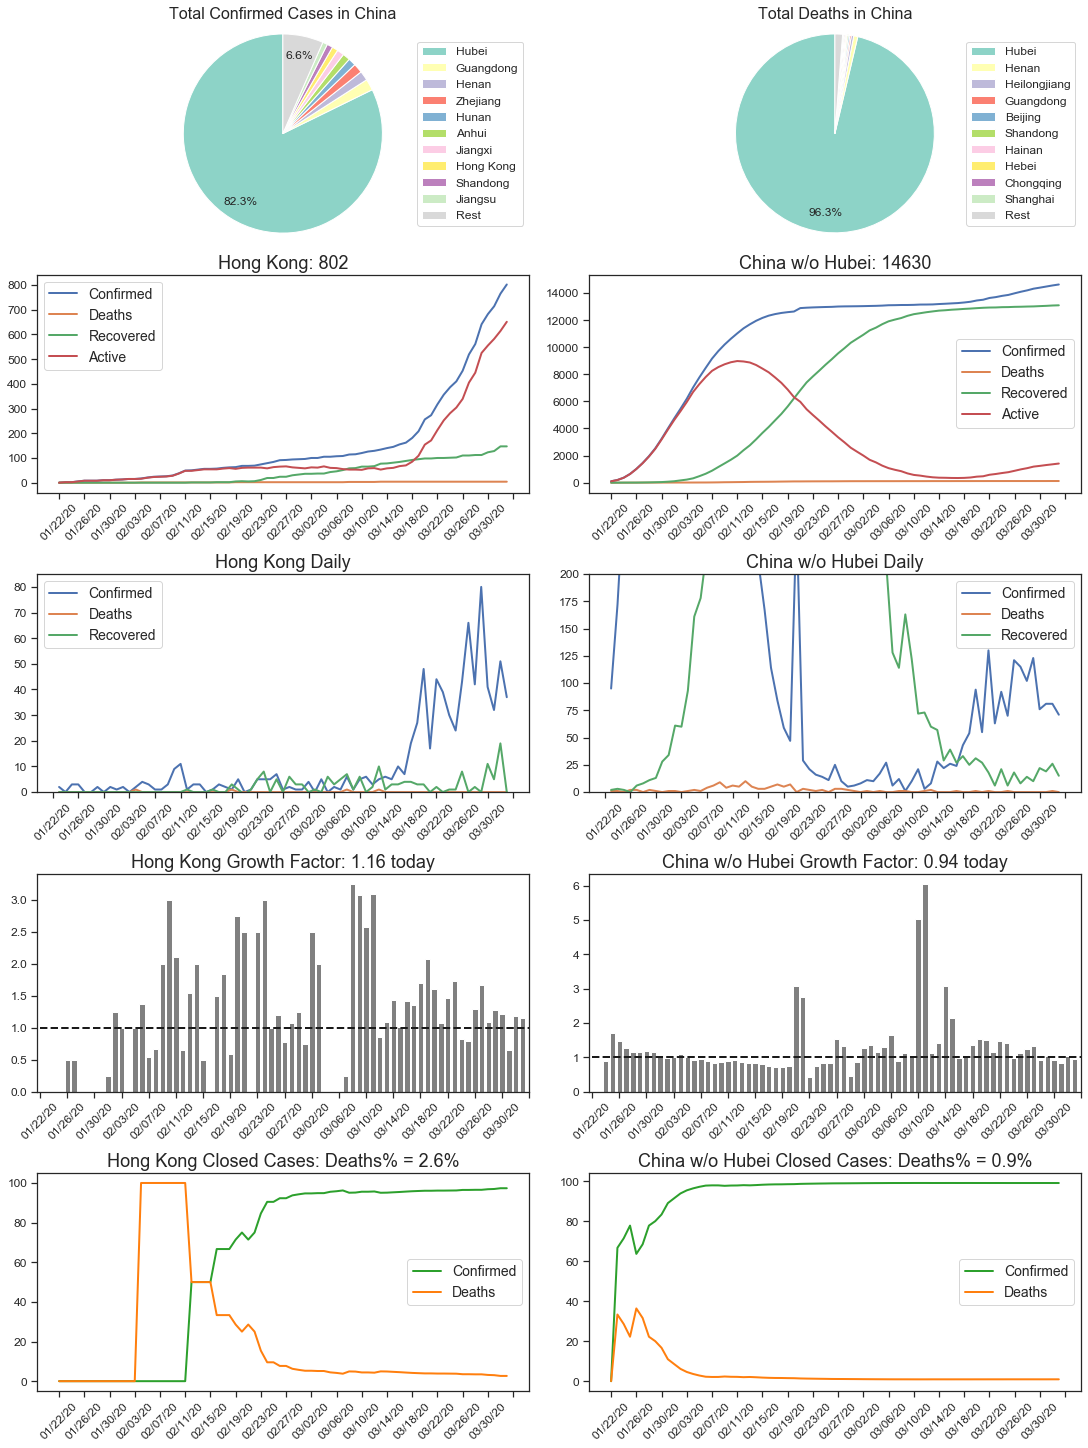

In [384]:
prov = 'Hong Kong'
df_prov = df_global.groupby('Country_Region').get_group('China').groupby('Province_State').get_group(prov).groupby('Category').sum().loc[:,time_str]
df_prov = reshape_dataframe(df_prov, time_str)

fig = plt.figure(figsize = (15, 20), constrained_layout=True, facecolor="1")
gs = fig.add_gridspec(5,2)

############ China confirmed pie chart
ax = fig.add_subplot(gs[0,0])

df_mc_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
percentages = []
labels = []
df_mc_confirmed_total = np.sum(df_mc_confirmed.loc[:,time_str[-1]])
for iprov in df_mc_confirmed.index[0:10]:
    percentages.append(df_mc_confirmed.loc[iprov, time_str[-1]]/df_mc_confirmed_total*100)
    labels.append(iprov)
labels.append('Rest')
percentages.append(100-sum(percentages))

colors = pl.cm.Set3(np.linspace(0,1,11))
colors[7,:] = colors[10,:]
colors[10,:] = [0.85, 0.85, 0.85, 1]

wedges, texts, autotexts = ax.pie(percentages, colors = colors, 
                                  autopct = my_autopct, pctdistance=0.8,
                                  shadow=False, startangle=90,
                                  textprops = dict(size = 12))
ax.legend(wedges, labels, loc="center right", bbox_to_anchor = (1, 0, 0, 1))
ax.axis('equal')
ax.set_title("Total Confirmed Cases in China")
              
############ China deaths pie chart
ax = fig.add_subplot(gs[0,1])

df_mc_deaths.sort_values(by = time_str[-1], inplace = True, ascending=False)
percentages = []
labels = []
df_mc_deaths_total = np.sum(df_mc_deaths.loc[:,time_str[-1]])
for iprov in df_mc_deaths.index[0:10]:
    percentages.append(df_mc_deaths.loc[iprov, time_str[-1]]/df_mc_deaths_total*100)
    labels.append(iprov)
labels.append('Rest')
percentages.append(100-sum(percentages))

colors = pl.cm.Set3(np.linspace(0,1,11))
colors[7,:] = colors[10,:]
colors[10,:] = [0.85, 0.85, 0.85, 1]

wedges, texts, autotexts = ax.pie(percentages, colors = colors, 
                                  autopct = my_autopct, pctdistance=0.8,
                                  shadow=False, startangle=90,
                                  textprops = dict(size = 12))
ax.legend(wedges, labels, loc="center right", bbox_to_anchor = (1, 0, 0, 1))
ax.axis('equal')
ax.set_title("Total Deaths in China")


############ prov total confirmed/death/recovered ############
ax1 = fig.add_subplot(gs[1, 0])
ax1.plot(df_prov[cdra_cols])
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)
ax1.legend(cdra_cols, fontsize = 14)
ax1.set_title(f'{prov}: {int(df_prov.loc[time_str[-1], "Confirmed"])}', size = 18)

              
############ China w/o Hubei total confirmed/death/recovered ############
ax2 = fig.add_subplot(gs[1, 1])
ax2.plot(df_co[cdra_cols])
myLocator = mticker.MultipleLocator(4)
ax2.xaxis.set_major_locator(myLocator)
ax2.tick_params(axis = 'x', labelrotation = 45)
ax2.legend(cdra_cols, fontsize = 14)
ax2.set_title(f'China w/o Hubei: {int(df_co.loc[time_str[-1], "Confirmed"])}', size = 18)
              

############ Prov daily confirmed/death/recovered ############        
ax4 = fig.add_subplot(gs[2, 0])
ax4.plot(df_prov[cdra_cols[:-1]].diff())
ax4.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax4.xaxis.set_major_locator(myLocator)
ymax = np.max(df_prov[cdra_cols[:-1]].diff().to_numpy()[1:,:].flatten())
ax4.set_ylim([0, min(ymax + 5, 300)])
ax4.tick_params(axis = 'x', labelrotation = 45)
ax4.legend(cdra_cols[:-1], fontsize = 14)
ax4.set_title(f'{prov} Daily', size = 18)

############ China w/p Hubeo daily confirmed/death/recovered ############           
ax5 = fig.add_subplot(gs[2, 1])
ax5.plot(df_co[cdra_cols[:-1]].diff())
ax5.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax5.xaxis.set_major_locator(myLocator)
ax5.tick_params(axis = 'x', labelrotation = 45)
ax5.legend(cdra_cols[:-1], fontsize = 14)
ax5.set_ylim([0, 200])
ax5.set_title('China w/o Hubei Daily', size = 18)

############ prov Growth Factor ############
ax6 = fig.add_subplot(gs[3, 0])
x = np.arange(0, len(time_str))
x1 = np.arange(0, len(time_str) + 2)

ax6.bar(x, df_prov.GF_rolling, color = 'grey')
ax6.plot(x1, np.full(len(x1), 1), '--', color = 'k')
ax6.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax6.xaxis.set_major_locator(myLocator)
ax6.set_xlim([-0.5, len(x)])
ax6.tick_params(axis = 'x', labelrotation = 45)
_ = ax6.set_title(f'{prov} Growth Factor: {df_prov.GF_rolling[-1]:.2f} today', size = 18)

              
############ China w/o Hubei Growth Factor ############
ax7 = fig.add_subplot(gs[3, 1])

ax7.bar(x, df_co.GF_rolling, color = 'grey')
ax7.plot(x1, np.full(len(x1), 1), '--', color = 'k')
ax7.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax7.xaxis.set_major_locator(myLocator)
ax7.set_xlim([-0.5, len(x)])
ax7.tick_params(axis = 'x', labelrotation = 45)
_ = ax7.set_title(f'China w/o Hubei Growth Factor: {df_co.GF_rolling[-1]:.2f} today', size = 18)

                    
############ prov Closed cases ############
ax8 = fig.add_subplot(gs[4, 0])
ax8.plot(df_prov.Recovered_prop, color = cat_color['Recovered'])
ax8.plot(df_prov.Death_prop, color = cat_color['Deaths'])
myLocator = mticker.MultipleLocator(4)
ax8.xaxis.set_major_locator(myLocator)
ax8.tick_params(axis = 'x', labelrotation = 45)
ax8.legend(cdra_cols, fontsize = 14)
ax8.set_title(f'{prov} Closed Cases: Deaths% = {df_prov.Death_prop[-1]:.1f}%', size = 18)

############ China w/o Hubei Closed cases ############
ax9 = fig.add_subplot(gs[4, 1])
ax9.plot(df_co.Recovered_prop, color = cat_color['Recovered'])
ax9.plot(df_co.Death_prop, color = cat_color['Deaths'])
myLocator = mticker.MultipleLocator(4)
ax9.xaxis.set_major_locator(myLocator)
ax9.tick_params(axis = 'x', labelrotation = 45)
ax9.legend(cdra_cols, fontsize = 14)
_ = ax9.set_title(f'China w/o Hubei Closed Cases: Deaths% = {df_co.Death_prop[-1]:.1f}%', size = 18)

In [386]:
x = np.arange(len(time_str))
y1 = df_hb.Confirmed.to_list()
y2 = df_co.Confirmed.to_list()
y3 = df_hb.Deaths.to_list()
y4 = df_co.Deaths.to_list()

ind_t0 = len(time_str)
t = np.arange(len(time_str))[:ind_t0]
pt1 = y1[:ind_t0]
pt2 = y2[:ind_t0]

# popt_exp, pcov_exp = opt.curve_fit(exp_growth,  t,  p_t)
popt1, pcov1 = opt.curve_fit(logistic_growth,  t,  pt1, maxfev=10000)
# popt1, pcov1 = opt.curve_fit(logistic_growth,  t,  pt, p0 = [0.1, 100, 1], maxfev=10000)
popt2, pcov2 = opt.curve_fit(logistic_growth,  t,  pt2, maxfev=10000)
popt3, pcov3 = opt.curve_fit(logistic_growth,  x,  y3, maxfev=10000)
popt4, pcov4 = opt.curve_fit(logistic_growth,  x,  y4, maxfev=10000)

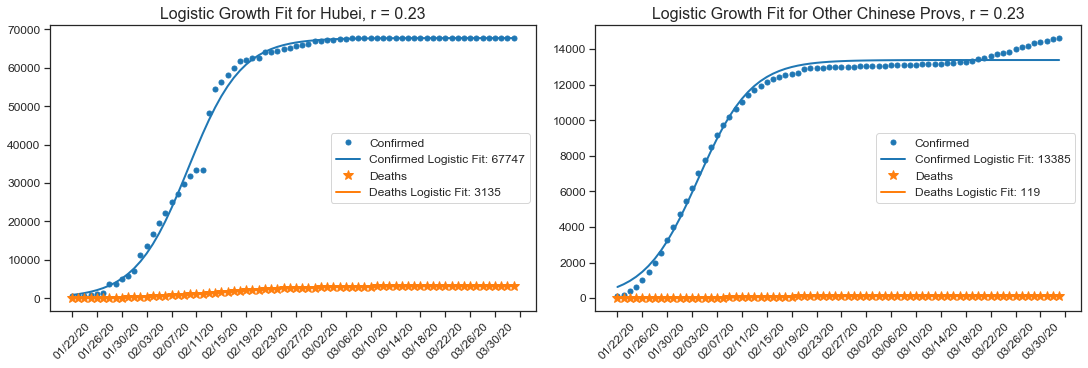

In [387]:
future = 0

x1 = np.arange(len(x) + future)

fig = plt.figure(figsize = (15, 5), constrained_layout=True)
gs = fig.add_gridspec(1, 2)

ax1 = fig.add_subplot(gs[0, 0])
plt.plot(x, y1, '.', ms = 10, color = cat_color['Confirmed'])
plt.plot(x1, logistic_growth(x1, popt1[0], popt1[1], popt1[2]), '-', color = cat_color['Confirmed'])
c1_end = logistic_growth(x1, popt1[0], popt1[1], popt1[2])[-1]
plt.plot(x, y3, '*', ms = 10, color = cat_color['Deaths'])
plt.plot(x1, logistic_growth(x1, popt3[0], popt3[1], popt3[2]), '-', color = cat_color['Deaths'])
d1_end = logistic_growth(x1, popt3[0], popt3[1], popt3[2])[-1]

plt.title(f'Logistic Growth Fit for Hubei, r = {popt1[0]:.2f}')
ax1.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)
# _ = ax1.set_xlim(right = len(time_str))
ax1.legend(['Confirmed', 
            f'Confirmed Logistic Fit: {c1_end:.0f}', 
            'Deaths', 
            f'Deaths Logistic Fit: {d1_end:.0f}'])


ax2 = fig.add_subplot(gs[0, 1])
plt.plot(x, y2, '.', ms = 10, color = cat_color['Confirmed'])
plt.plot(x1, logistic_growth(x1, popt2[0], popt2[1], popt2[2]), '-', color = cat_color['Confirmed'])
c2_end = logistic_growth(x1, popt2[0], popt2[1], popt2[2])[-1]
plt.plot(x, y4, '*', ms = 10, color = cat_color['Deaths'])
plt.plot(x1, logistic_growth(x1, popt4[0], popt4[1], popt4[2]), '-', color = cat_color['Deaths'])
d2_end = logistic_growth(x1, popt4[0], popt4[1], popt4[2])[-1]

plt.title(f'Logistic Growth Fit for Other Chinese Provs, r = {popt2[0]:.2f}')
ax2.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax2.xaxis.set_major_locator(myLocator)
ax2.tick_params(axis = 'x', labelrotation = 45)
ax2.legend(['Confirmed', 
            f'Confirmed Logistic Fit: {c2_end:.0f}', 
            'Deaths', 
            f'Deaths Logistic Fit: {d2_end:.0f}'])
# _ = ax2.set_xlim(right = len(time_str))

In [388]:
### world bar graph

In [389]:
df_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
df_recovered.sort_values(by = time_str[-1], inplace = True, ascending=False)
df_deaths.sort_values(by = time_str[-1], inplace = True, ascending=False)

In [ ]:
# recovered = df_recovered.loc[:,time_str[-1]].to_numpy()
# deaths = df_deaths.loc[:,time_str[-1]].to_numpy()
# confirmed = df_confirmed.loc[:,time_str[-1]].to_numpy()
# x = np.arange(len(confirmed))

# fig, ax = plt.subplots(1,1,figsize = (40,6))
# rects = ax.bar(x, confirmed)
# plt.bar(x, deaths)
# plt.bar(x, recovered, bottom = deaths)

# plt.legend(['Confirmed', 'Recovered', 'Deaths'])
# plt.yscale('log')
# plt.ylim(bottom = 10**-0.1)
# plt.xlim([-1, len(x)])
# a = ax.set_xticks(x)
# a = ax.set_xticklabels(list(df_confirmed.index))
# a = plt.xticks(rotation=-90)
# a = plt.title(f'Total {len(df_confirmed.index)-4} Countries affected', fontsize = 18)
# autolabel(rects, ax, '{:.0f}')

In [390]:
""" Specific Country/Region"""

' Specific Country/Region'

In [456]:
region = 'United Kingdom'
future = 50

In [458]:
### prepare dataframe
if(region in usstate_abbs_mapping.keys()):
    df_US = df_time_series.groupby(['Country_Region']).get_group(('US'))
    df_region = df_US.groupby(['Province_State']).get_group(region)
    df_region = reshape_dataframe(df_region.groupby('Category').sum().loc[:,time_str], time_str)
else:
    df_region = pd.concat([df_confirmed.loc[region,time_str], 
                         df_deaths.loc[region,time_str],
                         df_recovered.loc[region,time_str]],
                        axis = 1)
    df_region.columns = cdra_cols[:3]
    df_region = df_region.transpose()
    df_region = reshape_dataframe(df_region, time_str)

### data fitting
x = np.arange(len(time_str))
y1 = df_region.Confirmed.to_numpy()
y2 = df_region.Deaths.to_numpy()

res = df_region[df_region.GF_rolling_thr != 0.0].bfill(axis=1).index[0]
ind_t0 = max(0, time_str.index(res)-3)
t = np.arange(len(time_str))[ind_t0:]- ind_t0
pt1 = y1[ind_t0:]
pt2 = y2[ind_t0:]

popt_exp1, pcov_exp1 = opt.curve_fit(exp_growth,  t,  pt1, p0 = (0.1, 10), maxfev = 100000)
popt_exp2, pcov_exp2 = opt.curve_fit(exp_growth,  t,  pt2, maxfev = 10000)
if(future != 0):
    popt_logs1 = get_logistic_params(t, pt1, p0 = (0.1, 100, 1))# popt_log1, pcov_log1 = opt.curve_fit(logistic_growth,  t,  pt1, p0 = (0.1, 100, 1), maxfev=10000)
    popt_logs2 = get_logistic_params(t, pt2, p0 = (0.1, 100, 1))
else:
    popt_log1, pcov_log1 = opt.curve_fit(logistic_growth,  t,  pt1, p0 = (0.1, 100, 1), maxfev=10000)
    popt_log2, pcov_log2 = opt.curve_fit(logistic_growth,  t,  pt1, p0 = (0.1, 100, 1), maxfev=10000)


United Kingdom Confirmed Prediction: r=0.23, K = 53005~73892, peak increase at 03/31/20~04/02/20
United Kingdom Deaths prediction: r=0.23, K = 8036~202451252 (201217.4%), peak increase at +2~+48


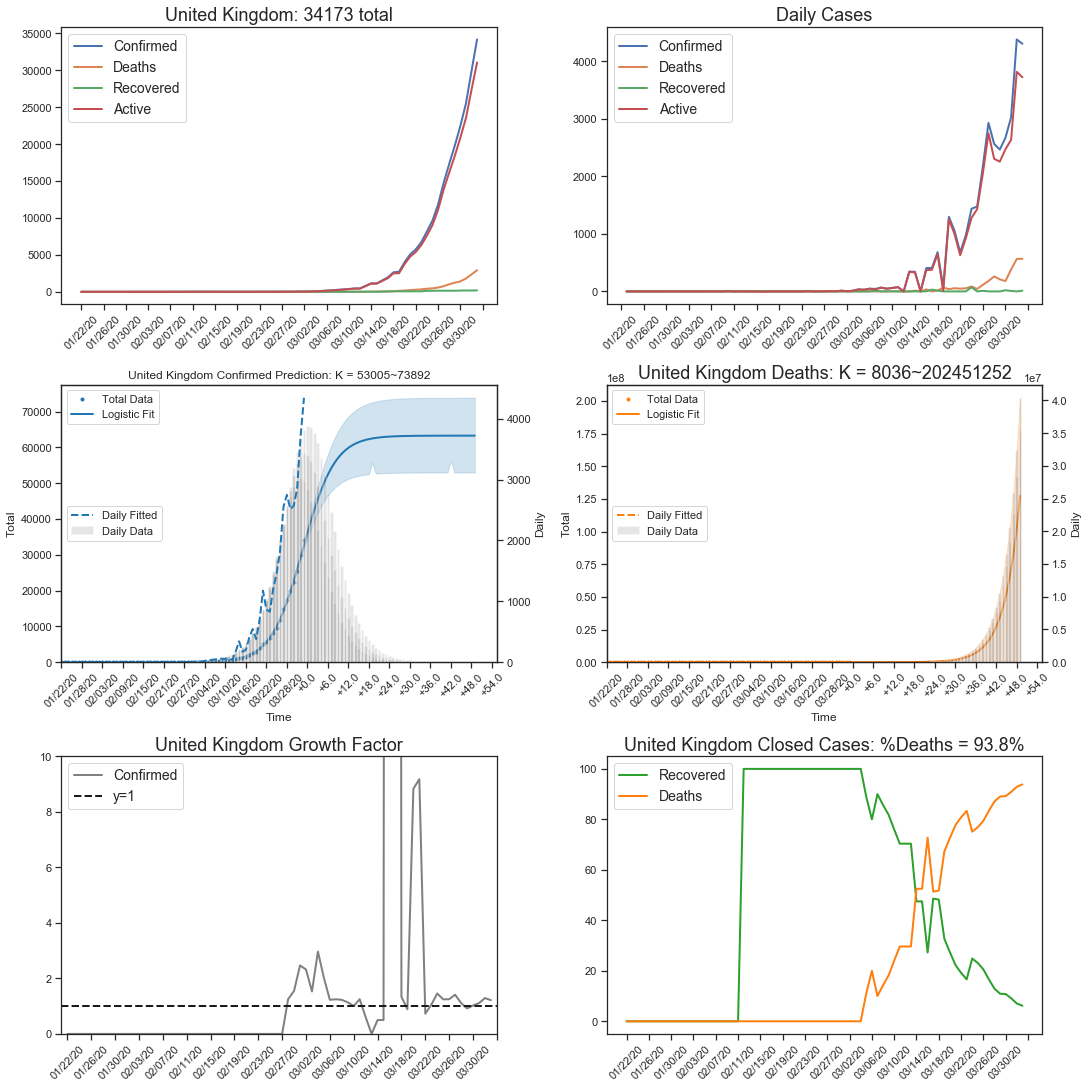

In [459]:
fig = plt.figure(figsize = (15, 15), constrained_layout=True, facecolor="1")
gs = fig.add_gridspec(3,2)

######### time series plot #########
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(df_region.loc[:, cdra_cols])
myLocator = mticker.MultipleLocator(4)
ax1.xaxis.set_major_locator(myLocator)
ax1.tick_params(axis = 'x', labelrotation = 45)
ax1.legend(cdra_cols, fontsize = 14)
ax1.set_title(f'{region}: {df_region.Confirmed[-1]} total', size = 18)

######### daily cases #########
ax5 = fig.add_subplot(gs[0, 1])
ax5.plot(df_region.loc[:,cdra_cols].diff())
ax5.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax5.xaxis.set_major_locator(myLocator)
ax5.tick_params(axis = 'x', labelrotation = 45)
ax5.legend(cdra_cols, fontsize = 14)
ax5.set_title('Daily Cases', size = 18)


######### confirmed fitting plot #########
ax2 = fig.add_subplot(gs[1, 0])
x = np.arange(len(time_str))
x1 = np.arange(len(t) + future)

if(future == 0):
    ax2.plot(x, y1, '.', ms = 10, color = cat_color['Confirmed'])
    ax2.plot(x1 + ind_t0, exp_growth(x1, popt_exp1[0], popt_exp1[1]), '--', color = cat_color['Confirmed'])
    ax2.plot(x1 + ind_t0, logistic_growth(x1, popt_log2[0], popt_log2[1], popt_log2[2]), color = cat_color['Confirmed'])
else:
    dy1 = df_region.Daily_Confirmed_smoothed
    ax21, ax22, y_ends, ind_midds = plot_predictions(ax2, x, y1, dy1, x1, ind_t0, popt_logs1, cat_color['Confirmed'])
    date_max = []
    for k in [0,1]:
        if(k == 0):
            ind = int(np.min(ind_midds))
        else:
            ind = int(np.max(ind_midds))
        if(ind < len(time_str)-ind_t0):
            date_max.append(time_str[ind+ind_t0])
        else:
            date_max.append(f'+{ind-(len(time_str)-ind_t0)}')
    confirmed_total = np.mean(y_ends)
if(future == 0):
    ax2.legend(['Confirmed', 
                'Confirmed Exp Fit', 
                'Confirmed Logistic Fit'])
    ax2.set_title(f'{region}: r={popt_exp1[0]:.2f}/{popt_log1[0]:.2f}', fontsize = 18)
else:
    ax2.set_title(f'{region} Confirmed Prediction: K = {np.min(y_ends):.0f}~{np.max(y_ends):.0f}')
    pp = f'{region} Confirmed Prediction: r={np.mean(popt_logs[:,0]):.2f}, K = {np.min(y_ends):.0f}~{np.max(y_ends):.0f}, peak increase at {date_max[0]}~{date_max[1]}'
    print(pp)
#     ax2.set_title(f'{region} Confirmed: r={popt_exp1[0]:.2f}/{popt_log1[0]:.2f}, K={confirm_end:.0f}\n max increase at {date_max}', fontsize = 18)
ax2.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn_future))
myLocator = mticker.MultipleLocator(6)
ax2.xaxis.set_major_locator(myLocator)
ax2.tick_params(axis = 'x', labelrotation = 45)
ax2.set_xlim(left = 0)


# ######### deaths fitting plot #########
ax2 = fig.add_subplot(gs[1, 1])
x = np.arange(len(time_str))
x1 = np.arange(len(t) + future)


if(future == 0):
    ax2.plot(x1 + ind_t0, exp_growth(x1, popt_exp2[0], popt_exp2[1]), '--', color = cat_color['Deaths'])
    ax2.plot(x1 + ind_t0, logistic_growth(x1, popt_log2[0], popt_log2[1], popt_log2[2]), color = cat_color['Deaths'])
else:
    dy2 = df_region.Daily_Deaths_smoothed
    ax21, ax22, y_ends, ind_midds = plot_predictions(ax2, x, y2, dy2, x1, ind_t0, popt_logs2, cat_color['Deaths'])
    date_max = []
    for k in [0,1]:
        if(k == 0):
            ind = int(np.min(ind_midds))
        else:
            ind = int(np.max(ind_midds))
        if(ind+ind_t0 < len(time_str)):
            date_max.append(time_str[ind+ind_t0])
        else:
            date_max.append(f'+{ind-(len(time_str)-ind_t0)}')
    deaths_total = np.mean(y_ends)
if(future == 0):
    ax2.legend(['Deaths', 
                'Deaths Exp Fit', 
                'Deaths Logistic Fit'])
    ax2.set_title(f'{region}: r{popt_exp1[0]:.2f}/{popt_log1[0]:.2f}', fontsize = 18)
else:
    ax2.set_title(f'{region} Deaths: K = {np.min(y_ends):.0f}~{np.max(y_ends):.0f}', fontsize = 18)
    pp = f'{region} Deaths prediction: r={np.mean(popt_logs[:,0]):.2f}, K = {np.min(y_ends):.0f}~{np.max(y_ends):.0f} ({deaths_total/confirmed_total*100:.1f}%), peak increase at {date_max[0]}~{date_max[1]}'
    print(pp)
ax2.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn_future))
myLocator = mticker.MultipleLocator(6)
ax2.xaxis.set_major_locator(myLocator)
ax2.tick_params(axis = 'x', labelrotation = 45)
ax2.set_xlim(left = 0)


######### growth factor #########
ax3 = fig.add_subplot(gs[2, 0])
x = np.arange(-1, len(time_str)+2)
ax3.plot(df_region.GF_rolling, color = 'grey')
ax3.plot(x, np.full(len(x), 1), '--', color = 'k')
ax3.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
myLocator = mticker.MultipleLocator(4)
ax3.xaxis.set_major_locator(myLocator)
ax3.tick_params(axis = 'x', labelrotation = 45)
ax3.legend(['Confirmed', 'y=1'], fontsize = 14)
ax3.set_title(f'{region} Growth Factor', size = 18)
ax3.set_xlim([-1, len(time_str)])
ax3.set_ylim([0, 10])

######### closed cases #########
ax8 = fig.add_subplot(gs[2, 1])
ax8.plot(df_region.Recovered_prop, color = cat_color['Recovered'])
ax8.plot(df_region.Death_prop, color = cat_color['Deaths'])
myLocator = mticker.MultipleLocator(4)
ax8.xaxis.set_major_locator(myLocator)
ax8.tick_params(axis = 'x', labelrotation = 45)
ax8.legend(['Recovered', 'Deaths'], fontsize = 14)
_ = ax8.set_title(f'{region} Closed Cases: %Deaths = {df_region.Death_prop[-1]:.1f}%', size = 18)

In [ ]:
ind_max

In [ ]:
"""World-wide testing"""

In [ ]:
df_world_test_stats = pd.read_csv(os.path.join(path_time_series, 'world_test_stats.csv'))
df_world_test_stats.set_index('Country_Region', inplace = True)

In [ ]:
df_ctry = df_time_series.groupby('Category').get_group('Confirmed').groupby('Country_Region').sum()
df_china_prov = df_time_series.groupby('Category').get_group('Confirmed').groupby('Country_Region').get_group('China').groupby('Province_State').sum()

In [ ]:
for i, reg in enumerate(df_world_test_stats.index):
    if('-' in reg):
        ls = reg.split(' - ')
        date = reformat_time_string(df_world_test_stats.loc[reg,'Date'])
        df_world_test_stats.loc[reg,'Total_Cases'] = df_china_prov.loc[ls[0], date]
    else:
        if(reg == 'US'):
            df_world_test_stats.loc[reg, 'Date'] = today
            df_world_test_stats.loc[reg, 'Total_tests'] = df_us_tests.totalTestResults.sum()
            df_world_test_stats.loc[reg, 'Total_Cases'] = df_confirmed.loc[reg, today]
        else:
            if(reg in df_ctry.index):
                date = reformat_time_string(df_world_test_stats.loc[reg,'Date'])
                df_world_test_stats.loc[reg, 'Total_Cases'] = df_ctry.loc[reg, date]
df_world_test_stats.dropna(how='any', inplace = True)
df_world_test_stats.loc[:,'Percent_Pos'] = df_world_test_stats.Total_Cases/df_world_test_stats.Total_tests*100
df_world_test_stats['Population'] = 0
overlap_index = intersection(list(df_world_population.index), list(df_world_test_stats.index))
df_world_test_stats.loc[overlap_index,'Population'] = df_world_population.loc[overlap_index, 'Population']
df_world_test_stats['Test_Per_Million'] = df_world_test_stats.Total_tests/(df_world_test_stats.Population/MILLION)
df_world_test_stats['Pos_per_Million'] = df_world_test_stats.Total_tests/(df_world_test_stats.Population/MILLION)

In [ ]:
fig = plt.figure(figsize = (15, 10), constrained_layout=True, facecolor="1")
gs = fig.add_gridspec(2,1)
x = np.arange(len(df_world_test_stats.index))

###
ax = fig.add_subplot(gs[0, :])
df_world_test_stats.sort_values(by = 'Percent_Pos', inplace = True, ascending=False)
sns.barplot(data = df_world_test_stats.reset_index(), x = 'Country_Region', y = 'Percent_Pos', color = 'grey')
a = ax.set_xticks(x)
a = ax.set_xticklabels(list(df_world_test_stats.index))
a = plt.xticks(rotation=-90)
_ = plt.title('Test positive rate')

ax = fig.add_subplot(gs[1, :])
df_world_test_stats.sort_values(by = 'Test_Per_Million', inplace = True, ascending=False)
sns.barplot(data = df_world_test_stats.reset_index(), x = 'Country_Region', y = 'Test_Per_Million', color = 'grey')
a = ax.set_xticks(x)
a = ax.set_xticklabels(list(df_world_test_stats.index))
a = plt.xticks(rotation=-90)
_ = plt.title('Test performed per million population')



In [ ]:
"""Playground"""

In [ ]:
# df_world_population = pd.read_csv(os.path.join(path_time_series, 'world_population_stats.csv'), encoding = "ISO-8859-1", engine='python')
# df_world_population.loc[:, 'Population'] = df_world_population.Population.astype('float')
# df_world_population.set_index('Country_Region', inplace = True)

# df_ctry_today = pd.DataFrame(columns = ['Total_Confirmed', 'New_Confirmed', 'Total_Deaths', 'New_Deaths']+list(df_world_population.columns), 
#                              index = df_confirmed.index)
# df_ctry_today['Total_Confirmed'] = df_confirmed[today]
# df_ctry_today['New_Confirmed'] = df_confirmed['New_Today']
# indexis_intersect = intersection(list(df_world_population.index), list(df_confirmed.index))
# df_ctry_today.loc[:,list(df_world_population.columns)] = df_world_population.loc[indexis_intersect,:]
# df_ctry_today['Pos_per_Million'] = df_ctry_today.Total_Confirmed/(df_ctry_today.Population/MILLION)
# df_ctry_today['Total_Deaths'] = df_deaths[today]
# df_ctry_today['New_Deaths'] = df_deaths.loc[:,time_str[-1]] - df_deaths.loc[:,time_str[-2]]
# df_ctry_today.dropna(axis = 0, how = 'any', inplace = True)
# thr = 500
# cat = 'Confirmed_Cat'
# df_ctry_today.loc[df_ctry_today.Total_Confirmed>=thr, cat] = f'above_{thr}'
# df_ctry_today.loc[df_ctry_today.Total_Confirmed<thr, cat] = f'below_{thr}'
# thr = np.percentile(df_ctry_today.Population, 50)
# cat = 'Population_Cat'
# df_ctry_today.loc[df_ctry_today.Population>=thr, cat] = f'above_{thr/MILLION:.1f}M'
# df_ctry_today.loc[df_ctry_today.Population<thr, cat] = f'below_{thr/MILLION:.1f}M'

# # df_ctry_today['rank_Total'] = df_ctry_today['Total'].rank(ascending = False)
# # df_ctry_today['rank_New_Today'] = df_ctry_today['New_Today'].rank(ascending = False)
# # df_ctry_today['rank_Pos_per_Million'] = df_ctry_today['Pos_per_Million'].rank(ascending = False)
# # df_ctry_today['rank_Population'] = df_ctry_today.Population.rank()

In [ ]:
cat = 'Confirmed_Cat'
df_plot = df_ctry_today[['Total_Confirmed', 'New_Confirmed', 'Pos_per_Million', 'Population']]
df_plot = np.log10(df_plot)
df_plot = df_plot.replace([np.inf, -np.inf], np.nan).dropna(how="any")
df_plot[cat] = df_ctry_today[cat]
plt.figure(figsize = (20, 20))
sns.pairplot(df_plot, kind = 'reg', hue = cat)

In [ ]:
cat = 'Population_Cat'
df_plot = df_ctry_today[['Total_Confirmed', 'New_Confirmed', 'Pos_per_Million', 'Population']]
df_plot = np.log10(df_plot)
df_plot = df_plot.replace([np.inf, -np.inf], np.nan).dropna(how="any")
df_plot[cat] = df_ctry_today[cat]
plt.figure(figsize = (20, 20))
sns.pairplot(df_plot, kind = 'reg', hue = cat)

In [ ]:
cat_x = 'Total_Confirmed'
cat_y = 'New_Confirmed'

df_fit = np.log10(df_ctry_today[[cat_x, cat_y]])
df_fit = df_fit.replace([np.inf, -np.inf], np.nan).dropna(how="any")

fig, ax = plt.subplots(1,1, figsize = (10, 8))
p1 = sns.regplot(data = df_fit, 
                 x = cat_x, y = cat_y, ax = ax)



X = np.array([df_fit[cat_x]]).transpose()
y = df_fit[cat_y].to_numpy()
reg = LinearRegression().fit(X, y)
y_predicted = reg.predict(X)
residuals = (y-y_predicted)
df_fit.loc[:,'Residuals'] = residuals
countries = []
countries += list(df_fit.sort_values(by = 'Residuals').index[:5])
countries += list(df_fit.sort_values(by = 'Residuals').index[-5:])

for ctry in countries:
    pos = [df_fit.loc[ctry, cat_x], 
              df_fit.loc[ctry, cat_y]]
    p1.text(pos[0]+0.01, pos[1] +0.01, ctry, 
            horizontalalignment='left', size='medium', 
            color='black',weight='normal')


In [ ]:
df_ctry_today.columns

In [ ]:
cat_x = 'Total_Confirmed'
cat_y = 'Total_Deaths'

fig = plt.figure(figsize = (15, 5), constrained_layout=True, facecolor="1")
gs = fig.add_gridspec(1,3)

ax = fig.add_subplot(gs[0,0])
df_fit = np.log10(df_ctry_today[[cat_x, cat_y]])
df_fit = df_fit.replace([np.inf, -np.inf], np.nan).dropna(how="any")
p1 = sns.regplot(data = df_fit, 
            x = cat_x, y = cat_y, ax = ax)

ax = fig.add_subplot(gs[0,1])
cat = 'Confirmed_Cat'
cats = list(set(df_ctry_today[cat]))

df_fit = np.log10(df_ctry_today[[cat_x, cat_y]])
df_fit = df_fit.replace([np.inf, -np.inf], np.nan).dropna(how="any")
df_fit[cat] = df_ctry_today[cat]
for icat in cats:
    p1 = sns.regplot(data = df_fit[df_fit[cat] == icat], 
                x = cat_x, y = cat_y, ax = ax)

ax = fig.add_subplot(gs[0,2])
cat = 'Population_Cat'
cats = list(set(df_ctry_today[cat]))

df_fit = np.log10(df_ctry_today[[cat_x, cat_y]])
df_fit = df_fit.replace([np.inf, -np.inf], np.nan).dropna(how="any")
df_fit[cat] = df_ctry_today[cat]
for icat in cats:
    p1 = sns.regplot(data = df_fit[df_fit[cat] == icat], 
                x = cat_x, y = cat_y, ax = ax)




# X = np.array([df_fit[cat_x]]).transpose()
# y = df_fit[cat_y].to_numpy()
# reg = LinearRegression().fit(X, y)
# y_predicted = reg.predict(X)
# residuals = (y-y_predicted)
# df_fit.loc[:,'Residuals'] = residuals
# countries = []
# countries += list(df_fit.sort_values(by = 'Residuals').index[:5])
# countries += list(df_fit.sort_values(by = 'Residuals').index[-5:])

# for ctry in countries:
#     pos = [df_fit.loc[ctry, cat_x], 
#               df_fit.loc[ctry, cat_y]]
#     p1.text(pos[0]+0.01, pos[1] +0.01, ctry, 
#             horizontalalignment='left', size='medium', 
#             color='black',weight='normal')


In [ ]:
cat_x = 'Total_Confirmed'
cat_y = 'Pos_per_Million'

fig = plt.figure(figsize = (15, 5), constrained_layout=True, facecolor="1")
gs = fig.add_gridspec(1,3)

ax = fig.add_subplot(gs[0,0])
df_fit = np.log10(df_ctry_today[[cat_x, cat_y]])
df_fit = df_fit.replace([np.inf, -np.inf], np.nan).dropna(how="any")
p1 = sns.regplot(data = df_fit, 
            x = cat_x, y = cat_y, ax = ax)

ax = fig.add_subplot(gs[0,1])
cat = 'Confirmed_Cat'
cats = list(set(df_ctry_today[cat]))

df_fit = np.log10(df_ctry_today[[cat_x, cat_y]])
df_fit = df_fit.replace([np.inf, -np.inf], np.nan).dropna(how="any")
df_fit[cat] = df_ctry_today[cat]
for icat in cats:
    p1 = sns.regplot(data = df_fit[df_fit[cat] == icat], 
                x = cat_x, y = cat_y, ax = ax)
ax.legend(cats)

ax = fig.add_subplot(gs[0,2])
cat = 'Population_Cat'
cats = list(set(df_ctry_today[cat]))

df_fit = np.log10(df_ctry_today[[cat_x, cat_y]])
df_fit = df_fit.replace([np.inf, -np.inf], np.nan).dropna(how="any")
df_fit[cat] = df_ctry_today[cat]
for icat in cats:
    p1 = sns.regplot(data = df_fit[df_fit[cat] == icat], 
                x = cat_x, y = cat_y, ax = ax)
ax.legend(cats)


In [ ]:
cat_x = 'Total_Confirmed'
cat_y = 'Pos_per_Million'
df_fit = np.log10(df_ctry_today[[cat_x, cat_y]])
df_fit = df_fit.replace([np.inf, -np.inf], np.nan).dropna(how="any")

fig, ax = plt.subplots(1,1, figsize = (10, 8))
# ax.set(xscale = 'log', yscale = 'log')
# x_lim = [np.min(df_ctry_today[cat_x]), np.max(df_ctry_today[cat_x])]
# y_lim = [np.min(df_ctry_today[cat_y]), np.max(df_ctry_today[cat_y])]
p1 = sns.regplot(data = df_fit, 
                x = cat_x, y = cat_y, ax = ax)


X = np.array([df_fit[cat_x]]).transpose()
y = df_fit[cat_y].to_numpy()
reg = LinearRegression().fit(X, y)
y_predicted = reg.predict(X)
residuals = (y-y_predicted)
df_fit.loc[:,'Residuals'] = residuals
countries = []
countries += list(df_fit.sort_values(by = 'Residuals').index[:5])
countries += list(df_fit.sort_values(by = 'Residuals').index[-5:])

for ctry in countries:
    pos = [df_fit.loc[ctry, cat_x], 
              df_fit.loc[ctry, cat_y]]
    p1.text(pos[0]+0.1, pos[1] +0.1, ctry, 
            horizontalalignment='left', size='medium', 
            color='black',weight='normal')


In [ ]:
cat_x = 'Population'
cat_y = 'Pos_per_Million'

df_fit = np.log10(df_ctry_today[[cat_x, cat_y]])

fig, ax = plt.subplots(1,1, figsize = (10, 8))
# ax.set(xscale = 'log', yscale = 'log')
x_lim = [np.min(df_ctry_today[cat_x]), np.max(df_ctry_today[cat_x])]
y_lim = [np.min(df_ctry_today[cat_y]), np.max(df_ctry_today[cat_y])]
p1 = sns.regplot(data = df_fit, 
                x = cat_x, y = cat_y, ax = ax, robust = False)

X = np.array([df_fit[cat_x]]).transpose()
y = df_fit[cat_y].to_numpy()
reg = LinearRegression().fit(X, y)
y_predicted = reg.predict(X)
residuals = (y-y_predicted)
df_fit.loc[:,'Residuals'] = np.abs(residuals)
countries = []
countries += list(df_fit.sort_values(by = 'Residuals').index[-10:])
if 'China' not in countries:
    countries.append('China')
# countries += list(df_fit.sort_values(by = 'Residuals').index[-5:])

for ctry in countries:
    pos = [df_fit.loc[ctry, cat_x], 
              df_fit.loc[ctry, cat_y]]
    p1.text(pos[0]+0.1, pos[1] +0.1, ctry, 
            horizontalalignment='left', size='medium', 
            color='black',weight='normal')

# y_lim = [0, 2500]
# ax.set_ylim(y_lim)
# ax.set_xlim(x_lim)

# ax.set_xscale('log')
# ax.set_yscale('log')

In [ ]:
country_list = df_ctry_today.sort_values(by = 'Total', ascending = False, inplace = False).index[0:50]


In [ ]:
cat_x = 'Population'
cat_y = 'Pos_per_Million'

df_fit = np.log10(df_ctry_today.loc[country_list, [cat_x, cat_y]])

fig, ax = plt.subplots(1,1, figsize = (10, 8))
# ax.set(xscale = 'log', yscale = 'log')
# x_lim = [np.min(df_ctry_today[cat_x]), np.max(df_ctry_today[cat_x])]
# y_lim = [np.min(df_ctry_today[cat_y]), np.max(df_ctry_today[cat_y])]
p1 = sns.regplot(data = df_fit, 
                x = cat_x, y = cat_y, ax = ax)

X = np.array([df_fit[cat_x]]).transpose()
y = df_fit[cat_y].to_numpy()
reg = LinearRegression().fit(X, y)
y_predicted = reg.predict(X)
residuals = (y-y_predicted)
df_fit.loc[:,'Residuals'] = np.abs(residuals)
countries = []
countries += list(df_fit.sort_values(by = 'Residuals').index[-10:])

if 'China' not in countries:
    countries.append('China')
# countries += list(df_fit.sort_values(by = 'Residuals').index[-5:])

for ctry in countries:
    pos = [df_fit.loc[ctry, cat_x], 
              df_fit.loc[ctry, cat_y]]
    p1.text(pos[0]+0.1, pos[1] +0.1, ctry, 
            horizontalalignment='left', size='medium', 
            color='black',weight='normal')

# y_lim = [0, 2500]a
# ax.set_ylim(y_lim)
# ax.set_xlim(x_lim)

# ax.set_xscale('log')
# ax.set_yscale('log')

In [ ]:
cat_x = 'Total'
cat_y = 'Pos_per_Million'

df_fit = np.log10(df_ctry_today[[cat_x, cat_y]])

fig, ax = plt.subplots(1,1, figsize = (10, 8))
# ax.set(xscale = 'log', yscale = 'log')
x_lim = [np.min(df_ctry_today[cat_x]), np.max(df_ctry_today[cat_x])]
y_lim = [np.min(df_ctry_today[cat_y]), np.max(df_ctry_today[cat_y])]
p1 = sns.regplot(data = df_fit, 
                x = cat_x, y = cat_y, ax = ax, robust = False)

X = np.array([df_fit[cat_x]]).transpose()
y = df_fit[cat_y].to_numpy()
reg = LinearRegression().fit(X, y)
y_predicted = reg.predict(X)
residuals = (y-y_predicted)
df_fit.loc[:,'Residuals'] = np.abs(residuals)
countries = []
countries += list(df_fit.sort_values(by = 'Residuals').index[-10:])
if 'China' not in countries:
    countries.append('China')
# countries += list(df_fit.sort_values(by = 'Residuals').index[-5:])

for ctry in countries:
    pos = [df_fit.loc[ctry, cat_x], 
              df_fit.loc[ctry, cat_y]]
    p1.text(pos[0]+0.1, pos[1] +0.1, ctry, 
            horizontalalignment='left', size='medium', 
            color='black',weight='normal')

# y_lim = [0, 2500]
# ax.set_ylim(y_lim)
# ax.set_xlim(x_lim)

# ax.set_xscale('log')
# ax.set_yscale('log')

In [ ]:
cat_x = 'Total'
cat_y = 'Pos_per_Million'

df_fit = np.log10(df_ctry_today.loc[country_list, [cat_x, cat_y]])

fig, ax = plt.subplots(1,1, figsize = (10, 8))
# ax.set(xscale = 'log', yscale = 'log')
# x_lim = [np.min(df_ctry_today[cat_x]), np.max(df_ctry_today[cat_x])]
# y_lim = [np.min(df_ctry_today[cat_y]), np.max(df_ctry_today[cat_y])]
p1 = sns.regplot(data = df_fit, 
                x = cat_x, y = cat_y, ax = ax)

X = np.array([df_fit[cat_x]]).transpose()
y = df_fit[cat_y].to_numpy()
reg = LinearRegression().fit(X, y)
y_predicted = reg.predict(X)
residuals = (y-y_predicted)
df_fit.loc[:,'Residuals'] = np.abs(residuals)
countries = []
countries += list(df_fit.sort_values(by = 'Residuals').index[-10:])

if 'China' not in countries:
    countries.append('China')
# countries += list(df_fit.sort_values(by = 'Residuals').index[-5:])

for ctry in countries:
    pos = [df_fit.loc[ctry, cat_x], 
              df_fit.loc[ctry, cat_y]]
    p1.text(pos[0]+0.05, pos[1] +0.05, ctry, 
            horizontalalignment='left', size='medium', 
            color='black',weight='normal')

# y_lim = [0, 2500]a
# ax.set_ylim(y_lim)
# ax.set_xlim(x_lim)

# ax.set_xscale('log')
# ax.set_yscale('log')

In [ ]:
"""Archive Land"""


In [ ]:
# colors = pl.cm.tab10(np.linspace(0,1,len(countries)))
# for i, ctr in enumerate(countries):
#     ax4.plot(df_gf[ctr], color = colors[i])
# x = np.arange(-1, len(time_str)+2)
# ax4.plot(x, np.full(len(x), 1), '--', color = 'k')

# ax4.legend(countries, loc = 'upper left')
# ax4.set_yscale('linear')
# ax4.set_ylim([0, 5])
# a = ax4.set_title('Growth Factors: top 10 countries with most new cases')
# ax4.xaxis.set_major_formatter(mticker.FuncFormatter(format_fn))
# myLocator = mticker.MultipleLocator(4)
# ax4.xaxis.set_major_locator(myLocator)
# ax4.set_xlim(left = -1, right = len(time_str))
# ax4.tick_params(axis = 'x', labelrotation = 45)

# growth_factors = (df_confirmed.loc[countries, time_str[2:]].to_numpy() - df_confirmed.loc[countries, time_str[1:-1]].to_numpy()) \
# /(df_confirmed.loc[countries, time_str[1:-1]].to_numpy() - df_confirmed.loc[countries, time_str[:-2]].to_numpy())
# y = (growth_factors[:,-1] + growth_factors[:,-2])/2
# y[~np.isfinite(y)] = 0
# y = df_gf.loc[time_str[-1],:]

# # rects = ax5.bar(x[y<=1], y[y<=1], color = 'tab:blue')
# # rects = ax5.bar(x[y>1], y[y>1], color = 'tab:red')

# a = ax5.set_xticks(x)
# a = ax5.set_xticklabels(countries)
# ax5.tick_params(axis = 'x', labelrotation = -90)
# autolabel(rects, ax5, '{:.2f}')
# ymax = np.ceil(np.max(y)) + 1
# ax5.set_ylim([0, ymax])
# a = ax5.set_title('Growth Factor of places w/ >100 confirmed cases')

In [ ]:
# if(today not in time_str):
#     print('New Data from CSSE! Update time_series_covid19.csv now!')
#     gps_today = list(df_today.groupby(['Country_Region', 'Province_State']).groups.keys())
#     gps_ts = list(df_time_series.groupby(['Country_Region', 'Province_State']).groups.keys())
#     for igp, gp in enumerate(gps_today):
#         if(igp%30 == 0):
#             print(igp)
#         if(gp not in gps_ts):
#             print(gp)
#             df_new = pd.DataFrame(columns = df_time_series.columns)
#             for i, cat in enumerate(cat_cols[:-1]):
#                 df_new.loc[i,'Country_Region'] = gp[0]
#                 df_new.loc[i,'Province_State'] = gp[1]
#                 df_new.loc[i, time_str] = 0
#                 df_new.loc[i, today] = df_today.groupby(['Country_Region', 'Province_State']).get_group(gp).loc[:,cat].to_list()[0]
#                 df_new.loc[i, 'Category'] = cat
#             df_time_series = df_time_series.append(df_new, ignore_index = True)
#         else:
#             for cat in cat_cols[:-1]:
#                 i = df_time_series[(df_time_series.Country_Region == gp[0]) 
#                    * (df_time_series.Province_State == gp[1]) 
#                    * (df_time_series.Category == cat)].index
#                 df_time_series.loc[i,today] = df_today.groupby(['Country_Region', 'Province_State']).get_group(gp).loc[:,cat].to_list()[0]
#     time_str, time_datetime = get_time_columns(df_time_series.columns)
#     time_str = sorted(time_str)
#     cols_ordered = ['Province_State', 'Country_Region', 'Category'] + time_str
#     df_time_series = df_time_series.reindex(cols_ordered, axis=1)
# #     df_time_series.to_csv(os.path.join(path_time_series, 'time_series_covid19.csv'), index = False)
# #     print('New spreadsheet saved!')
# else:
#     print(f'Data up to date! Today = {today}')

In [ ]:
# path_time_series = os.path.join(master_path, 'csse_covid_19_data', 'csse_covid_19_time_series')
# path_daily = os.path.join(master_path, 'csse_covid_19_data', 'csse_covid_19_daily_reports')
# today_csv = '03-23-2020.csv'
# today = '3/23/20'
# folders, files = parse_folder_info(path_time_series)
# df_time_series = pd.DataFrame()
# # df_time_series_reorged = pd.DataFrame(columns = ['Country/Region', 'Province/State', 'Date', 'Category', 'Number'])
# for file_name in files:
#     if('.csv' in file_name and '-covid-' in file_name):
#         df_current = pd.read_csv(os.path.join(path_time_series, file_name))        
#         category = file_name[21:file_name.index('.csv')]
#         print(category)
#         df_current.loc[:,'Category'] = category
#         if df_time_series.empty:
#             df_time_series = df_current
#         else:
#             df_time_series = df_time_series.append(df_current, ignore_index = True)
# time_str, time_datetime = get_time_columns(df_time_series.columns)
# # df_today = pd.read_csv(os.path.join(path_daily, today_csv))

# df_time_series.loc[df_time_series.loc[:,'Province/State'].isna(),'Province/State'] = 'N/A'
# # df_today.loc[df_today.loc[:,'Province/State'].isna(), 'Province/State'] = 'N/A'
# # df_time_series.loc[:,'New Today'] = df_time_series.loc[:,time_str[-1]] - df_time_series.loc[:,time_str[-2]]

### fix 3/12/20 datapoints
# alt_cols = ['3/12/20', '3/15/20']
# df_alteration = pd.read_csv(os.path.join(master_path, 'time_series_covid19_alteration.csv'))
# df_alteration.set_index('Country/Region', inplace = True)
# for ctry in df_alteration.index:
#     ind = (df_time_series['Category'] == 'Confirmed') & (df_time_series['Country/Region'] == ctry)
#     if(np.sum(ind) > 1):
#         ind = ind & (df_time_series['Province/State'] == ctry)
#     for col in alt_cols:
#         if not pd.isna(df_alteration.loc[ctry, col]):
#             df_time_series.loc[ind, col] = df_alteration.loc[ctry, col]

### total number
# ax1 = fig.add_subplot(gs[0, 0])

# df_confirmed.sort_values(by = time_str[-1], inplace = True, ascending=False)
# countries = list(df_confirmed.index[0:15])
# df_plot = df_confirmed.loc[countries,time_str]

# colors = pl.cm.tab20(np.linspace(0,1,len(countries)))
# for i, ctr in enumerate(countries):
#     if(ctr == 'US'):
#         ax1.plot(df_plot.loc[ctr,:], color = colors[i], linewidth = 3)
#     else:
#         ax1.plot(df_plot.loc[ctr,:], color = colors[i])

# ax1.legend(countries)
# ax1.set_yscale('linear')
# # plt.ylim(top = 2000)
# ax1.set_title('Total number of cases: top 15')
# myLocator = mticker.MultipleLocator(4)
# ax1.xaxis.set_major_locator(myLocator)
# ax1.tick_params(axis = 'x', labelrotation = 45)


In [ ]:
### Daily new cases              
# ax3 = fig.add_subplot(gs[1, :])
# # hubei_daily = hubei.loc['Confirmed',:].to_numpy()[1:] - hubei.loc['Confirmed',:].to_numpy()[:-1]
# # co_daily = china_others.loc['Confirmed',:].to_numpy()[1:] - china_others.loc['Confirmed',:].to_numpy()[0:-1]
# x = np.arange(len(time_str))
# width = 0.35
# rects1 = ax3.bar(x - width/2, df_prov.Daily, width = width)
# rects2 = ax3.bar(x + width/2, df_co.Daily, width = width)
# # ax3.set_yscale('log')
# ax3.set_yscale('linear')
# ax3.set_ylim([0, 200])
# a = ax3.set_xticks(x)
# a = ax3.set_xticklabels(time_str[1:])
# ax3.tick_params(axis = 'x', labelrotation = 45)
# ax3.legend([prov, 'China w/o Hubei'], fontsize = 14)
# ax3.set_ylim(bottom = 10**-0.1)
# ax3.set_title('Daily Cases', size = 18)


In [ ]:
df_world_test_stats

In [ ]:
datetime.datetime.strptime(df_world_test_stats.Date[0], '%m/%d/%y')

In [ ]:
# ############ params ############
# num_states = 10
# colors_line = pl.cm.tab10(np.linspace(0,1,num_states))
# colors_pie = pl.cm.Set3(np.linspace(0,1,11))
# colors_pie[7,:] = colors_pie[10:]
# colors_pie[10,:] = 0.85

# ############ figure ############
# fig = plt.figure(figsize = (15, 20), constrained_layout=True, facecolor="1")
# gs = fig.add_gridspec(4, 2)

# plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# ############ testing ############
# ### testing: positive rate v1
# cat = 'Percent_Positive'
# ax6 = fig.add_subplot(gs[2, 0])

# df_plot = df_us_tests.sort_values(by = cat, inplace = False, ascending=True)
# df_plot.reset_index(inplace = True, drop = True)
# x = np.arange(len(df_plot.index))
# y = df_plot.loc[x,cat].to_numpy()
# x1 = np.arange(-2, len(df_plot.index) + 2)
# ax6.set_xlim([-1, len(x) + 0.5])
# i_ca = df_plot[df_plot.State == 'California'].index[0]

# sns.scatterplot(x = x, y=cat, hue = 'Governer_Affiliation', palette = palette, data=df_plot, ax = ax6)
# ax6.scatter(i_ca, df_plot.loc[i_ca, cat], marker = '*', s = 50, color = 'k')
# ax6.plot(x1, np.full(len(x1), np.median(df_plot.loc[:,cat])), '--', color = 'grey')
# a = ax6.set_title(f'Positive%: Order from low to high')

# ### testing: positive rate v2
# ax8 = fig.add_subplot(gs[2, 1])

# df_plot = df_us_tests.sort_values(by = 'positive', inplace = False, ascending=False)
# df_plot.reset_index(inplace = True, drop = True)
# states = list(df_plot.State[0:num_states])

# x = np.arange(len(states))
# x1 = np.arange(-2, len(states) + 2)
# y = df_plot.loc[x,cat].to_numpy()

# rects = ax8.bar(x, y)
# ax8.plot(x1, np.full(len(x1), np.median(df_plot.loc[:,cat])), '--', color = 'grey')
# ax8.tick_params(axis = 'x', labelrotation = -90)
# autolabel(rects, ax8, '{:.1f}')
# ax8.set_xlim([-1, len(x) + 0.5])
# ax8.set_xticks(x)
# ax8.set_xticklabels(states)
# a = ax8.set_title(f'Positive%: US median = {np.median(df_plot.loc[:,cat]):.1f}%')


# ### testing: test per million v1
# ax7 = fig.add_subplot(gs[3, 0])
# cat = 'Test_Per_Million'

# df_plot = df_us_tests.sort_values(by = cat, inplace = False, ascending=False)
# states = list(df_us_tests.index[0:num_states])

# df_plot.reset_index(inplace = True, drop = True)
# x = np.arange(len(df_plot.index))
# y = df_plot.loc[x,cat].to_numpy()
# x1 = np.arange(-2, len(df_plot.index) + 2)
# i_ca = df_plot[df_plot.State == 'California'].index[0]

# sns.scatterplot(x = x, y=cat, hue = 'Governer_Affiliation', palette = palette, data=df_plot, ax = ax7)
# ax7.scatter(i_ca, df_plot.loc[i_ca, cat], marker = '*', s = 50, color = 'k')
# ax7.plot(x1, np.full(len(x1), np.median(df_plot.loc[:,cat])), '--', color = 'grey')
# a = ax7.set_title(f'Test per million: Order from high to low')
# ax7.set_xlim([-1, len(x) + 0.5])

# ### testing: test per million v2
# ax9 = fig.add_subplot(gs[3, 1])

# df_plot = df_us_tests.sort_values(by = 'positive', inplace = False, ascending=False)
# df_plot.reset_index(inplace = True, drop = True)
# states = list(df_plot.State[0:num_states])

# x = np.arange(len(states))
# x1 = np.arange(-2, len(states) + 2)
# y = df_plot.loc[x,cat].to_numpy()

# rects = ax9.bar(x, y)
# ax9.plot(x1, np.full(len(x1), np.median(df_plot.loc[:,cat])), '--', color = 'grey')
# a = ax9.set_xticks(x)
# a = ax9.set_xticklabels(states)
# ax9.tick_params(axis = 'x', labelrotation = -90)
# autolabel(rects, ax9, '{:.0f}')
# # ax8.set_ylim([0, ymax])
# ax9.set_xlim([-1, len(x) + 0.5])
# a = ax9.set_title(f'Test per million: US median = {np.median(df_plot.loc[:,cat]):.0f}')

# ### testing: Severeness index
# ax10 = fig.add_subplot(gs[4, :])
# cat = 'Pos_Per_Million'

# df_plot = df_us_tests.sort_values(by = cat, inplace = False, ascending=False)
# df_plot.reset_index(inplace = True, drop = True)

# x = np.arange(len(df_plot.index))
# y = df_plot.loc[x,cat].to_numpy()
# i_ca = df_plot[df_plot.State == 'California'].index[0]

# ax10.bar(x, y, color = 'tab:blue')
# ax10.bar(i_ca, y[i_ca], color = 'tab:orange')
# ax10.tick_params(axis = 'x', labelrotation = -90)
# a = ax10.set_xticks(x)
# a = ax10.set_xticklabels(list(df_plot.State))
# a = ax10.set_title(f'Positive cases per million population: Order from high to low')
# ax10.set_xlim(-1, len(x))
# ax10.set_yscale('log')

### Wish List:
- Time Series for US and state testing

In [ ]:
df_world_test_stats.Date